<a href="https://colab.research.google.com/github/Haque14/MSE504/blob/main/MATH_629_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Gaussian Process Regrassion Model

In [1]:
# ===== Colab setup: install Excel support & imports =====
!pip -q install openpyxl

import os, math, warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from google.colab import files
from io import BytesIO

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ConstantKernel as C
from sklearn.preprocessing import StandardScaler as TargetScaler
from sklearn.inspection import permutation_importance

# ---------- small helpers ----------
def gaussian_pdf(x, mu, sigma):
    if sigma <= 0: return np.zeros_like(x)
    return (1.0 / (np.sqrt(2.0 * np.pi) * sigma)) * np.exp(-0.5 * ((x - mu) / sigma)**2)

def make_ohe_dense():
    # Handle sklearn <1.2 vs >=1.2
    try:
        return OneHotEncoder(handle_unknown="ignore", sparse_output=False)
    except TypeError:
        return OneHotEncoder(handle_unknown="ignore", sparse=False)

def _read_raw(path_or_buf, is_excel):
    if is_excel:
        return pd.read_excel(path_or_buf, header=None, dtype=str)
    else:
        return pd.read_csv(path_or_buf, header=None, dtype=str)

def _read_with_header(path_or_buf, is_excel, header_row):
    if is_excel:
        return pd.read_excel(path_or_buf, header=header_row)
    else:
        return pd.read_csv(path_or_buf, header=header_row)

def _looks_like_name(x):
    if x is None or (isinstance(x, float) and np.isnan(x)): return False
    s = str(x).strip()
    if not s or s.lower().startswith("unnamed"): return False
    return True

def _score_header_row(values):
    names = [v for v in values if _looks_like_name(v)]
    score = len(names)
    text = " ".join([str(v) for v in values if isinstance(v, str)])
    for k in ["Mix ID","Curing","Cement","aggregate","Slump",
              "Compressive","Strength","Unit Weight","Air Content","SAM","Shrinkage","Resitivity","Resistivity"]:
        if k.lower() in text.lower(): score += 2
    return score

def detect_header_row(raw_df, search_limit=30):
    best_idx, best_score = None, -1
    nrows = min(search_limit, len(raw_df))
    for r in range(nrows):
        sc = _score_header_row(raw_df.iloc[r, :].tolist())
        if sc > best_score:
            best_idx, best_score = r, sc
    return best_idx, best_score

def clean_frame(df):
    df = df.dropna(axis=1, how="all").dropna(axis=0, how="all")
    df.columns = [str(c).strip() for c in df.columns]
    if df.columns.duplicated().any():
        counts, new_cols = {}, []
        for c in df.columns:
            if c not in counts:
                counts[c] = 0; new_cols.append(c)
            else:
                counts[c] += 1; new_cols.append(f"{c}_{counts[c]}")
        df.columns = new_cols
    return df


In [2]:
# ===== Upload your file (CSV or XLSX) =====
print("Upload your dataset (.csv or .xlsx)...")
uploaded = files.upload()
assert len(uploaded) == 1, "Please upload exactly one file."

fname = list(uploaded.keys())[0]
print(f"Uploaded: {fname}")

is_excel = fname.lower().endswith((".xlsx", ".xls"))
buf = BytesIO(uploaded[fname])

# Auto-detect header row
raw = _read_raw(buf, is_excel)
hdr, score = detect_header_row(raw, search_limit=30)
print(f"[INFO] Auto-detected header row: {hdr} (score={score})")

# Re-read with header and clean
buf.seek(0)
df = _read_with_header(buf, is_excel, hdr)
df = clean_frame(df)
print("[INFO] Columns detected:")
print(df.columns.tolist())


Upload your dataset (.csv or .xlsx)...


Saving ML-dataset.xlsx.csv to ML-dataset.xlsx (1).csv
Uploaded: ML-dataset.xlsx (1).csv
[INFO] Auto-detected header row: 4 (score=49)
[INFO] Columns detected:
['Mix ID', 'Curing Days', 'Cement amount (lb)', 'Fly ash amount (lb)', 'Coarse aggregate amount (lb)', 'Intermediate aggregate amount (lb)', 'Fine aggregate amount (lb)', 'Water amount (lb)', 'WRA amount (gm)', 'AE amount (gm)', 'Combined aggregate passing at 1" Sieve', 'Combined aggregate passing at 1/2" Sieve', 'Combined aggregate passing at #4 Sieve', 'Combined aggregate passing at #16 Sieve', 'Combined aggregate passing at #50 Sieve', 'Combined aggregate passing at #200 Sieve', 'Workability factor', 'Coarseness factor', 'Slump (inch)', 'Unit Weight (lb/ft3)', 'Air Content (%)', 'Compressive Strength', 'SAM Number', 'Shrinkage', 'Resitivity']



=== K-FOLD GPR (OOF) for target: SAM Number ===
[INFO] Samples: 200 | Input features: 20

[INFO] Fold 1/5 – train=160 val=40
[INFO]  Fitted kernel: 0.747**2 * RBF(length_scale=[100, 100, 100, 51.7, 6.3, 100, 100, 100, 100, 0.01, 100, 4.32, 73.7, 100, 99.9, 0.929, 2.85, 1.86, 0.674, 2.83]) + WhiteKernel(noise_level=1e-05)

[INFO] Fold 2/5 – train=160 val=40
[INFO]  Fitted kernel: 0.802**2 * RBF(length_scale=[100, 100, 100, 3.13, 100, 100, 100, 100, 100, 0.0229, 100, 5.2, 99.4, 100, 100, 0.917, 100, 1.83, 0.684, 3.33]) + WhiteKernel(noise_level=1e-05)

[INFO] Fold 3/5 – train=160 val=40
[INFO]  Fitted kernel: 0.76**2 * RBF(length_scale=[100, 100, 100, 3.01, 100, 100, 100, 100, 100, 0.01, 100, 4.99, 14.9, 100, 100, 0.913, 100, 1.78, 0.706, 3.02]) + WhiteKernel(noise_level=1e-05)

[INFO] Fold 4/5 – train=160 val=40
[INFO]  Fitted kernel: 0.765**2 * RBF(length_scale=[100, 100, 100, 2.99, 100, 100, 100, 100, 100, 0.01, 100, 4.78, 71.9, 100, 100, 0.948, 100, 1.87, 0.687, 2.96]) + WhiteKernel

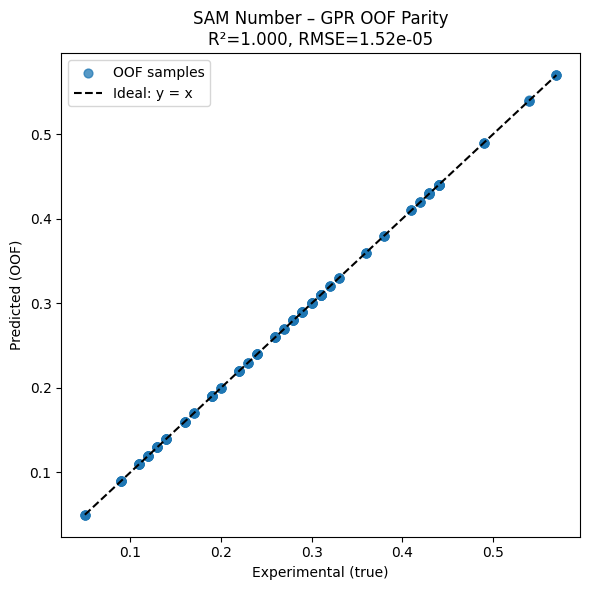

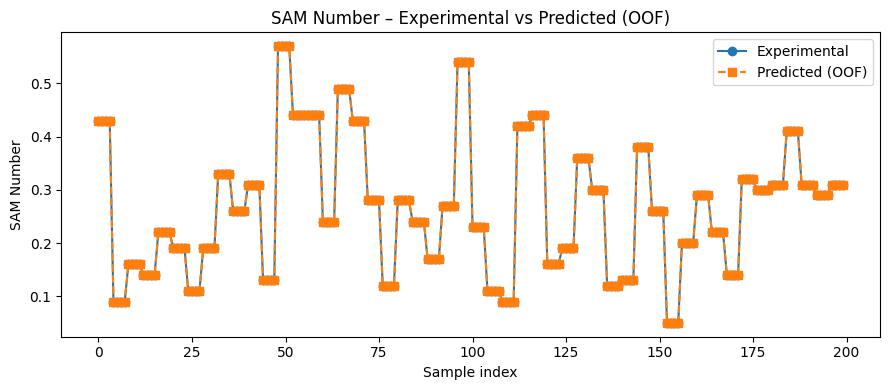

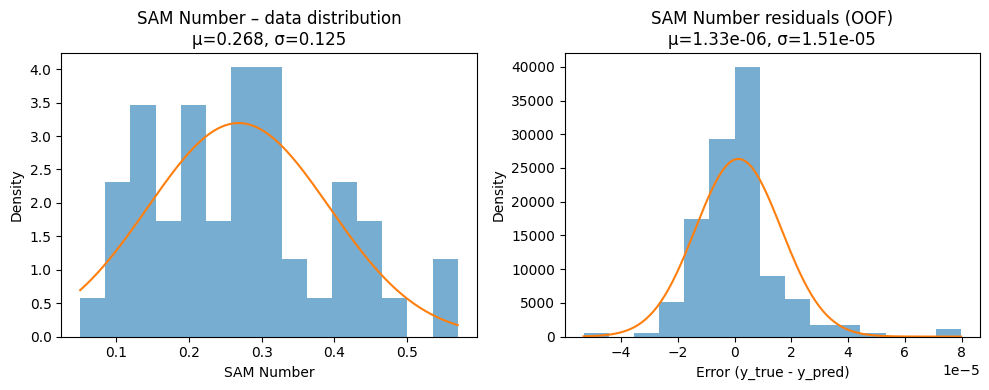

[INFO] Permutation importance on full data for: SAM Number
[INFO] Top 10 influential inputs for SAM Number (permutation):
   Unit Weight (lb/ft3): 30.60%
   Air Content (%): 27.06%
   Combined aggregate passing at 1" Sieve: 14.89%
   Water amount (lb): 14.29%
   Coarseness factor: 9.55%
   Combined aggregate passing at #4 Sieve: 2.16%
   Combined aggregate passing at #200 Sieve: 0.93%
   Slump (inch): 0.53%
   Fly ash amount (lb): 0.00%
   Combined aggregate passing at #50 Sieve: 0.00%


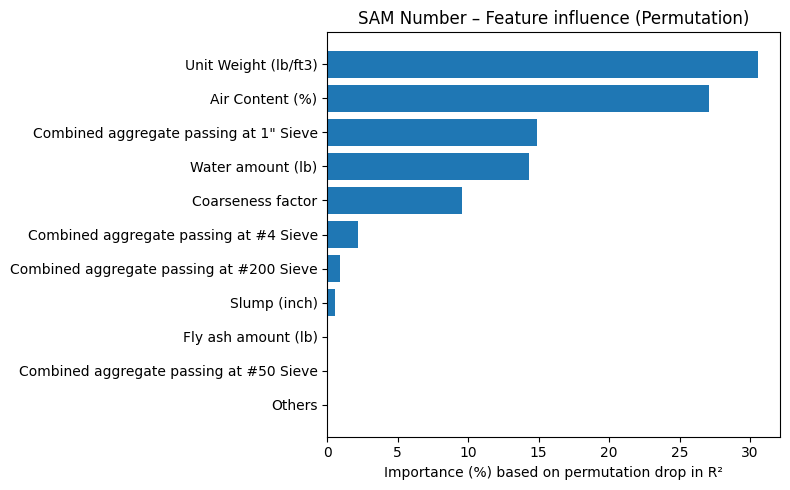


=== K-FOLD GPR (OOF) for target: Shrinkage ===
[WARN] Dropped 100 rows with non-numeric Shrinkage
[INFO] Samples: 100 | Input features: 20

[INFO] Fold 1/5 – train=80 val=20
[INFO]  Fitted kernel: 0.958**2 * RBF(length_scale=[0.161, 100, 6.36, 100, 1.09, 100, 100, 3.43, 2.1, 100, 100, 0.585, 100, 100, 100, 100, 6.71, 100, 100, 100]) + WhiteKernel(noise_level=0.199)

[INFO] Fold 2/5 – train=80 val=20
[INFO]  Fitted kernel: 1.01**2 * RBF(length_scale=[0.0263, 100, 1.99, 100, 100, 100, 100, 2.97, 100, 100, 100, 100, 0.0753, 0.505, 100, 7.37, 100, 100, 100, 100]) + WhiteKernel(noise_level=0.0514)

[INFO] Fold 3/5 – train=80 val=20
[INFO]  Fitted kernel: 1.28**2 * RBF(length_scale=[2.26, 100, 100, 100, 100, 2.85, 1.93, 100, 100, 100, 100, 0.208, 100, 1.55, 100, 100, 4.99, 93.9, 13.5, 100]) + WhiteKernel(noise_level=1e-05)

[INFO] Fold 4/5 – train=80 val=20
[INFO]  Fitted kernel: 1.77**2 * RBF(length_scale=[3.79, 100, 100, 100, 100, 1.37, 85.1, 2.22, 3.77, 100, 100, 6.64, 100, 1.15, 100, 10

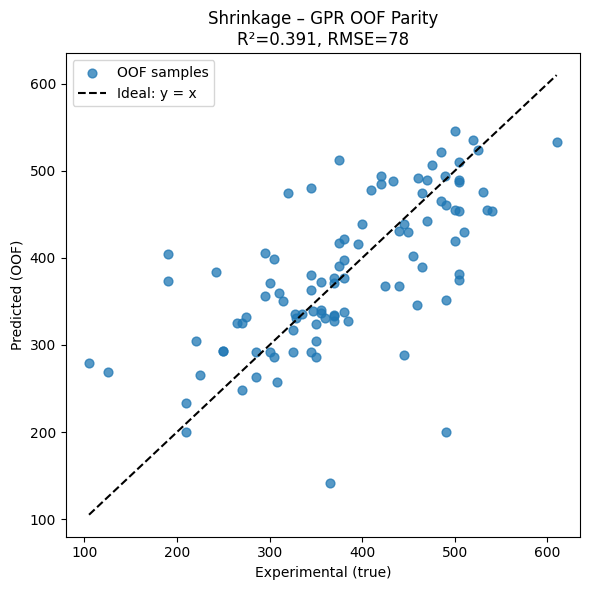

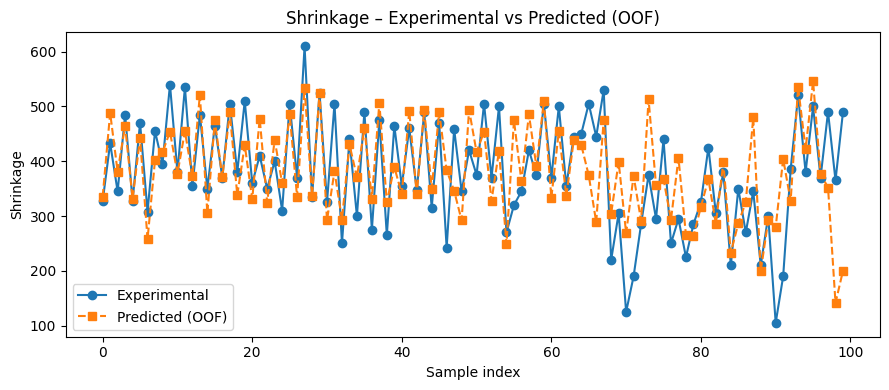

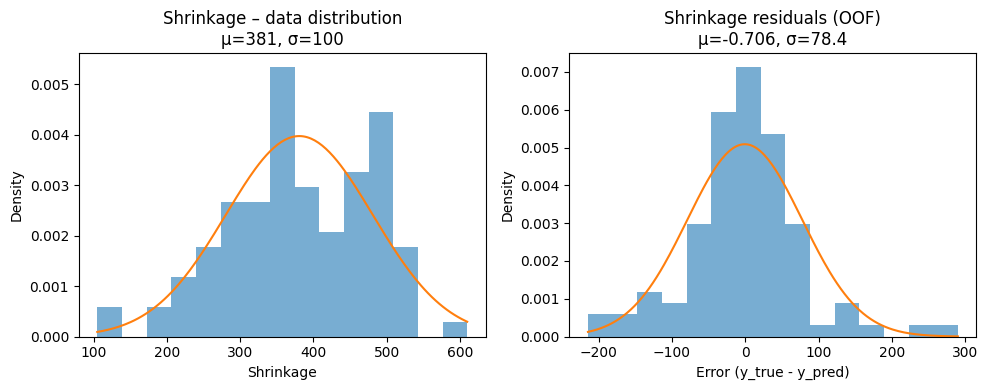

[INFO] Permutation importance on full data for: Shrinkage
[INFO] Top 10 influential inputs for Shrinkage (permutation):
   Combined aggregate passing at #4 Sieve: 29.63%
   Curing Days: 27.99%
   Water amount (lb): 21.07%
   Combined aggregate passing at #50 Sieve: 19.66%
   Coarseness factor: 0.83%
   Combined aggregate passing at #16 Sieve: 0.52%
   Unit Weight (lb/ft3): 0.29%
   Fly ash amount (lb): 0.00%
   Workability factor: 0.00%
   Fine aggregate amount (lb): 0.00%


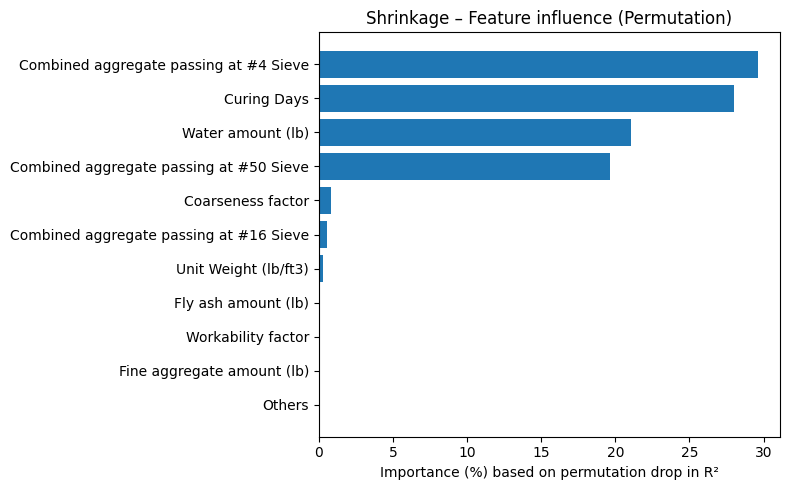


=== K-FOLD GPR (OOF) for target: Resitivity ===
[WARN] Dropped 50 rows with non-numeric Resitivity
[INFO] Samples: 150 | Input features: 20

[INFO] Fold 1/5 – train=120 val=30
[INFO]  Fitted kernel: 1.63**2 * RBF(length_scale=[3.02, 100, 100, 7.09, 2.82, 5.14, 77.6, 3.51, 100, 8.25, 100, 100, 100, 10.5, 100, 100, 100, 1.48, 1.73, 10.3]) + WhiteKernel(noise_level=0.0371)

[INFO] Fold 2/5 – train=120 val=30
[INFO]  Fitted kernel: 1.75**2 * RBF(length_scale=[3.2, 100, 100, 100, 100, 2.61, 100, 3.14, 100, 100, 1.21, 4.74, 100, 15.4, 100, 100, 4.65, 9.4, 8.87, 5.11]) + WhiteKernel(noise_level=0.0546)

[INFO] Fold 3/5 – train=120 val=30
[INFO]  Fitted kernel: 1.26**2 * RBF(length_scale=[2.42, 100, 100, 100, 100, 1.93, 100, 1.11, 100, 100, 1.2, 100, 100, 100, 100, 100, 1.83, 5.91, 100, 2.89]) + WhiteKernel(noise_level=0.0253)

[INFO] Fold 4/5 – train=120 val=30
[INFO]  Fitted kernel: 1.54**2 * RBF(length_scale=[2.48, 100, 100, 100, 100, 2.84, 100, 3.27, 9.29, 100, 0.691, 100, 100, 3.29, 100,

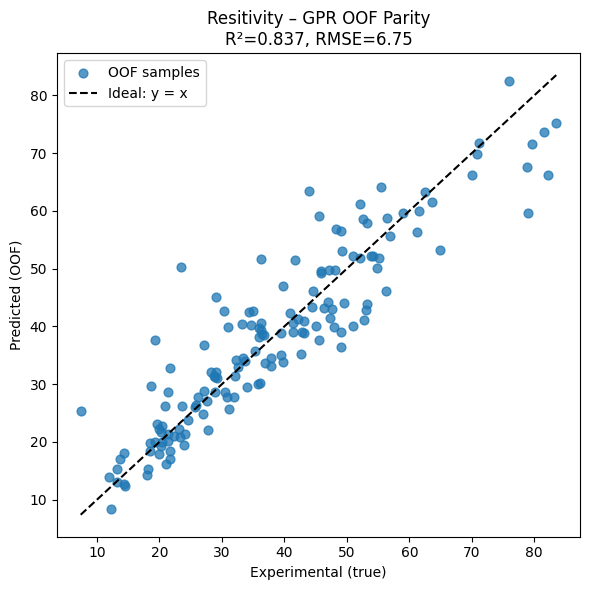

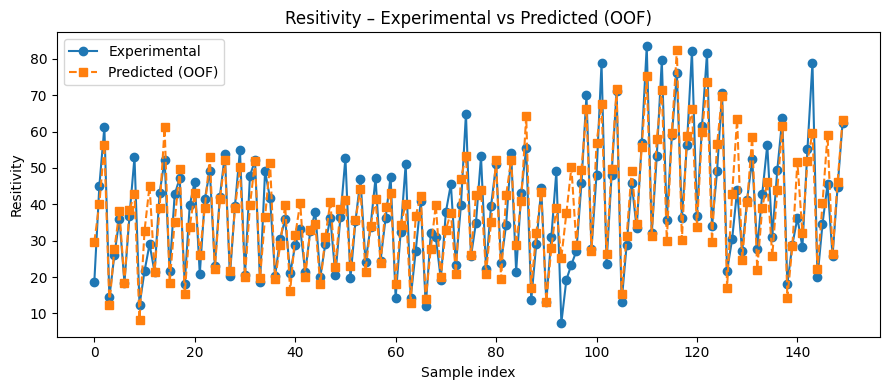

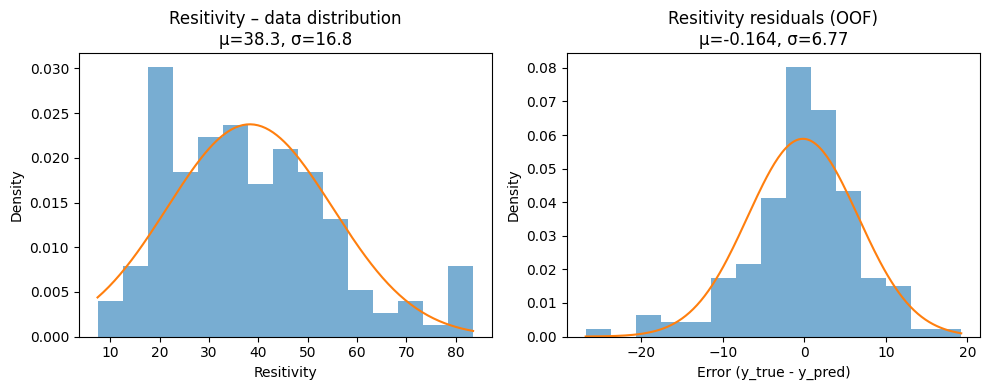

[INFO] Permutation importance on full data for: Resitivity
[INFO] Top 10 influential inputs for Resitivity (permutation):
   Curing Days: 39.27%
   Fine aggregate amount (lb): 14.97%
   Combined aggregate passing at 1/2" Sieve: 13.48%
   Combined aggregate passing at #4 Sieve: 8.93%
   Air Content (%): 7.08%
   Coarseness factor: 7.00%
   WRA amount (gm): 5.75%
   Slump (inch): 2.27%
   Unit Weight (lb/ft3): 1.02%
   Combined aggregate passing at #50 Sieve: 0.23%


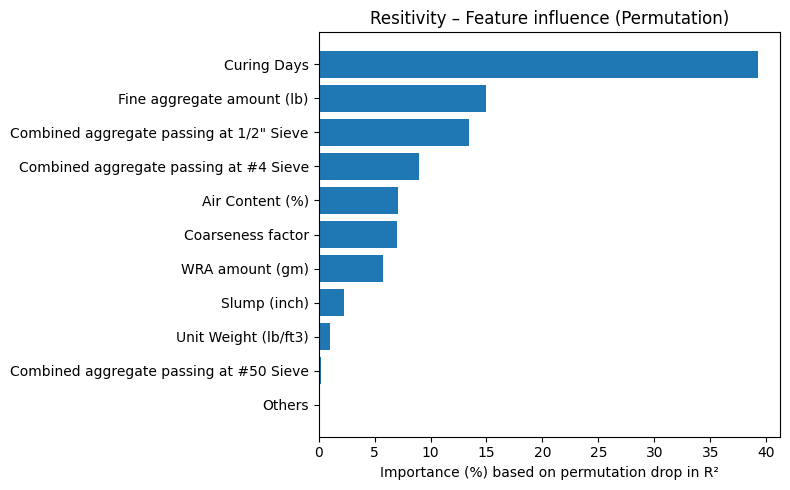


All targets evaluated with K-Fold OOF (GPR only) ✔


In [3]:
# ===== GPR settings =====
TARGETS = ["SAM Number", "Shrinkage", "Resitivity"]  # match your dataset
K_FOLDS = 5
RANDOM_SEED = 42
N_RESTARTS = 5

# You asked to EXCLUDE "Compressive Strength" from inputs:
non_input_extras = {"Compressive Strength", "Mix ID", "ID", "Sample", "Sample ID"}

# For summary across targets
results = []

# Create an output folder in Colab (optional)
out_dir = "/content/gpr_outputs"
os.makedirs(out_dir, exist_ok=True)

for TARGET_COL in TARGETS:
    print("\n" + "="*90)
    print(f"=== K-FOLD GPR (OOF) for target: {TARGET_COL} ===")

    if TARGET_COL not in df.columns:
        print(f"[WARN] Target '{TARGET_COL}' not found. Skipping.")
        continue

    # Build X/y (exclude all targets, plus "Compressive Strength" & IDs from inputs)
    non_input_cols = set(TARGETS) | non_input_extras
    X_cols = [c for c in df.columns if c not in non_input_cols]

    df_t = df.copy()
    # Be tolerant to different spellings of Resistivity
    if TARGET_COL not in df_t.columns and TARGET_COL.lower().startswith("resit"):
        # attempt to find a likely alternative
        for c in df_t.columns:
            if "resist" in c.lower():
                TARGET_COL = c
                print(f"[INFO] Using '{TARGET_COL}' as resistivity column")
                break

    df_t[TARGET_COL] = pd.to_numeric(df_t[TARGET_COL], errors="coerce")
    before = len(df_t)
    df_t = df_t.dropna(subset=[TARGET_COL]).copy()
    if len(df_t) < before:
        print(f"[WARN] Dropped {before - len(df_t)} rows with non-numeric {TARGET_COL}")

    X_all = df_t[X_cols]
    y_all = df_t[TARGET_COL].values
    n = len(df_t)
    print(f"[INFO] Samples: {n} | Input features: {len(X_cols)}")

    # OOF holders
    y_oof = np.full(n, np.nan)
    sigma_oof = np.full(n, np.nan)

    kf = KFold(n_splits=K_FOLDS, shuffle=True, random_state=RANDOM_SEED)

    for fold, (tr_idx, va_idx) in enumerate(kf.split(X_all), start=1):
        print(f"\n[INFO] Fold {fold}/{K_FOLDS} – train={len(tr_idx)} val={len(va_idx)}")

        X_tr, X_va = X_all.iloc[tr_idx], X_all.iloc[va_idx]
        y_tr, y_va = y_all[tr_idx], y_all[va_idx]

        # Preprocessing per fold (no leakage)
        num_feats = X_tr.select_dtypes(include=[np.number]).columns.tolist()
        cat_feats = [c for c in X_tr.columns if c not in num_feats]

        num_pipe = Pipeline([("imputer", SimpleImputer(strategy="median")),
                             ("scaler", StandardScaler())])
        cat_pipe = Pipeline([("imputer", SimpleImputer(strategy="most_frequent")),
                             ("onehot", make_ohe_dense())])

        pre = ColumnTransformer(
            [("num", num_pipe, num_feats),
             ("cat", cat_pipe, cat_feats)],
            remainder="drop"
        )

        Z_tr = pre.fit_transform(X_tr)
        Z_va = pre.transform(X_va)

        # Scale target per fold
        y_scaler = TargetScaler()
        y_tr_scaled = y_scaler.fit_transform(y_tr.reshape(-1,1)).ravel()

        # GPR with ARD RBF + White
        n_features = Z_tr.shape[1]
        kernel = (C(1.0, (1e-2, 1e2)) *
                  RBF(length_scale=np.ones(n_features), length_scale_bounds=(1e-2, 1e2))
                  + WhiteKernel(1e-2, (1e-5, 1e0)))

        gpr = GaussianProcessRegressor(
            kernel=kernel,
            alpha=0.0,
            normalize_y=False,
            n_restarts_optimizer=N_RESTARTS,
            random_state=RANDOM_SEED + fold
        )
        gpr.fit(Z_tr, y_tr_scaled)
        print("[INFO]  Fitted kernel:", gpr.kernel_)

        y_va_scaled_pred, y_va_std_scaled = gpr.predict(Z_va, return_std=True)
        y_va_pred = y_scaler.inverse_transform(y_va_scaled_pred.reshape(-1,1)).ravel()
        sigma_va  = y_va_std_scaled * float(y_scaler.scale_[0])

        y_oof[va_idx] = y_va_pred
        sigma_oof[va_idx] = sigma_va

    # --- OOF Metrics ---
    R2   = r2_score(y_all, y_oof)
    RMSE = math.sqrt(mean_squared_error(y_all, y_oof))
    MAE  = mean_absolute_error(y_all, y_oof)
    mean_sigma = float(np.nanmean(sigma_oof))

    print("\n=== OOF Metrics (GPR) ===")
    print(f"Target: {TARGET_COL}")
    print(f"R²   : {R2:.4f}")
    print(f"RMSE : {RMSE:.4f}")
    print(f"MAE  : {MAE:.4f}")
    print(f"Mean predictive σ (OOF): {mean_sigma:.4f}")

    results.append({
        "Target": TARGET_COL,
        "R2": R2,
        "RMSE": RMSE,
        "MAE": MAE,
        "MeanSigma": mean_sigma
    })

    # --- PLOTS (OOF) ---
    # Parity
    plt.figure(figsize=(6,6))
    mn = float(np.nanmin([y_all.min(), y_oof.min()]))
    mx = float(np.nanmax([y_all.max(), y_oof.max()]))
    plt.scatter(y_all, y_oof, s=40, alpha=0.75, label="OOF samples")
    plt.plot([mn, mx], [mn, mx], 'k--', label="Ideal: y = x")
    plt.xlabel("Experimental (true)")
    plt.ylabel("Predicted (OOF)")
    plt.title(f"{TARGET_COL} – GPR OOF Parity\nR²={R2:.3f}, RMSE={RMSE:.3g}")
    plt.legend(); plt.tight_layout()
    plt.savefig(os.path.join(out_dir, f"gpr_{TARGET_COL.replace(' ','_')}_parity.png"), dpi=150)
    plt.show()

    # Index
    plt.figure(figsize=(9,4))
    idx = np.arange(n)
    plt.plot(idx, y_all, "o-", label="Experimental")
    plt.plot(idx, y_oof, "s--", label="Predicted (OOF)")
    plt.xlabel("Sample index"); plt.ylabel(TARGET_COL)
    plt.title(f"{TARGET_COL} – Experimental vs Predicted (OOF)")
    plt.legend(); plt.tight_layout()
    plt.savefig(os.path.join(out_dir, f"gpr_{TARGET_COL.replace(' ','_')}_index.png"), dpi=150)
    plt.show()

    # Normal distributions (values & residuals)
    errors = y_all - y_oof
    plt.figure(figsize=(10,4))
    # data
    plt.subplot(1,2,1)
    plt.hist(y_all, bins=15, density=True, alpha=0.6)
    mu_y, std_y = np.nanmean(y_all), np.nanstd(y_all, ddof=1)
    xs = np.linspace(np.nanmin(y_all), np.nanmax(y_all), 200)
    plt.plot(xs, gaussian_pdf(xs, mu_y, std_y))
    plt.title(f"{TARGET_COL} – data distribution\nμ={mu_y:.3g}, σ={std_y:.3g}")
    plt.xlabel(TARGET_COL); plt.ylabel("Density")
    # residuals
    plt.subplot(1,2,2)
    plt.hist(errors, bins=15, density=True, alpha=0.6)
    mu_e, std_e = np.nanmean(errors), np.nanstd(errors, ddof=1)
    xs_e = np.linspace(np.nanmin(errors), np.nanmax(errors), 200)
    plt.plot(xs_e, gaussian_pdf(xs_e, mu_e, std_e))
    plt.title(f"{TARGET_COL} residuals (OOF)\nμ={mu_e:.3g}, σ={std_e:.3g}")
    plt.xlabel("Error (y_true - y_pred)"); plt.ylabel("Density")
    plt.tight_layout()
    plt.savefig(os.path.join(out_dir, f"gpr_{TARGET_COL.replace(' ','_')}_normals.png"), dpi=150)
    plt.show()

    # ===== Feature Importance (Permutation on FULL DATA) =====
    print(f"[INFO] Permutation importance on full data for: {TARGET_COL}")

    # Build full-data preprocessing & model (single fit)
    num_feats_all = X_all.select_dtypes(include=[np.number]).columns.tolist()
    cat_feats_all = [c for c in X_all.columns if c not in num_feats_all]

    num_pipe_all = Pipeline([("imputer", SimpleImputer(strategy="median")),
                             ("scaler", StandardScaler())])
    cat_pipe_all = Pipeline([("imputer", SimpleImputer(strategy="most_frequent")),
                             ("onehot", make_ohe_dense())])

    pre_all = ColumnTransformer(
        [("num", num_pipe_all, num_feats_all),
         ("cat", cat_pipe_all, cat_feats_all)],
        remainder="drop"
    )

    Z_all = pre_all.fit_transform(X_all)
    y_scaler_all = TargetScaler()
    y_all_scaled = y_scaler_all.fit_transform(y_all.reshape(-1,1)).ravel()

    n_features_all = Z_all.shape[1]
    kernel_all = (C(1.0, (1e-2, 1e2)) *
                  RBF(length_scale=np.ones(n_features_all), length_scale_bounds=(1e-2, 1e2))
                  + WhiteKernel(1e-2, (1e-5, 1e0)))

    gpr_all = GaussianProcessRegressor(
        kernel=kernel_all,
        alpha=0.0,
        normalize_y=False,
        n_restarts_optimizer=N_RESTARTS,
        random_state=RANDOM_SEED
    ).fit(Z_all, y_all_scaled)

    # Wrap to predict in original units for permutation_importance
    class GPRWrapper:
        def __init__(self, gpr, y_scaler):
            self.gpr = gpr; self.y_scaler = y_scaler
        def fit(self, X, y): return self
        def predict(self, X):
            y_scaled = self.gpr.predict(X)
            return self.y_scaler.inverse_transform(y_scaled.reshape(-1,1)).ravel()

    wrapped = GPRWrapper(gpr_all, y_scaler_all)
    perm = permutation_importance(
        wrapped, Z_all, y_all,
        n_repeats=20, random_state=RANDOM_SEED, scoring="r2"
    )

    imp = np.maximum(perm.importances_mean, 0)
    if imp.sum() == 0:
        print(f"[WARN] All permutation importances are zero for {TARGET_COL}. Skipping bar chart.")
    else:
        imp_norm = imp / imp.sum()

        # feature names after preprocessing
        feat_names = []
        try:
            for name, trans, cols in pre_all.transformers_:
                if name == "num":
                    feat_names += list(cols)
                elif name == "cat":
                    cat_trans = pre_all.named_transformers_["cat"]
                    if hasattr(cat_trans, "get_feature_names_out"):
                        cat_names = cat_trans.get_feature_names_out(cols)
                        feat_names += list(cat_names)
                    else:
                        feat_names += list(cols)
        except Exception:
            feat_names = list(X_all.columns)

        feat_names = np.array(feat_names)
        order = np.argsort(imp_norm)[::-1]
        feat_sorted = feat_names[order]
        imp_sorted = imp_norm[order]

        print(f"[INFO] Top 10 influential inputs for {TARGET_COL} (permutation):")
        for i in range(min(10, len(feat_sorted))):
            print(f"   {feat_sorted[i]}: {imp_sorted[i]*100:.2f}%")

        # Top 10 + Others bar chart
        top_n = min(10, len(feat_sorted))
        feat_top = list(feat_sorted[:top_n])
        imp_top = list(imp_sorted[:top_n])
        if len(feat_sorted) > top_n:
            others = 1.0 - sum(imp_top)
            if others > 0:
                feat_top.append("Others")
                imp_top.append(others)

        plt.figure(figsize=(8,5))
        y_pos = np.arange(len(feat_top))
        plt.barh(y_pos, [v*100 for v in imp_top], align='center')
        plt.yticks(y_pos, feat_top)
        plt.gca().invert_yaxis()
        plt.xlabel("Importance (%) based on permutation drop in R²")
        plt.title(f"{TARGET_COL} – Feature influence (Permutation)")
        plt.tight_layout()
        plt.savefig(os.path.join(out_dir, f"gpr_{TARGET_COL.replace(' ','_')}_feature_importance_bar.png"), dpi=150)
        plt.show()

print("\nAll targets evaluated with K-Fold OOF (GPR only) ✔")


Target        R2       RMSE        MAE  MeanSigma
0  SAM Number  1.000000   0.000015   0.000010   0.000686
1   Shrinkage  0.390750  78.020307  56.328790  49.162392
2  Resitivity  0.837196   6.753885   4.900503   5.197609

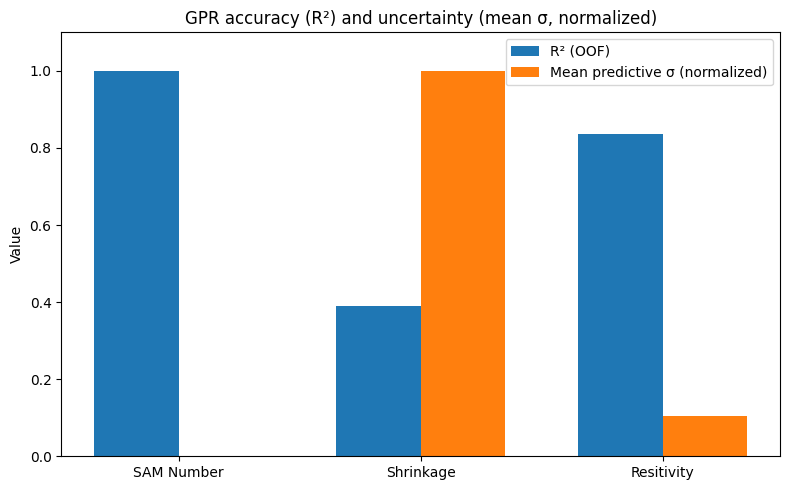

All figures and tables saved under: /content/gpr_outputs


In [4]:
# ===== Summary across targets: R² + normalized uncertainty =====
if results:
    res_df = pd.DataFrame(results)
    display(res_df)

    sigma_norm = res_df["MeanSigma"] / res_df["MeanSigma"].replace(0, np.nan).max()
    sigma_norm = sigma_norm.fillna(0.0)

    x = np.arange(len(res_df))
    width = 0.35

    plt.figure(figsize=(8,5))
    plt.bar(x - width/2, res_df["R2"], width, label="R² (OOF)")
    plt.bar(x + width/2, sigma_norm, width, label="Mean predictive σ (normalized)")
    plt.xticks(x, res_df["Target"])
    plt.ylim(0, 1.1)
    plt.ylabel("Value")
    plt.title("GPR accuracy (R²) and uncertainty (mean σ, normalized)")
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(out_dir, "summary_R2_uncertainty.png"), dpi=150)
    plt.show()

print(f"All figures and tables saved under: {out_dir}")


Upload your dataset (.csv or .xlsx)…


Saving ML-dataset.xlsx.csv to ML-dataset.xlsx (2).csv
[INFO] Header row: 4 (score=45)
[INFO] Columns: ['Mix ID', 'Curing Days', 'Cement amount (lb)', 'Fly ash amount (lb)', 'Coarse aggregate amount (lb)', 'Intermediate aggregate amount (lb)', 'Fine aggregate amount (lb)', 'Water amount (lb)', 'WRA amount (gm)', 'AE amount (gm)', 'Combined aggregate passing at 1" Sieve', 'Combined aggregate passing at 1/2" Sieve', 'Combined aggregate passing at #4 Sieve', 'Combined aggregate passing at #16 Sieve', 'Combined aggregate passing at #50 Sieve', 'Combined aggregate passing at #200 Sieve', 'Workability factor', 'Coarseness factor', 'Slump (inch)', 'Unit Weight (lb/ft3)', 'Air Content (%)', 'Compressive Strength', 'SAM Number', 'Shrinkage', 'Resitivity']
[WARN] Dropped 100 rows with non-numeric Shrinkage
[INFO] Samples: 100 | Features: 22
[INFO] Applying log1p transform for Shrinkage (train) and expm1 for reporting.

[INFO] Fold 1/5 – train=80 val=20
[INFO]  Kernel: 1.91**2 * RBF(length_scale=[

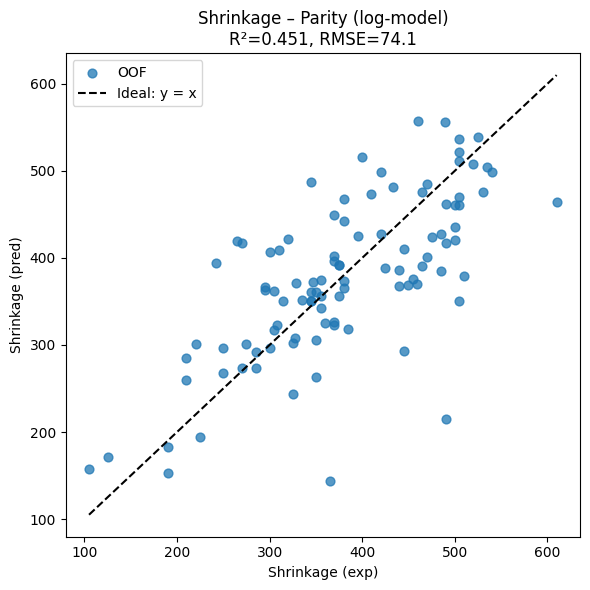

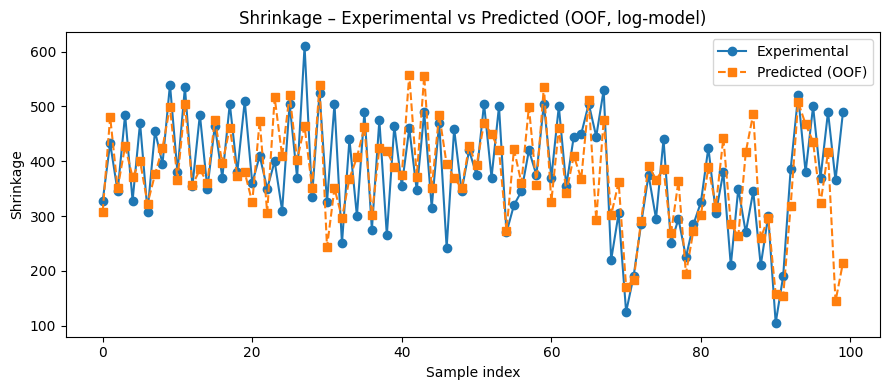

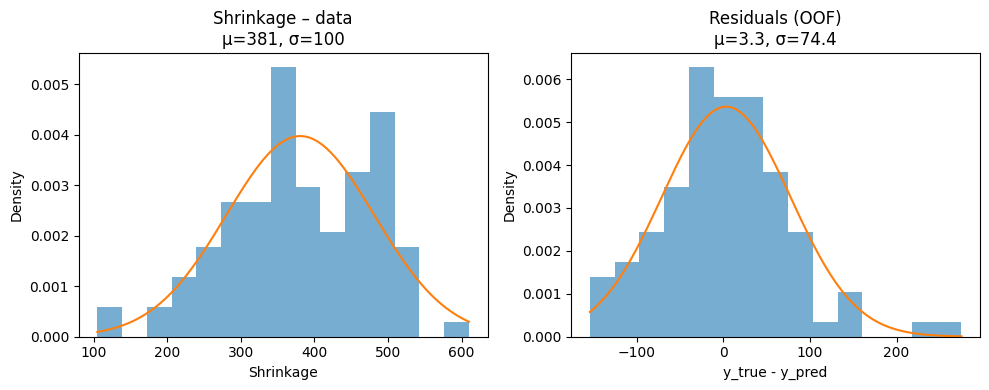


[INFO] Permutation importance (full-data fit, original units)
[INFO] Top 10 influential inputs (permutation):
   Combined aggregate passing at #4 Sieve: 35.77%
   Curing Days: 32.13%
   Fine aggregate amount (lb): 18.61%
   Combined aggregate passing at #50 Sieve: 5.71%
   WRA amount (gm): 3.49%
   Resitivity: 1.83%
   Unit Weight (lb/ft3): 1.73%
   Combined aggregate passing at #16 Sieve: 0.48%
   SAM Number: 0.26%
   Fly ash amount (lb): 0.00%


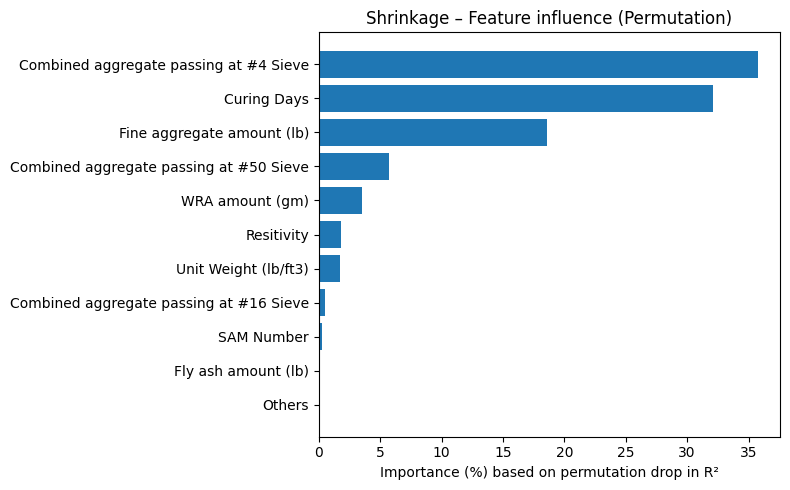


Done. Outputs saved in: /content/gpr_shrinkage


In [5]:
# ========================== Colab: GPR for SHRINKAGE only (with log1p transform) ==========================
# - Upload CSV/XLSX
# - Auto-detect header row
# - Exclude "Compressive Strength" and IDs from inputs
# - K-Fold (OOF) metrics in ORIGINAL units
# - Parity / Index / Distribution plots
# - Permutation-importance bar chart (top-10 + Others)
# =========================================================================================================

# --- setup ---
!pip -q install openpyxl

import os, math, warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from io import BytesIO
from google.colab import files

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ConstantKernel as C
from sklearn.preprocessing import StandardScaler as TargetScaler
from sklearn.inspection import permutation_importance

# --- small helpers ---
def gaussian_pdf(x, mu, sigma):
    if sigma <= 0: return np.zeros_like(x)
    return (1.0 / (np.sqrt(2.0 * np.pi) * sigma)) * np.exp(-0.5 * ((x - mu) / sigma)**2)

def make_ohe_dense():
    try:
        return OneHotEncoder(handle_unknown="ignore", sparse_output=False)
    except TypeError:
        return OneHotEncoder(handle_unknown="ignore", sparse=False)

def _read_raw(buf, is_excel):
    return pd.read_excel(buf, header=None, dtype=str) if is_excel else pd.read_csv(buf, header=None, dtype=str)

def _read_with_header(buf, is_excel, header_row):
    return pd.read_excel(buf, header=header_row) if is_excel else pd.read_csv(buf, header=header_row)

def _looks_like_name(x):
    if x is None or (isinstance(x, float) and np.isnan(x)): return False
    s = str(x).strip()
    return bool(s) and not s.lower().startswith("unnamed")

def _score_header_row(values):
    names = [v for v in values if _looks_like_name(v)]
    score = len(names)
    text = " ".join([str(v) for v in values if isinstance(v, str)])
    for k in ["Mix ID","Curing","Cement","aggregate","Slump","Compressive","Strength","Unit Weight","Air Content","Shrinkage"]:
        if k.lower() in text.lower(): score += 2
    return score

def detect_header_row(raw_df, search_limit=30):
    best_idx, best_score = None, -1
    nrows = min(search_limit, len(raw_df))
    for r in range(nrows):
        sc = _score_header_row(raw_df.iloc[r, :].tolist())
        if sc > best_score: best_idx, best_score = r, sc
    return best_idx, best_score

def clean_frame(df):
    df = df.dropna(axis=1, how="all").dropna(axis=0, how="all")
    df.columns = [str(c).strip() for c in df.columns]
    if df.columns.duplicated().any():
        counts, new_cols = {}, []
        for c in df.columns:
            if c not in counts:
                counts[c] = 0; new_cols.append(c)
            else:
                counts[c] += 1; new_cols.append(f"{c}_{counts[c]}")
        df.columns = new_cols
    return df

def forward_transform_y(y):
    return np.log1p(np.clip(y, a_min=0, a_max=None))

def inverse_transform_y(y_trans):
    return np.expm1(y_trans)

# --- upload file ---
print("Upload your dataset (.csv or .xlsx)…")
uploaded = files.upload()
assert len(uploaded) == 1, "Upload exactly one file."
fname = list(uploaded.keys())[0]
is_excel = fname.lower().endswith((".xlsx", ".xls"))
buf = BytesIO(uploaded[fname])

raw = _read_raw(buf, is_excel)
hdr, score = detect_header_row(raw, search_limit=30)
print(f"[INFO] Header row: {hdr} (score={score})")

buf.seek(0)
df = _read_with_header(buf, is_excel, hdr)
df = clean_frame(df)
print("[INFO] Columns:", df.columns.tolist())

# ============================ CONFIG ============================
TARGET_COL = "Shrinkage"            # <- exact column name for shrinkage in your file
K_FOLDS    = 5
RANDOM_SEED= 42
N_RESTARTS = 5
non_input_extras = {"Compressive Strength", "Mix ID", "ID", "Sample", "Sample ID"}
out_dir = "/content/gpr_shrinkage"
os.makedirs(out_dir, exist_ok=True)
# ===============================================================

if TARGET_COL not in df.columns:
    # try to find close match
    cand = [c for c in df.columns if "shrink" in c.lower()]
    assert len(cand)>0, f"Column '{TARGET_COL}' not found and no 'shrink*' alternative detected."
    TARGET_COL = cand[0]
    print(f"[INFO] Using '{TARGET_COL}' as shrinkage column")

non_input_cols = {TARGET_COL} | non_input_extras
X_cols = [c for c in df.columns if c not in non_input_cols]

df_t = df.copy()
df_t[TARGET_COL] = pd.to_numeric(df_t[TARGET_COL], errors="coerce")
before = len(df_t)
df_t = df_t.dropna(subset=[TARGET_COL]).copy()
if len(df_t) < before:
    print(f"[WARN] Dropped {before - len(df_t)} rows with non-numeric {TARGET_COL}")

X_all = df_t[X_cols]
y_all = df_t[TARGET_COL].values
n = len(df_t)
print(f"[INFO] Samples: {n} | Features: {len(X_cols)}")
print("[INFO] Applying log1p transform for Shrinkage (train) and expm1 for reporting.")

y_oof = np.full(n, np.nan)
sigma_oof = np.full(n, np.nan)

kf = KFold(n_splits=K_FOLDS, shuffle=True, random_state=RANDOM_SEED)

for fold, (tr_idx, va_idx) in enumerate(kf.split(X_all), start=1):
    print(f"\n[INFO] Fold {fold}/{K_FOLDS} – train={len(tr_idx)} val={len(va_idx)}")

    X_tr, X_va = X_all.iloc[tr_idx], X_all.iloc[va_idx]
    y_tr_raw, y_va_raw = y_all[tr_idx], y_all[va_idx]

    y_tr = forward_transform_y(y_tr_raw)

    num_feats = X_tr.select_dtypes(include=[np.number]).columns.tolist()
    cat_feats = [c for c in X_tr.columns if c not in num_feats]

    num_pipe = Pipeline([("imputer", SimpleImputer(strategy="median")),
                         ("scaler", StandardScaler())])
    cat_pipe = Pipeline([("imputer", SimpleImputer(strategy="most_frequent")),
                         ("onehot", make_ohe_dense())])

    pre = ColumnTransformer(
        [("num", num_pipe, num_feats),
         ("cat", cat_pipe, cat_feats)],
        remainder="drop"
    )

    Z_tr = pre.fit_transform(X_tr)
    Z_va = pre.transform(X_va)

    y_scaler = TargetScaler()
    y_tr_scaled = y_scaler.fit_transform(y_tr.reshape(-1,1)).ravel()

    n_features = Z_tr.shape[1]
    kernel = (C(1.0, (1e-2, 1e2)) *
              RBF(length_scale=np.ones(n_features), length_scale_bounds=(1e-2, 1e2))
              + WhiteKernel(1e-2, (1e-5, 1e0)))

    gpr = GaussianProcessRegressor(
        kernel=kernel,
        alpha=0.0,
        normalize_y=False,
        n_restarts_optimizer=N_RESTARTS,
        random_state=RANDOM_SEED + fold
    )
    gpr.fit(Z_tr, y_tr_scaled)
    print("[INFO]  Kernel:", gpr.kernel_)

    y_va_scaled_pred, y_va_std_scaled = gpr.predict(Z_va, return_std=True)
    y_va_pred_trans = y_scaler.inverse_transform(y_va_scaled_pred.reshape(-1,1)).ravel()
    y_va_pred = inverse_transform_y(y_va_pred_trans)

    std_trans = y_va_std_scaled * float(y_scaler.scale_[0])
    dy_dz = 1.0 + np.clip(y_va_pred, a_min=0, a_max=None)  # derivative of expm1
    sigma_va = std_trans * dy_dz

    y_oof[va_idx] = y_va_pred
    sigma_oof[va_idx] = sigma_va

# --- OOF metrics in ORIGINAL units ---
R2   = r2_score(y_all, y_oof)
RMSE = math.sqrt(mean_squared_error(y_all, y_oof))
MAE  = mean_absolute_error(y_all, y_oof)
mean_sigma = float(np.nanmean(sigma_oof))

print("\n=== SHRINKAGE – OOF Metrics (GPR, log-model) ===")
print(f"R²   : {R2:.4f}")
print(f"RMSE : {RMSE:.6f}")
print(f"MAE  : {MAE:.6f}")
print(f"Mean predictive σ (OOF): {mean_sigma:.6f}")

# --- plots ---
plt.figure(figsize=(6,6))
mn = float(np.nanmin([y_all.min(), y_oof.min()]))
mx = float(np.nanmax([y_all.max(), y_oof.max()]))
plt.scatter(y_all, y_oof, s=40, alpha=0.75, label="OOF")
plt.plot([mn, mx], [mn, mx], 'k--', label="Ideal: y = x")
plt.xlabel("Shrinkage (exp)")
plt.ylabel("Shrinkage (pred)")
plt.title(f"Shrinkage – Parity (log-model)\nR²={R2:.3f}, RMSE={RMSE:.3g}")
plt.legend(); plt.tight_layout()
plt.savefig(os.path.join(out_dir, "shrinkage_parity.png"), dpi=150)
plt.show()

plt.figure(figsize=(9,4))
idx = np.arange(n)
plt.plot(idx, y_all, "o-", label="Experimental")
plt.plot(idx, y_oof, "s--", label="Predicted (OOF)")
plt.xlabel("Sample index"); plt.ylabel("Shrinkage")
plt.title("Shrinkage – Experimental vs Predicted (OOF, log-model)")
plt.legend(); plt.tight_layout()
plt.savefig(os.path.join(out_dir, "shrinkage_index.png"), dpi=150)
plt.show()

errors = y_all - y_oof
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.hist(y_all, bins=15, density=True, alpha=0.6)
mu_y, std_y = np.nanmean(y_all), np.nanstd(y_all, ddof=1)
xs = np.linspace(np.nanmin(y_all), np.nanmax(y_all), 200)
plt.plot(xs, gaussian_pdf(xs, mu_y, std_y))
plt.title(f"Shrinkage – data\nμ={mu_y:.3g}, σ={std_y:.3g}")
plt.xlabel("Shrinkage"); plt.ylabel("Density")

plt.subplot(1,2,2)
plt.hist(errors, bins=15, density=True, alpha=0.6)
mu_e, std_e = np.nanmean(errors), np.nanstd(errors, ddof=1)
xs_e = np.linspace(np.nanmin(errors), np.nanmax(errors), 200)
plt.plot(xs_e, gaussian_pdf(xs_e, mu_e, std_e))
plt.title(f"Residuals (OOF)\nμ={mu_e:.3g}, σ={std_e:.3g}")
plt.xlabel("y_true - y_pred"); plt.ylabel("Density")
plt.tight_layout()
plt.savefig(os.path.join(out_dir, "shrinkage_normals.png"), dpi=150)
plt.show()

# --- permutation importance on FULL DATA (in original units) ---
print("\n[INFO] Permutation importance (full-data fit, original units)")

num_feats_all = X_all.select_dtypes(include=[np.number]).columns.tolist()
cat_feats_all = [c for c in X_all.columns if c not in num_feats_all]

num_pipe_all = Pipeline([("imputer", SimpleImputer(strategy="median")),
                         ("scaler", StandardScaler())])
cat_pipe_all = Pipeline([("imputer", SimpleImputer(strategy="most_frequent")),
                         ("onehot", make_ohe_dense())])

pre_all = ColumnTransformer(
    [("num", num_pipe_all, num_feats_all),
     ("cat", cat_pipe_all, cat_feats_all)],
    remainder="drop"
)

Z_all = pre_all.fit_transform(X_all)

y_all_trans = forward_transform_y(y_all)
y_scaler_all = TargetScaler()
y_all_trans_scaled = y_scaler_all.fit_transform(y_all_trans.reshape(-1,1)).ravel()

n_features_all = Z_all.shape[1]
kernel_all = (C(1.0, (1e-2, 1e2)) *
              RBF(length_scale=np.ones(n_features_all), length_scale_bounds=(1e-2, 1e2))
              + WhiteKernel(1e-2, (1e-5, 1e0)))

gpr_all = GaussianProcessRegressor(
    kernel=kernel_all,
    alpha=0.0,
    normalize_y=False,
    n_restarts_optimizer=N_RESTARTS,
    random_state=RANDOM_SEED
).fit(Z_all, y_all_trans_scaled)

class GPRWrapper:
    def __init__(self, gpr, y_scaler):
        self.gpr = gpr; self.y_scaler = y_scaler
    def fit(self, X, y): return self
    def predict(self, X):
        y_scaled = self.gpr.predict(X)
        y_trans = self.y_scaler.inverse_transform(y_scaled.reshape(-1,1)).ravel()
        return inverse_transform_y(y_trans)

perm = permutation_importance(
    GPRWrapper(gpr_all, y_scaler_all), Z_all, y_all,
    n_repeats=20, random_state=RANDOM_SEED, scoring="r2"
)

imp = np.maximum(perm.importances_mean, 0)
if imp.sum() == 0:
    print("[WARN] All permutation importances are zero. Skipping bar chart.")
else:
    imp_norm = imp / imp.sum()

    feat_names = []
    try:
        for name, trans, cols in pre_all.transformers_:
            if name == "num":
                feat_names += list(cols)
            elif name == "cat":
                cat_trans = pre_all.named_transformers_["cat"]
                if hasattr(cat_trans, "get_feature_names_out"):
                    cat_names = cat_trans.get_feature_names_out(cols)
                    feat_names += list(cat_names)
                else:
                    feat_names += list(cols)
    except Exception:
        feat_names = list(X_all.columns)

    feat_names = np.array(feat_names)
    order = np.argsort(imp_norm)[::-1]
    feat_sorted = feat_names[order]
    imp_sorted = imp_norm[order]

    print("[INFO] Top 10 influential inputs (permutation):")
    for i in range(min(10, len(feat_sorted))):
        print(f"   {feat_sorted[i]}: {imp_sorted[i]*100:.2f}%")

    top_n = min(10, len(feat_sorted))
    feat_top = list(feat_sorted[:top_n])
    imp_top = list(imp_sorted[:top_n])
    if len(feat_sorted) > top_n:
        others = 1.0 - sum(imp_top)
        if others > 0:
            feat_top.append("Others")
            imp_top.append(others)

    plt.figure(figsize=(8,5))
    y_pos = np.arange(len(feat_top))
    plt.barh(y_pos, [v*100 for v in imp_top], align='center')
    plt.yticks(y_pos, feat_top)
    plt.gca().invert_yaxis()
    plt.xlabel("Importance (%) based on permutation drop in R²")
    plt.title("Shrinkage – Feature influence (Permutation)")
    plt.tight_layout()
    plt.savefig(os.path.join(out_dir, "shrinkage_feature_importance_bar.png"), dpi=150)
    plt.show()

print(f"\nDone. Outputs saved in: {out_dir}")


Upload your dataset (.csv or .xlsx)…


Saving ML-dataset.xlsx.csv to ML-dataset.xlsx (4).csv
[INFO] Auto-detected header row: 4 (score=49)
[INFO] Columns detected:
['Mix ID', 'Curing Days', 'Cement amount (lb)', 'Fly ash amount (lb)', 'Coarse aggregate amount (lb)', 'Intermediate aggregate amount (lb)', 'Fine aggregate amount (lb)', 'Water amount (lb)', 'WRA amount (gm)', 'AE amount (gm)', 'Combined aggregate passing at 1" Sieve', 'Combined aggregate passing at 1/2" Sieve', 'Combined aggregate passing at #4 Sieve', 'Combined aggregate passing at #16 Sieve', 'Combined aggregate passing at #50 Sieve', 'Combined aggregate passing at #200 Sieve', 'Workability factor', 'Coarseness factor', 'Slump (inch)', 'Unit Weight (lb/ft3)', 'Air Content (%)', 'Compressive Strength', 'SAM Number', 'Shrinkage', 'Resitivity']

=== Random Forest – K-Fold (OOF) for target: SAM Number ===
[INFO] Samples: 200 | Input features: 20

[INFO] Fold 1/5 – train=160 val=40

[INFO] Fold 2/5 – train=160 val=40

[INFO] Fold 3/5 – train=160 val=40

[INFO] Fol

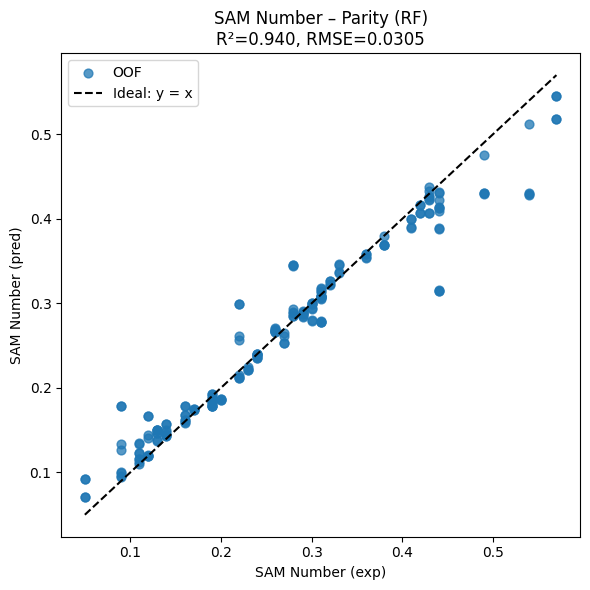

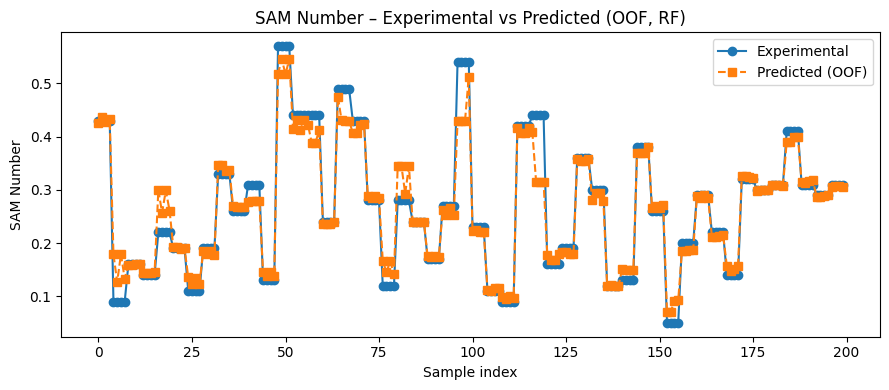

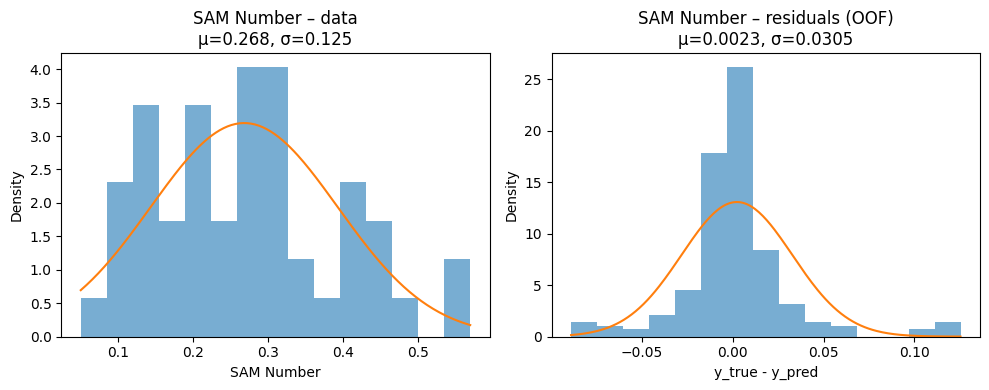


[INFO] Permutation importance (full-data fit) for: SAM Number
[INFO] Top 10 influential inputs for SAM Number (permutation):
   Air Content (%): 23.70%
   Intermediate aggregate amount (lb): 19.16%
   Combined aggregate passing at 1/2" Sieve: 8.35%
   Coarse aggregate amount (lb): 7.93%
   Workability factor: 6.14%
   Unit Weight (lb/ft3): 4.38%
   Cement amount (lb): 4.03%
   Water amount (lb): 3.98%
   Coarseness factor: 3.85%
   Fine aggregate amount (lb): 3.55%


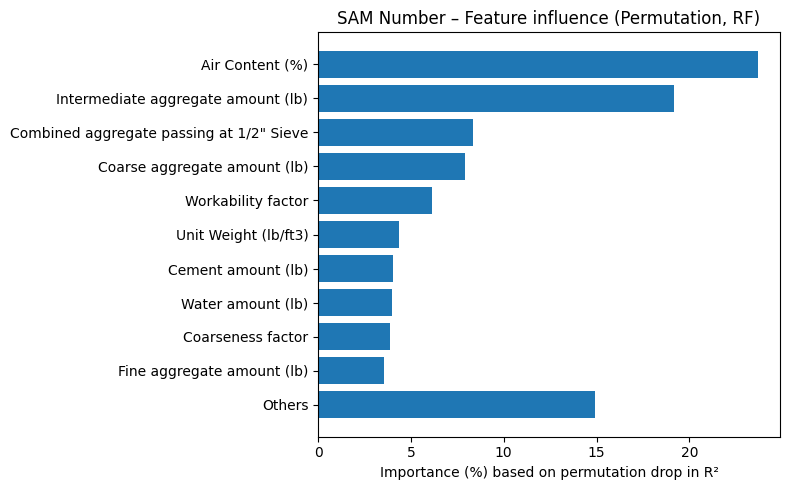

[INFO] Saved bar chart: /content/rf_all_outputs/rf_SAM_Number_feature_importance_bar.png

=== Random Forest – K-Fold (OOF) for target: Shrinkage ===
[WARN] Dropped 100 rows with non-numeric Shrinkage
[INFO] Samples: 100 | Input features: 20
[INFO] Applying log1p transform for Shrinkage during training; reporting in original units.

[INFO] Fold 1/5 – train=80 val=20

[INFO] Fold 2/5 – train=80 val=20

[INFO] Fold 3/5 – train=80 val=20

[INFO] Fold 4/5 – train=80 val=20

[INFO] Fold 5/5 – train=80 val=20

=== OOF Metrics (Random Forest) ===
Target: Shrinkage
R²   : 0.4451
RMSE : 74.457195
MAE  : 58.266797
Mean predictive σ (OOF, ensemble spread): 73.644180


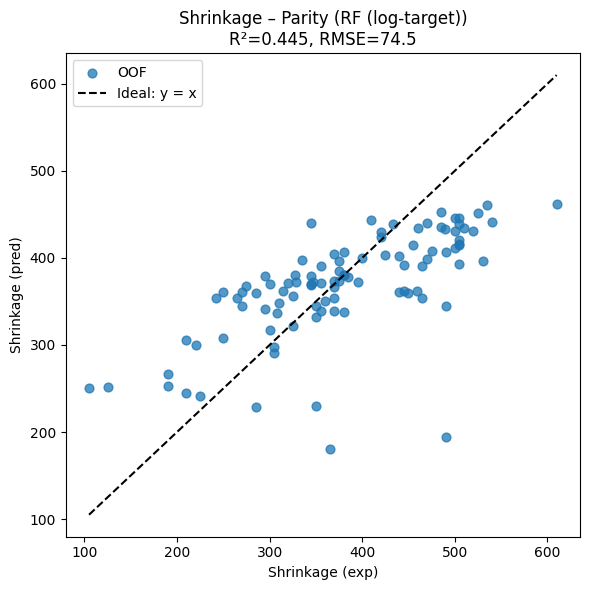

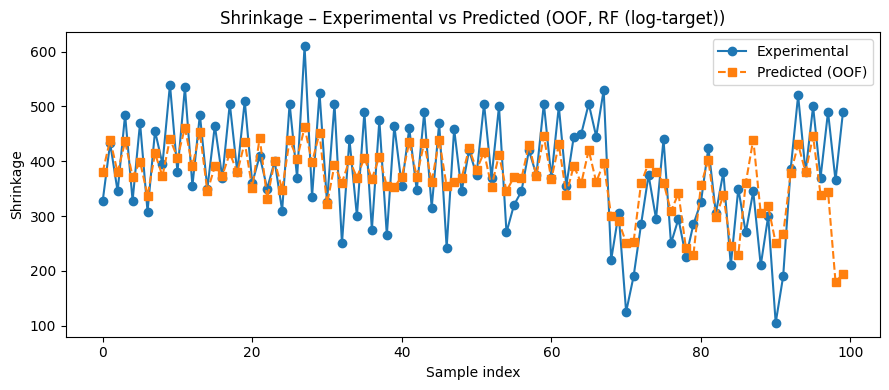

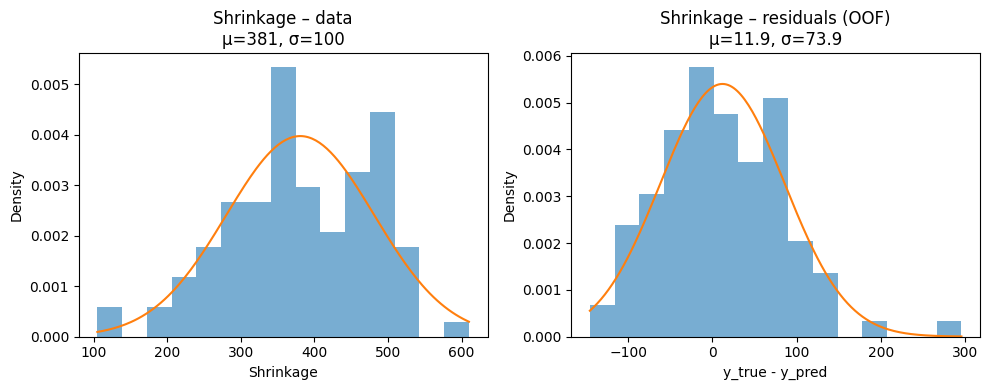


[INFO] Permutation importance (full-data fit) for: Shrinkage
[INFO] Top 10 influential inputs for Shrinkage (permutation):
   Curing Days: 51.35%
   AE amount (gm): 7.34%
   Slump (inch): 5.42%
   Water amount (lb): 4.51%
   WRA amount (gm): 4.09%
   Workability factor: 3.76%
   Air Content (%): 3.29%
   Combined aggregate passing at #50 Sieve: 2.50%
   Coarseness factor: 2.41%
   Combined aggregate passing at #4 Sieve: 2.18%


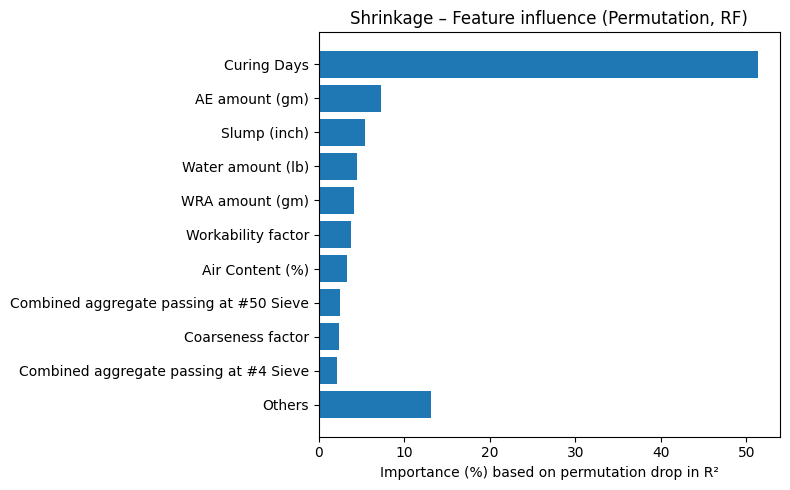

[INFO] Saved bar chart: /content/rf_all_outputs/rf_Shrinkage_feature_importance_bar.png

=== Random Forest – K-Fold (OOF) for target: Resitivity ===
[WARN] Dropped 50 rows with non-numeric Resitivity
[INFO] Samples: 150 | Input features: 20

[INFO] Fold 1/5 – train=120 val=30

[INFO] Fold 2/5 – train=120 val=30

[INFO] Fold 3/5 – train=120 val=30

[INFO] Fold 4/5 – train=120 val=30

[INFO] Fold 5/5 – train=120 val=30

=== OOF Metrics (Random Forest) ===
Target: Resitivity
R²   : 0.6360
RMSE : 10.0993
MAE  : 8.3322
Mean predictive σ (OOF, ensemble spread): 11.6408


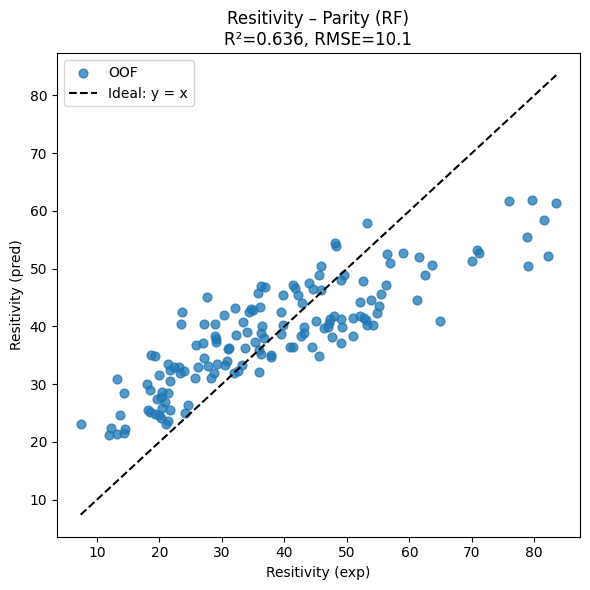

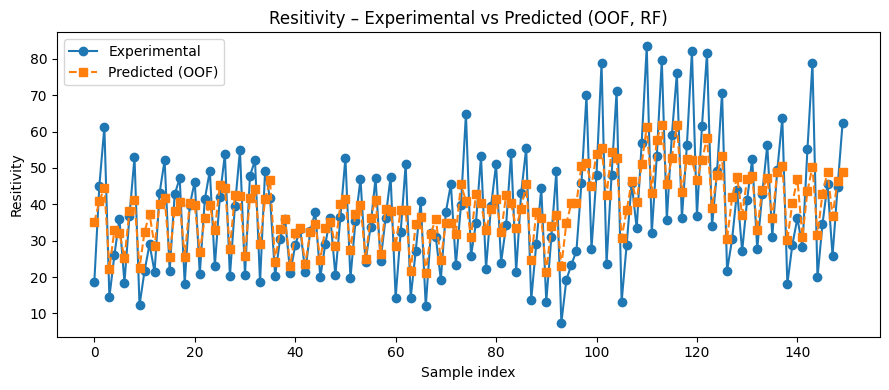

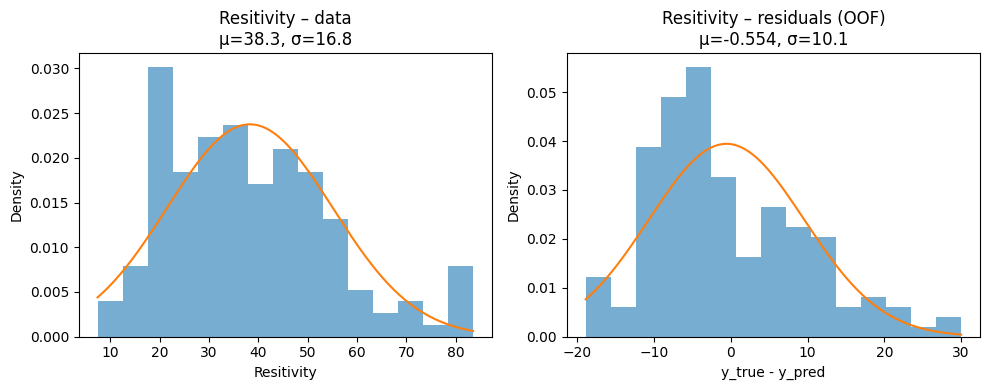


[INFO] Permutation importance (full-data fit) for: Resitivity
[INFO] Top 10 influential inputs for Resitivity (permutation):
   Curing Days: 70.30%
   Fine aggregate amount (lb): 5.61%
   Slump (inch): 4.95%
   Combined aggregate passing at #50 Sieve: 3.03%
   Combined aggregate passing at #4 Sieve: 2.04%
   WRA amount (gm): 1.69%
   Intermediate aggregate amount (lb): 1.65%
   Unit Weight (lb/ft3): 1.39%
   Combined aggregate passing at #200 Sieve: 1.21%
   Combined aggregate passing at 1/2" Sieve: 1.00%


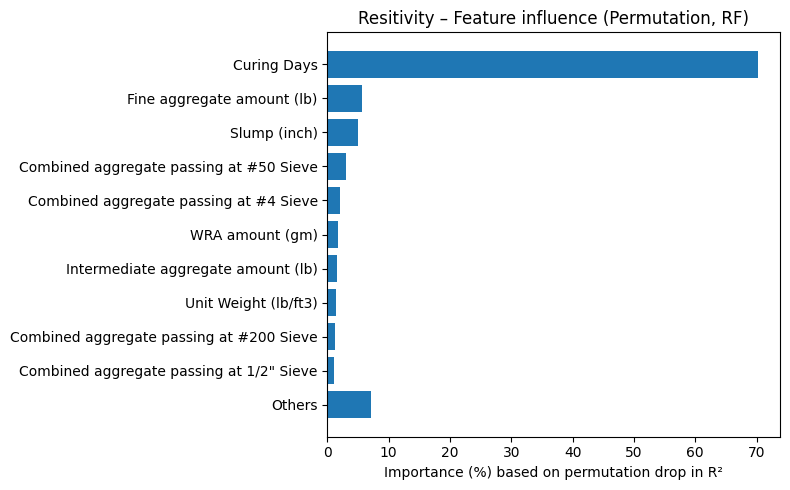

[INFO] Saved bar chart: /content/rf_all_outputs/rf_Resitivity_feature_importance_bar.png

All targets evaluated with Random Forest (K-Fold OOF) ✔


Target        R2       RMSE        MAE  MeanSigma
0  SAM Number  0.939911   0.030537   0.017844   0.043583
1   Shrinkage  0.445127  74.457195  58.266797  73.644180
2  Resitivity  0.635967  10.099314   8.332229  11.640792

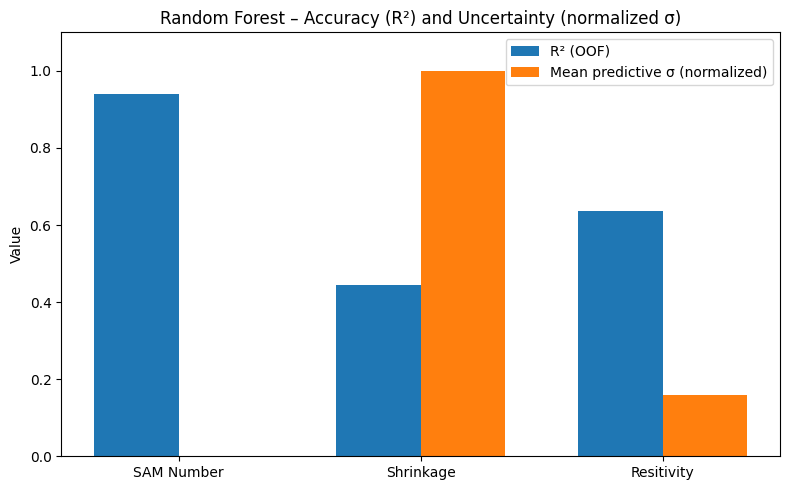

[INFO] Saved summary chart: /content/rf_all_outputs/rf_summary_R2_uncertainty.png

Done. All outputs saved under: /content/rf_all_outputs


In [7]:
# ================== Colab: Random Forest for ALL OUTPUTS (SAM, Shrinkage, Resitivity) ==================
# - Upload CSV/XLSX (auto header detection)
# - Inputs exclude: all targets + "Compressive Strength" + ID-like columns
# - K-Fold (OOF) metrics in ORIGINAL units for each target
# - Target-specific transform: Shrinkage uses log1p/expm1; others untransformed
# - Parity / Index / Distribution plots per target
# - Uncertainty proxy from RF ensemble spread (mapped back to original units)
# - Permutation-importance bar chart (top-10 + Others) per target
# - Summary bar chart: R² (OOF) + normalized uncertainty across targets
# ======================================================================================================

# --- setup ---
!pip -q install openpyxl

import os, math, warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from io import BytesIO
from google.colab import files

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestRegressor

# --- small helpers ---
def gaussian_pdf(x, mu, sigma):
    if sigma <= 0: return np.zeros_like(x)
    return (1.0 / (np.sqrt(2.0 * np.pi) * sigma)) * np.exp(-0.5 * ((x - mu) / sigma)**2)

def make_ohe_dense():
    try:
        return OneHotEncoder(handle_unknown="ignore", sparse_output=False)
    except TypeError:
        return OneHotEncoder(handle_unknown="ignore", sparse=False)

def _read_raw(buf, is_excel):
    return pd.read_excel(buf, header=None, dtype=str) if is_excel else pd.read_csv(buf, header=None, dtype=str)

def _read_with_header(buf, is_excel, header_row):
    return pd.read_excel(buf, header=header_row) if is_excel else pd.read_csv(buf, header=header_row)

def _looks_like_name(x):
    if x is None or (isinstance(x, float) and np.isnan(x)): return False
    s = str(x).strip()
    return bool(s) and not s.lower().startswith("unnamed")

def _score_header_row(values):
    names = [v for v in values if _looks_like_name(v)]
    score = len(names)
    text = " ".join([str(v) for v in values if isinstance(v, str)])
    for k in ["Mix ID","Curing","Cement","aggregate","Slump",
              "Compressive","Strength","Unit Weight","Air Content",
              "SAM","Shrinkage","Resitivity","Resistivity"]:
        if k.lower() in text.lower(): score += 2
    return score

def detect_header_row(raw_df, search_limit=30):
    best_idx, best_score = None, -1
    nrows = min(search_limit, len(raw_df))
    for r in range(nrows):
        sc = _score_header_row(raw_df.iloc[r, :].tolist())
        if sc > best_score: best_idx, best_score = r, sc
    return best_idx, best_score

def clean_frame(df):
    df = df.dropna(axis=1, how="all").dropna(axis=0, how="all")
    df.columns = [str(c).strip() for c in df.columns]
    if df.columns.duplicated().any():
        counts, new_cols = {}, []
        for c in df.columns:
            if c not in counts:
                counts[c] = 0; new_cols.append(c)
            else:
                counts[c] += 1; new_cols.append(f"{c}_{counts[c]}")
        df.columns = new_cols
    return df

def is_shrinkage(name: str) -> bool:
    return name.strip().lower().startswith("shrink")

def forward_transform_y(y: np.ndarray, tname: str) -> np.ndarray:
    """Transform target for training: Shrinkage -> log1p, others -> identity."""
    if is_shrinkage(tname):
        return np.log1p(np.clip(y, a_min=0, a_max=None))
    return y

def inverse_transform_y(y_trans: np.ndarray, tname: str) -> np.ndarray:
    """Inverse transform to original units."""
    if is_shrinkage(tname):
        return np.expm1(y_trans)
    return y_trans

# ---------------------- Upload dataset ----------------------
print("Upload your dataset (.csv or .xlsx)…")
uploaded = files.upload()
assert len(uploaded) == 1, "Upload exactly one file."
fname = list(uploaded.keys())[0]
is_excel = fname.lower().endswith((".xlsx", ".xls"))
buf = BytesIO(uploaded[fname])

raw = _read_raw(buf, is_excel)
hdr, score = detect_header_row(raw, search_limit=30)
print(f"[INFO] Auto-detected header row: {hdr} (score={score})")

buf.seek(0)
df = _read_with_header(buf, is_excel, hdr)
df = clean_frame(df)
print("[INFO] Columns detected:")
print(df.columns.tolist())

# ---------------------- CONFIG ----------------------
TARGETS = ["SAM Number", "Shrinkage", "Resitivity"]  # adjust names to match your file
K_FOLDS = 5
RANDOM_SEED = 42
RF_PARAMS = dict(
    n_estimators=700,
    max_depth=None,
    min_samples_leaf=2,
    max_features="sqrt",
    bootstrap=True,
    n_jobs=-1,
    random_state=RANDOM_SEED
)
# exclude these from inputs
non_input_extras = {"Compressive Strength", "Mix ID", "ID", "Sample", "Sample ID"}
out_dir = "/content/rf_all_outputs"
os.makedirs(out_dir, exist_ok=True)

# summary storage
summary = []

# ---------------------- Loop over targets ----------------------
for TARGET_COL in TARGETS:
    print("\n" + "="*100)
    print(f"=== Random Forest – K-Fold (OOF) for target: {TARGET_COL} ===")

    # target presence / fuzzy fallback for resistivity spelling
    if TARGET_COL not in df.columns:
        if TARGET_COL.lower().startswith("resit"):
            cand = [c for c in df.columns if "resist" in c.lower()]
            assert len(cand) > 0, f"'{TARGET_COL}' not found and no resist* alternative detected."
            TARGET_COL = cand[0]
            print(f"[INFO] Using '{TARGET_COL}' as resistivity column")
        else:
            raise ValueError(f"Target '{TARGET_COL}' not found in columns: {df.columns.tolist()}")

    # Build inputs: exclude all targets + extras from inputs
    non_input_cols = set(TARGETS) | non_input_extras
    X_cols = [c for c in df.columns if c not in non_input_cols]

    # Numeric target series
    df_t = df.copy()
    df_t[TARGET_COL] = pd.to_numeric(df_t[TARGET_COL], errors="coerce")
    before = len(df_t)
    df_t = df_t.dropna(subset=[TARGET_COL]).copy()
    if len(df_t) < before:
        print(f"[WARN] Dropped {before - len(df_t)} rows with non-numeric {TARGET_COL}")

    X_all = df_t[X_cols]
    y_all = df_t[TARGET_COL].values
    n = len(df_t)
    print(f"[INFO] Samples: {n} | Input features: {len(X_cols)}")
    if is_shrinkage(TARGET_COL):
        print("[INFO] Applying log1p transform for Shrinkage during training; reporting in original units.")

    # OOF holders
    y_oof = np.full(n, np.nan)
    sigma_oof = np.full(n, np.nan)  # RF ensemble spread proxy

    kf = KFold(n_splits=K_FOLDS, shuffle=True, random_state=RANDOM_SEED)

    for fold, (tr_idx, va_idx) in enumerate(kf.split(X_all), start=1):
        print(f"\n[INFO] Fold {fold}/{K_FOLDS} – train={len(tr_idx)} val={len(va_idx)}")

        X_tr, X_va = X_all.iloc[tr_idx], X_all.iloc[va_idx]
        y_tr_raw, y_va_raw = y_all[tr_idx], y_all[va_idx]

        # transform target for training
        y_tr = forward_transform_y(y_tr_raw, TARGET_COL)

        # Preprocessing – trees don't need scaling, but we need imputation + OHE
        num_feats = X_tr.select_dtypes(include=[np.number]).columns.tolist()
        cat_feats = [c for c in X_tr.columns if c not in num_feats]

        num_pipe = Pipeline([("imputer", SimpleImputer(strategy="median"))])
        cat_pipe = Pipeline([("imputer", SimpleImputer(strategy="most_frequent")),
                             ("onehot", make_ohe_dense())])

        pre = ColumnTransformer(
            [("num", num_pipe, num_feats),
             ("cat", cat_pipe, cat_feats)],
            remainder="drop"
        )

        Z_tr = pre.fit_transform(X_tr)
        Z_va = pre.transform(X_va)

        # Fit RF on transformed targets
        rf = RandomForestRegressor(**RF_PARAMS)
        rf.fit(Z_tr, y_tr)

        # Predictions in transformed space
        y_va_pred_trans = rf.predict(Z_va)

        # Per-tree predictions -> spread (uncertainty proxy) in transformed space
        all_tree_preds_trans = np.vstack([est.predict(Z_va) for est in rf.estimators_])
        std_trans = np.std(all_tree_preds_trans, axis=0, ddof=1)

        # Inverse transform to original units
        y_va_pred = inverse_transform_y(y_va_pred_trans, TARGET_COL)

        # Map std to original units (delta method)
        if is_shrinkage(TARGET_COL):
            # y = expm1(z) ⇒ dy/dz ≈ 1 + y
            dy_dz = 1.0 + np.clip(y_va_pred, a_min=0, a_max=None)
            sigma_va = std_trans * dy_dz
        else:
            # identity target ⇒ std stays as-is
            sigma_va = std_trans

        # Store OOF
        y_oof[va_idx] = y_va_pred
        sigma_oof[va_idx] = sigma_va

    # ------------- OOF metrics in ORIGINAL units -------------
    R2   = r2_score(y_all, y_oof)
    RMSE = math.sqrt(mean_squared_error(y_all, y_oof))
    MAE  = mean_absolute_error(y_all, y_oof)
    mean_sigma = float(np.nanmean(sigma_oof))

    print("\n=== OOF Metrics (Random Forest) ===")
    print(f"Target: {TARGET_COL}")
    print(f"R²   : {R2:.4f}")
    print(f"RMSE : {RMSE:.6f}" if is_shrinkage(TARGET_COL) else f"RMSE : {RMSE:.4f}")
    print(f"MAE  : {MAE:.6f}" if is_shrinkage(TARGET_COL) else f"MAE  : {MAE:.4f}")
    print(f"Mean predictive σ (OOF, ensemble spread): {mean_sigma:.6f}" if is_shrinkage(TARGET_COL) else f"Mean predictive σ (OOF, ensemble spread): {mean_sigma:.4f}")

    summary.append({
        "Target": TARGET_COL,
        "R2": R2,
        "RMSE": RMSE,
        "MAE": MAE,
        "MeanSigma": mean_sigma
    })

    # ----------------- Plots (per target) -----------------
    # Parity
    plt.figure(figsize=(6,6))
    mn = float(np.nanmin([y_all.min(), y_oof.min()]))
    mx = float(np.nanmax([y_all.max(), y_oof.max()]))
    plt.scatter(y_all, y_oof, s=40, alpha=0.75, label="OOF")
    plt.plot([mn, mx], [mn, mx], 'k--', label="Ideal: y = x")
    plt.xlabel(f"{TARGET_COL} (exp)")
    plt.ylabel(f"{TARGET_COL} (pred)")
    hint = " (log-target)" if is_shrinkage(TARGET_COL) else ""
    plt.title(f"{TARGET_COL} – Parity (RF{hint})\nR²={R2:.3f}, RMSE={RMSE:.3g}")
    plt.legend(); plt.tight_layout()
    plt.savefig(os.path.join(out_dir, f"rf_{TARGET_COL.replace(' ','_')}_parity.png"), dpi=150)
    plt.show()

    # Index
    plt.figure(figsize=(9,4))
    idx = np.arange(n)
    plt.plot(idx, y_all, "o-", label="Experimental")
    plt.plot(idx, y_oof, "s--", label="Predicted (OOF)")
    plt.xlabel("Sample index"); plt.ylabel(TARGET_COL)
    plt.title(f"{TARGET_COL} – Experimental vs Predicted (OOF, RF{hint})")
    plt.legend(); plt.tight_layout()
    plt.savefig(os.path.join(out_dir, f"rf_{TARGET_COL.replace(' ','_')}_index.png"), dpi=150)
    plt.show()

    # Distributions
    errors = y_all - y_oof
    plt.figure(figsize=(10,4))
    # data
    plt.subplot(1,2,1)
    plt.hist(y_all, bins=15, density=True, alpha=0.6)
    mu_y, std_y = np.nanmean(y_all), np.nanstd(y_all, ddof=1)
    xs = np.linspace(np.nanmin(y_all), np.nanmax(y_all), 200)
    plt.plot(xs, gaussian_pdf(xs, mu_y, std_y))
    plt.title(f"{TARGET_COL} – data\nμ={mu_y:.3g}, σ={std_y:.3g}")
    plt.xlabel(TARGET_COL); plt.ylabel("Density")
    # residuals
    plt.subplot(1,2,2)
    plt.hist(errors, bins=15, density=True, alpha=0.6)
    mu_e, std_e = np.nanmean(errors), np.nanstd(errors, ddof=1)
    xs_e = np.linspace(np.nanmin(errors), np.nanmax(errors), 200)
    plt.plot(xs_e, gaussian_pdf(xs_e, mu_e, std_e))
    plt.title(f"{TARGET_COL} – residuals (OOF)\nμ={mu_e:.3g}, σ={std_e:.3g}")
    plt.xlabel("y_true - y_pred"); plt.ylabel("Density")
    plt.tight_layout()
    plt.savefig(os.path.join(out_dir, f"rf_{TARGET_COL.replace(' ','_')}_normals.png"), dpi=150)
    plt.show()

    # ----------------- Permutation importance (FULL DATA, original units) -----------------
    print(f"\n[INFO] Permutation importance (full-data fit) for: {TARGET_COL}")

    # Full-data preprocessing
    num_feats_all = X_all.select_dtypes(include=[np.number]).columns.tolist()
    cat_feats_all = [c for c in X_all.columns if c not in num_feats_all]

    num_pipe_all = Pipeline([("imputer", SimpleImputer(strategy="median"))])
    cat_pipe_all = Pipeline([("imputer", SimpleImputer(strategy="most_frequent")),
                             ("onehot", make_ohe_dense())])

    pre_all = ColumnTransformer(
        [("num", num_pipe_all, num_feats_all),
         ("cat", cat_pipe_all, cat_feats_all)],
        remainder="drop"
    )

    Z_all = pre_all.fit_transform(X_all)

    # Fit RF on full data (transformed target)
    y_all_trans = forward_transform_y(y_all, TARGET_COL)
    rf_full = RandomForestRegressor(**RF_PARAMS).fit(Z_all, y_all_trans)

    # Wrapper: predict in ORIGINAL units for permutation_importance
    class RFWrapper:
        def __init__(self, rf, tname): self.rf, self.tname = rf, tname
        def fit(self, X, y): return self
        def predict(self, X):
            y_trans = self.rf.predict(X)
            return inverse_transform_y(y_trans, self.tname)

    perm = permutation_importance(
        RFWrapper(rf_full, TARGET_COL), Z_all, y_all,
        n_repeats=20, random_state=RANDOM_SEED, scoring="r2"
    )

    imp = np.maximum(perm.importances_mean, 0)
    if imp.sum() == 0:
        print("[WARN] All permutation importances are zero. Skipping bar chart.")
    else:
        imp_norm = imp / imp.sum()

        # feature names after preprocessing
        feat_names = []
        try:
            for name, trans, cols in pre_all.transformers_:
                if name == "num":
                    feat_names += list(cols)
                elif name == "cat":
                    cat_trans = pre_all.named_transformers_["cat"]
                    if hasattr(cat_trans, "get_feature_names_out"):
                        feat_names += list(cat_trans.get_feature_names_out(cols))
                    else:
                        feat_names += list(cols)
        except Exception:
            feat_names = list(X_all.columns)

        feat_names = np.array(feat_names)
        order = np.argsort(imp_norm)[::-1]
        feat_sorted = feat_names[order]
        imp_sorted = imp_norm[order]

        print(f"[INFO] Top 10 influential inputs for {TARGET_COL} (permutation):")
        for i in range(min(10, len(feat_sorted))):
            print(f"   {feat_sorted[i]}: {imp_sorted[i]*100:.2f}%")

        # Top 10 + Others → horizontal bar
        top_n = min(10, len(feat_sorted))
        feat_top = list(feat_sorted[:top_n])
        imp_top = list(imp_sorted[:top_n])
        if len(feat_sorted) > top_n:
            others = 1.0 - sum(imp_top)
            if others > 0:
                feat_top.append("Others")
                imp_top.append(others)

        plt.figure(figsize=(8,5))
        y_pos = np.arange(len(feat_top))
        plt.barh(y_pos, [v*100 for v in imp_top], align='center')
        plt.yticks(y_pos, feat_top)
        plt.gca().invert_yaxis()
        plt.xlabel("Importance (%) based on permutation drop in R²")
        plt.title(f"{TARGET_COL} – Feature influence (Permutation, RF)")
        plt.tight_layout()
        fp = os.path.join(out_dir, f"rf_{TARGET_COL.replace(' ','_')}_feature_importance_bar.png")
        plt.savefig(fp, dpi=150)
        plt.show()
        print(f"[INFO] Saved bar chart: {fp}")

print("\nAll targets evaluated with Random Forest (K-Fold OOF) ✔")

# ---------------------- Summary bar chart ----------------------
if summary:
    res_df = pd.DataFrame(summary)
    display(res_df)

    # Normalize uncertainty for plotting side-by-side with R²
    sigma_norm = res_df["MeanSigma"] / res_df["MeanSigma"].replace(0, np.nan).max()
    sigma_norm = sigma_norm.fillna(0.0)

    x = np.arange(len(res_df))
    width = 0.35

    plt.figure(figsize=(8,5))
    plt.bar(x - width/2, res_df["R2"], width, label="R² (OOF)")
    plt.bar(x + width/2, sigma_norm, width, label="Mean predictive σ (normalized)")
    plt.xticks(x, res_df["Target"])
    plt.ylim(0, 1.1)
    plt.ylabel("Value")
    plt.title("Random Forest – Accuracy (R²) and Uncertainty (normalized σ)")
    plt.legend()
    plt.tight_layout()
    fp = os.path.join(out_dir, "rf_summary_R2_uncertainty.png")
    plt.savefig(fp, dpi=150)
    plt.show()
    print(f"[INFO] Saved summary chart: {fp}")

print(f"\nDone. All outputs saved under: {out_dir}")


Upload your dataset (.csv or .xlsx)…


Saving ML-dataset.xlsx.csv to ML-dataset.xlsx (5).csv
[INFO] Auto-detected header row: 4 (score=49)
[INFO] Columns detected:
['Mix ID', 'Curing Days', 'Cement amount (lb)', 'Fly ash amount (lb)', 'Coarse aggregate amount (lb)', 'Intermediate aggregate amount (lb)', 'Fine aggregate amount (lb)', 'Water amount (lb)', 'WRA amount (gm)', 'AE amount (gm)', 'Combined aggregate passing at 1" Sieve', 'Combined aggregate passing at 1/2" Sieve', 'Combined aggregate passing at #4 Sieve', 'Combined aggregate passing at #16 Sieve', 'Combined aggregate passing at #50 Sieve', 'Combined aggregate passing at #200 Sieve', 'Workability factor', 'Coarseness factor', 'Slump (inch)', 'Unit Weight (lb/ft3)', 'Air Content (%)', 'Compressive Strength', 'SAM Number', 'Shrinkage', 'Resitivity']

=== XGBoost – K-Fold (OOF) for target: SAM Number ===
[INFO] Samples: 200 | Input features: 20

[INFO] Fold 1/5 – train=160 val=40

[INFO] Fold 2/5 – train=160 val=40

[INFO] Fold 3/5 – train=160 val=40

[INFO] Fold 4/5 

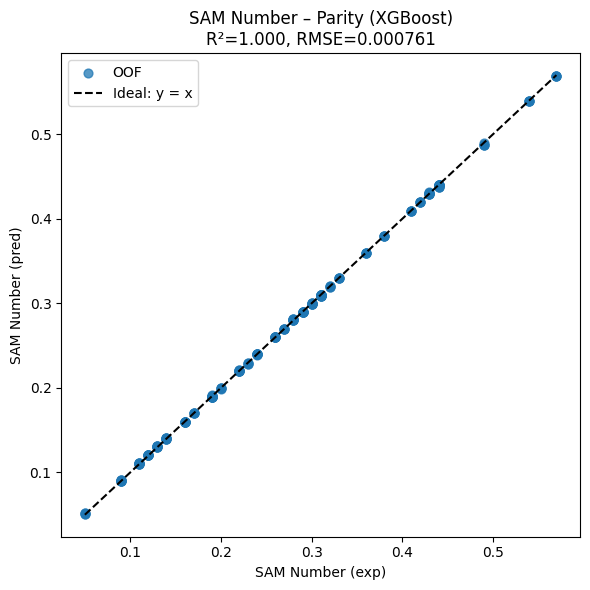

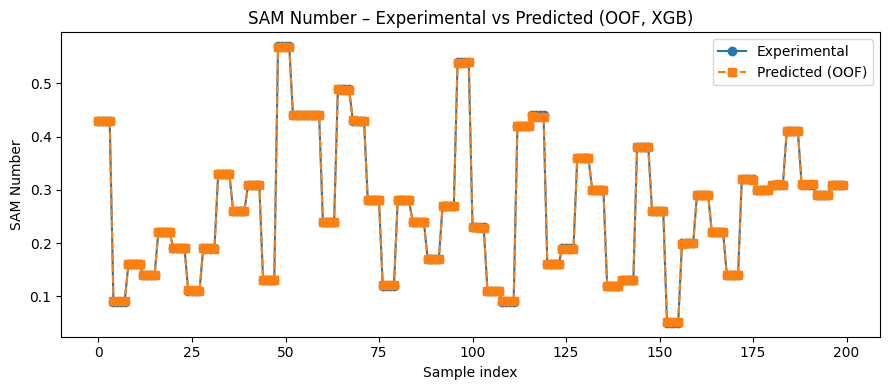

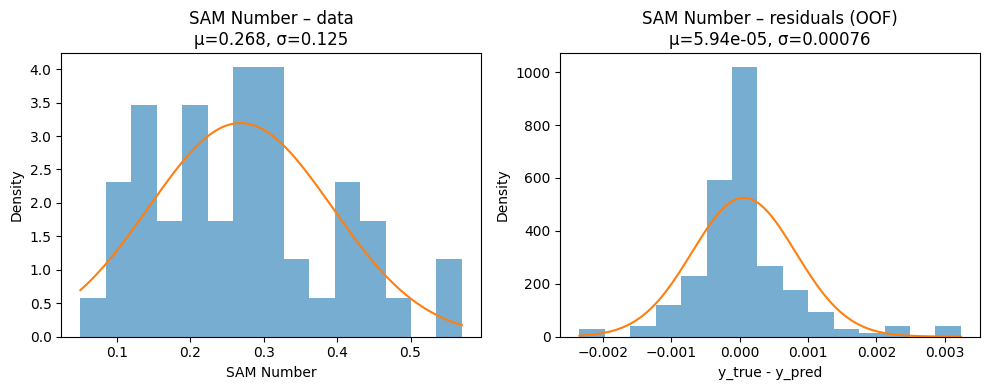


[INFO] Permutation importance (full-data fit) for: SAM Number
[INFO] Top 10 influential inputs for SAM Number (permutation):
   Intermediate aggregate amount (lb): 37.22%
   Air Content (%): 26.97%
   Workability factor: 7.17%
   Fine aggregate amount (lb): 7.06%
   Cement amount (lb): 7.05%
   Combined aggregate passing at 1/2" Sieve: 3.79%
   Combined aggregate passing at #16 Sieve: 1.94%
   Combined aggregate passing at #4 Sieve: 1.83%
   Coarse aggregate amount (lb): 1.37%
   Unit Weight (lb/ft3): 1.34%


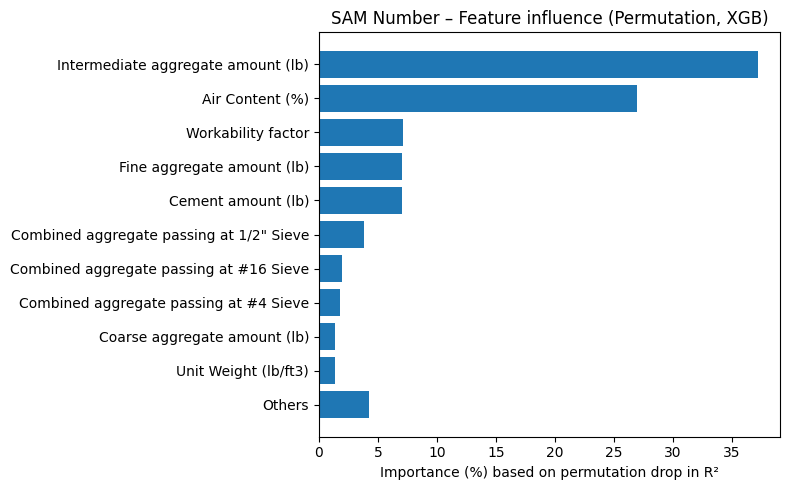

[INFO] Saved bar chart: /content/xgb_all_outputs/xgb_SAM_Number_feature_importance_bar.png

=== XGBoost – K-Fold (OOF) for target: Shrinkage ===
[WARN] Dropped 100 rows with non-numeric Shrinkage
[INFO] Samples: 100 | Input features: 20
[INFO] Using log1p transform for Shrinkage during training; reporting in original units.

[INFO] Fold 1/5 – train=80 val=20

[INFO] Fold 2/5 – train=80 val=20

[INFO] Fold 3/5 – train=80 val=20

[INFO] Fold 4/5 – train=80 val=20

[INFO] Fold 5/5 – train=80 val=20

=== OOF Metrics (XGBoost) ===
Target: Shrinkage
R²   : 0.5782
RMSE : 64.916929
MAE  : 45.157998


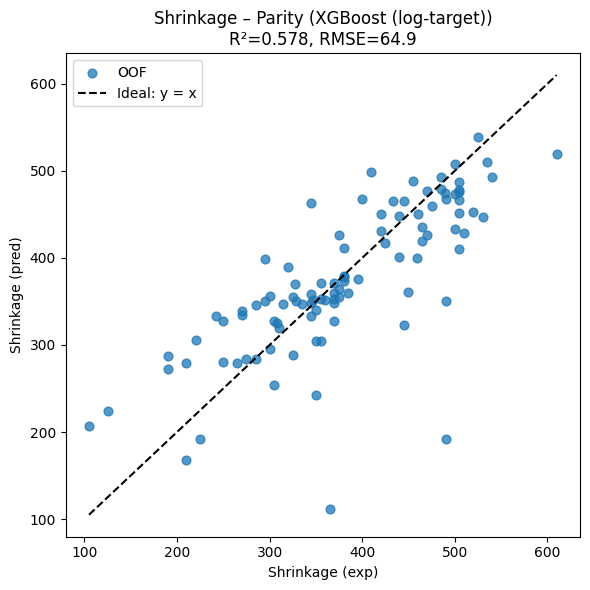

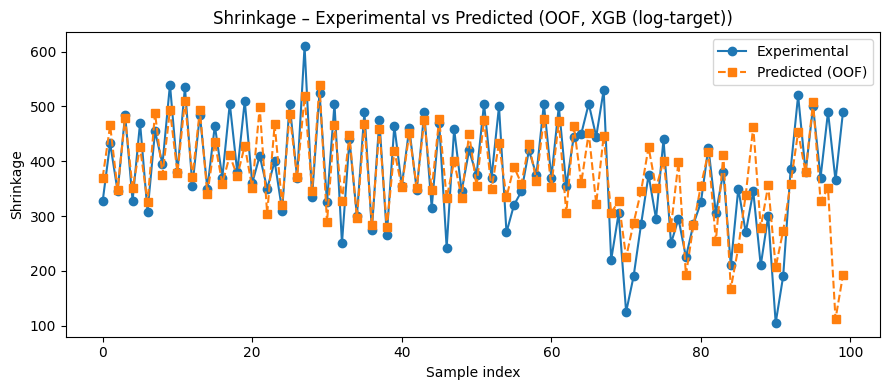

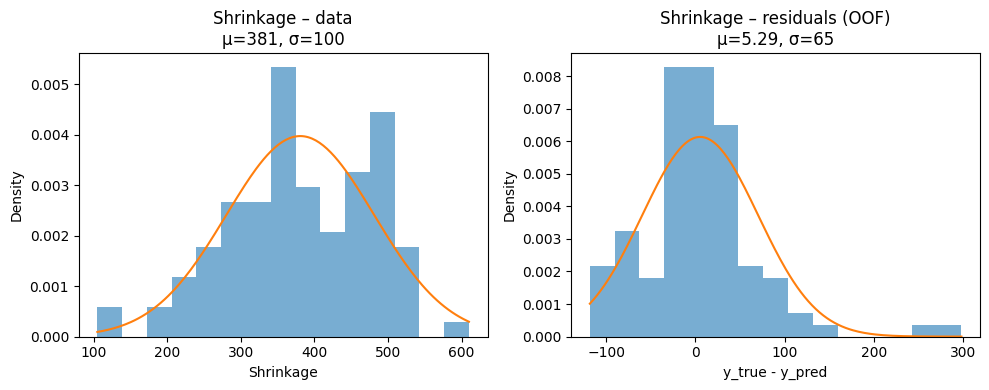


[INFO] Permutation importance (full-data fit) for: Shrinkage
[INFO] Top 10 influential inputs for Shrinkage (permutation):
   Curing Days: 62.84%
   AE amount (gm): 12.64%
   Water amount (lb): 8.17%
   Slump (inch): 2.66%
   Fine aggregate amount (lb): 2.24%
   Unit Weight (lb/ft3): 2.19%
   Coarseness factor: 1.89%
   Combined aggregate passing at #50 Sieve: 1.22%
   Combined aggregate passing at #16 Sieve: 1.18%
   Workability factor: 0.97%


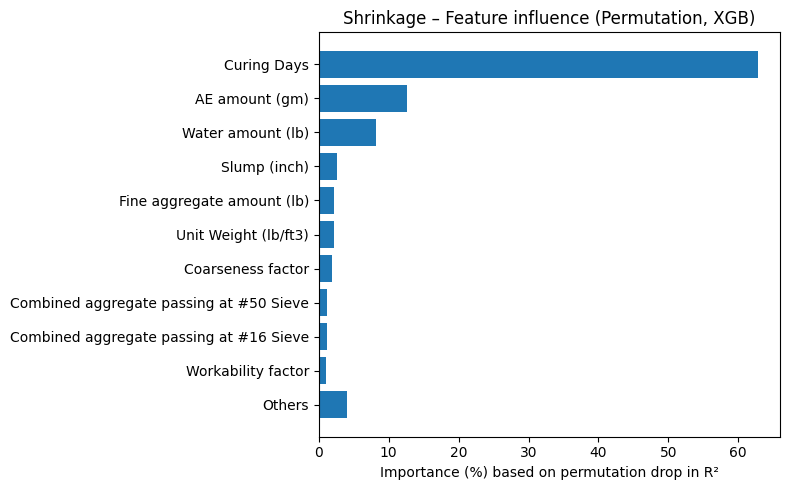

[INFO] Saved bar chart: /content/xgb_all_outputs/xgb_Shrinkage_feature_importance_bar.png

=== XGBoost – K-Fold (OOF) for target: Resitivity ===
[WARN] Dropped 50 rows with non-numeric Resitivity
[INFO] Samples: 150 | Input features: 20

[INFO] Fold 1/5 – train=120 val=30

[INFO] Fold 2/5 – train=120 val=30

[INFO] Fold 3/5 – train=120 val=30

[INFO] Fold 4/5 – train=120 val=30

[INFO] Fold 5/5 – train=120 val=30

=== OOF Metrics (XGBoost) ===
Target: Resitivity
R²   : 0.8232
RMSE : 7.0388
MAE  : 4.7485


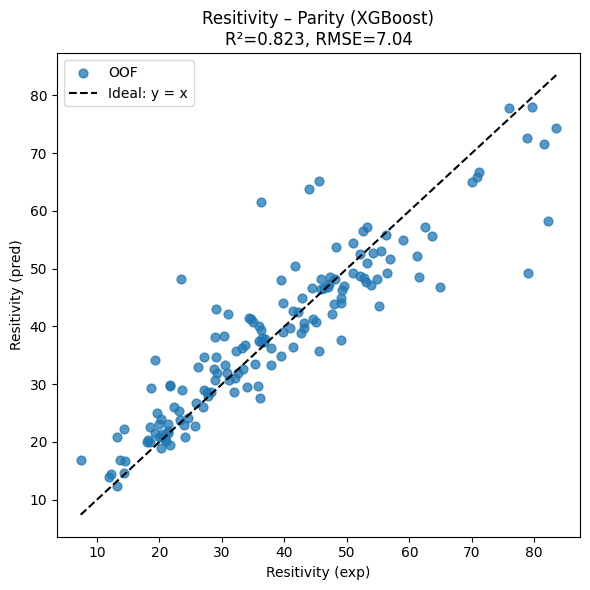

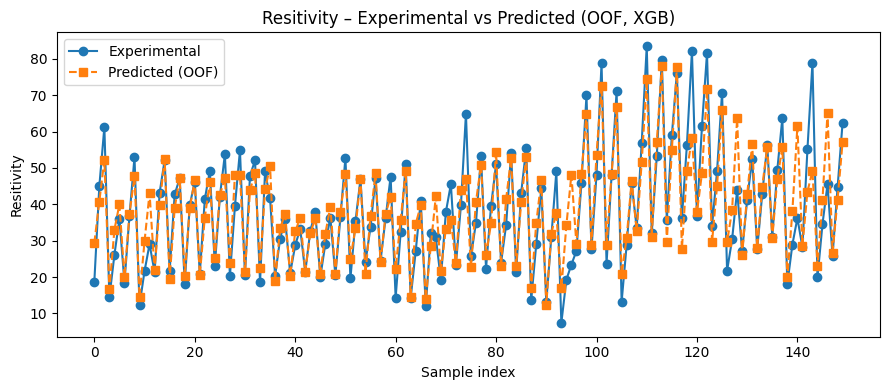

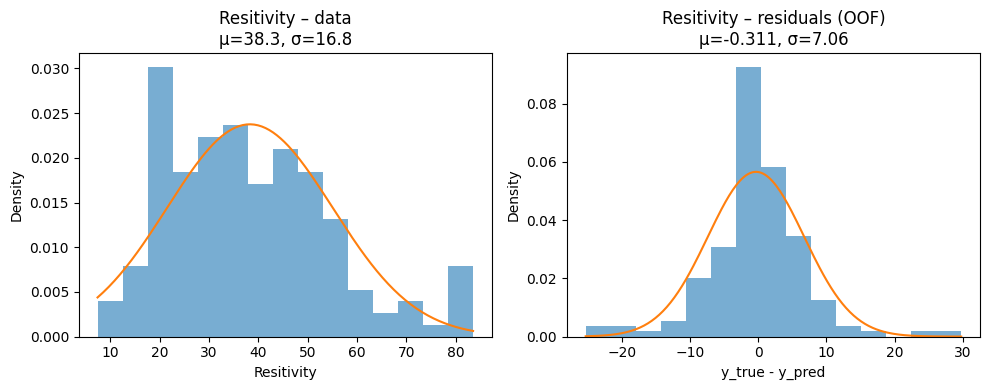


[INFO] Permutation importance (full-data fit) for: Resitivity
[INFO] Top 10 influential inputs for Resitivity (permutation):
   Curing Days: 82.22%
   Slump (inch): 5.00%
   Fine aggregate amount (lb): 4.03%
   Combined aggregate passing at #50 Sieve: 2.07%
   WRA amount (gm): 1.80%
   Combined aggregate passing at #4 Sieve: 1.09%
   Combined aggregate passing at #200 Sieve: 0.72%
   Intermediate aggregate amount (lb): 0.65%
   Unit Weight (lb/ft3): 0.49%
   Coarse aggregate amount (lb): 0.33%


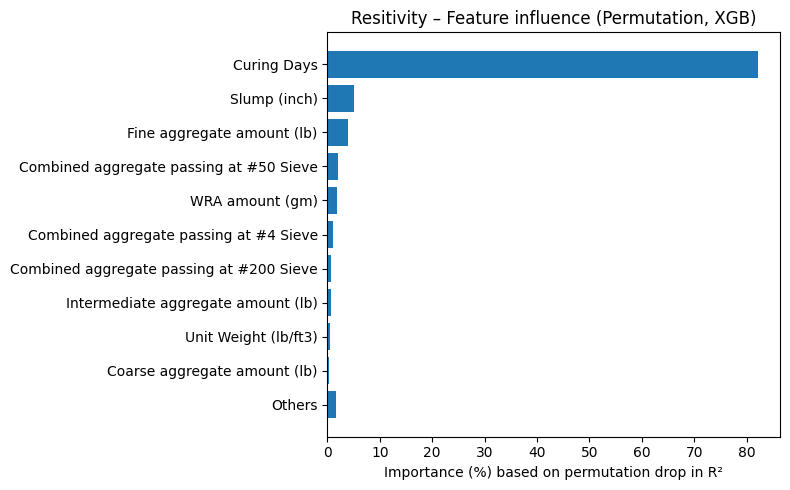

[INFO] Saved bar chart: /content/xgb_all_outputs/xgb_Resitivity_feature_importance_bar.png

All targets evaluated with XGBoost (K-Fold OOF) ✔


Target        R2       RMSE        MAE
0  SAM Number  0.999963   0.000761   0.000482
1   Shrinkage  0.578210  64.916929  45.157998
2  Resitivity  0.823170   7.038809   4.748533


Done. All outputs saved under: /content/xgb_all_outputs


In [8]:
# ================== Colab: XGBoost for ALL OUTPUTS (SAM, Shrinkage, Resitivity) ==================
# - Upload CSV/XLSX (auto header detection)
# - Inputs exclude: all targets + "Compressive Strength" + ID-like columns
# - K-Fold (OOF) metrics in ORIGINAL units per target
# - Target-specific transform: Shrinkage uses log1p/expm1; others untransformed
# - Parity / Index / Distribution plots per target
# - Feature influence via permutation-importance (bar chart, top-10 + Others)
# ===============================================================================================

# --- setup ---
!pip -q install openpyxl xgboost

import os, math, warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from io import BytesIO
from google.colab import files

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.inspection import permutation_importance

from xgboost import XGBRegressor

# --- small helpers ---
def gaussian_pdf(x, mu, sigma):
    if sigma <= 0: return np.zeros_like(x)
    return (1.0 / (np.sqrt(2.0 * np.pi) * sigma)) * np.exp(-0.5 * ((x - mu) / sigma)**2)

def make_ohe_dense():
    try:
        return OneHotEncoder(handle_unknown="ignore", sparse_output=False)
    except TypeError:
        return OneHotEncoder(handle_unknown="ignore", sparse=False)

def _read_raw(buf, is_excel):
    return pd.read_excel(buf, header=None, dtype=str) if is_excel else pd.read_csv(buf, header=None, dtype=str)

def _read_with_header(buf, is_excel, header_row):
    return pd.read_excel(buf, header=header_row) if is_excel else pd.read_csv(buf, header=header_row)

def _looks_like_name(x):
    if x is None or (isinstance(x, float) and np.isnan(x)): return False
    s = str(x).strip()
    return bool(s) and not s.lower().startswith("unnamed")

def _score_header_row(values):
    names = [v for v in values if _looks_like_name(v)]
    score = len(names)
    text = " ".join([str(v) for v in values if isinstance(v, str)])
    for k in ["Mix ID","Curing","Cement","aggregate","Slump",
              "Compressive","Strength","Unit Weight","Air Content",
              "SAM","Shrinkage","Resitivity","Resistivity"]:
        if k.lower() in text.lower(): score += 2
    return score

def detect_header_row(raw_df, search_limit=30):
    best_idx, best_score = None, -1
    nrows = min(search_limit, len(raw_df))
    for r in range(nrows):
        sc = _score_header_row(raw_df.iloc[r, :].tolist())
        if sc > best_score: best_idx, best_score = r, sc
    return best_idx, best_score

def clean_frame(df):
    df = df.dropna(axis=1, how="all").dropna(axis=0, how="all")
    df.columns = [str(c).strip() for c in df.columns]
    if df.columns.duplicated().any():
        counts, new_cols = {}, []
        for c in df.columns:
            if c not in counts:
                counts[c] = 0; new_cols.append(c)
            else:
                counts[c] += 1; new_cols.append(f"{c}_{counts[c]}")
        df.columns = new_cols
    return df

def is_shrinkage(name: str) -> bool:
    return name.strip().lower().startswith("shrink")

def forward_transform_y(y: np.ndarray, tname: str) -> np.ndarray:
    # Shrinkage only: log1p; others identity
    if is_shrinkage(tname):
        return np.log1p(np.clip(y, a_min=0, a_max=None))
    return y

def inverse_transform_y(y_trans: np.ndarray, tname: str) -> np.ndarray:
    if is_shrinkage(tname):
        return np.expm1(y_trans)
    return y_trans

# ---------------------- Upload dataset ----------------------
print("Upload your dataset (.csv or .xlsx)…")
uploaded = files.upload()
assert len(uploaded) == 1, "Upload exactly one file."
fname = list(uploaded.keys())[0]
is_excel = fname.lower().endswith((".xlsx", ".xls"))
buf = BytesIO(uploaded[fname])

raw = _read_raw(buf, is_excel)
hdr, score = detect_header_row(raw, search_limit=30)
print(f"[INFO] Auto-detected header row: {hdr} (score={score})")

buf.seek(0)
df = _read_with_header(buf, is_excel, hdr)
df = clean_frame(df)
print("[INFO] Columns detected:")
print(df.columns.tolist())

# ---------------------- CONFIG ----------------------
TARGETS = ["SAM Number", "Shrinkage", "Resitivity"]  # adjust names to match your file
K_FOLDS = 5
RANDOM_SEED = 42
# XGBoost settings (robust for small/medium tabular data)
XGB_PARAMS = dict(
    n_estimators=700,
    learning_rate=0.03,
    max_depth=6,
    subsample=0.85,
    colsample_bytree=0.75,
    reg_lambda=1.0,
    reg_alpha=0.0,
    objective="reg:squarederror",
    random_state=RANDOM_SEED,
    n_jobs=-1
)
# exclude these from inputs
non_input_extras = {"Compressive Strength", "Mix ID", "ID", "Sample", "Sample ID"}
out_dir = "/content/xgb_all_outputs"
os.makedirs(out_dir, exist_ok=True)

# summary storage
summary = []

# ---------------------- Loop over targets ----------------------
for TARGET_COL in TARGETS:
    print("\n" + "="*100)
    print(f"=== XGBoost – K-Fold (OOF) for target: {TARGET_COL} ===")

    # target presence / fuzzy fallback for resistivity spelling
    if TARGET_COL not in df.columns:
        if TARGET_COL.lower().startswith("resit"):
            cand = [c for c in df.columns if "resist" in c.lower()]
            assert len(cand) > 0, f"'{TARGET_COL}' not found and no resist* alternative detected."
            TARGET_COL = cand[0]
            print(f"[INFO] Using '{TARGET_COL}' as resistivity column")
        else:
            raise ValueError(f"Target '{TARGET_COL}' not found in columns: {df.columns.tolist()}")

    # Build inputs: exclude all targets + extras from inputs
    non_input_cols = set(TARGETS) | non_input_extras
    X_cols = [c for c in df.columns if c not in non_input_cols]

    # Numeric target series
    df_t = df.copy()
    df_t[TARGET_COL] = pd.to_numeric(df_t[TARGET_COL], errors="coerce")
    before = len(df_t)
    df_t = df_t.dropna(subset=[TARGET_COL]).copy()
    if len(df_t) < before:
        print(f"[WARN] Dropped {before - len(df_t)} rows with non-numeric {TARGET_COL}")

    X_all = df_t[X_cols]
    y_all = df_t[TARGET_COL].values
    n = len(df_t)
    print(f"[INFO] Samples: {n} | Input features: {len(X_cols)}")
    if is_shrinkage(TARGET_COL):
        print("[INFO] Using log1p transform for Shrinkage during training; reporting in original units.")

    # OOF holders
    y_oof = np.full(n, np.nan)

    kf = KFold(n_splits=K_FOLDS, shuffle=True, random_state=RANDOM_SEED)

    for fold, (tr_idx, va_idx) in enumerate(kf.split(X_all), start=1):
        print(f"\n[INFO] Fold {fold}/{K_FOLDS} – train={len(tr_idx)} val={len(va_idx)}")

        X_tr, X_va = X_all.iloc[tr_idx], X_all.iloc[va_idx]
        y_tr_raw, y_va_raw = y_all[tr_idx], y_all[va_idx]

        # transform target for training
        y_tr = forward_transform_y(y_tr_raw, TARGET_COL)

        # Preprocessing (no leakage). For trees: imputation + OHE; no scaling needed.
        num_feats = X_tr.select_dtypes(include=[np.number]).columns.tolist()
        cat_feats = [c for c in X_tr.columns if c not in num_feats]

        num_pipe = Pipeline([("imputer", SimpleImputer(strategy="median"))])
        cat_pipe = Pipeline([("imputer", SimpleImputer(strategy="most_frequent")),
                             ("onehot", make_ohe_dense())])

        pre = ColumnTransformer(
            [("num", num_pipe, num_feats),
             ("cat", cat_pipe, cat_feats)],
            remainder="drop"
        )

        Z_tr = pre.fit_transform(X_tr)
        Z_va = pre.transform(X_va)

        # Fit XGB on transformed targets
        xgb = XGBRegressor(**XGB_PARAMS)
        xgb.fit(Z_tr, y_tr)

        # Predictions in transformed space
        y_va_pred_trans = xgb.predict(Z_va)

        # Inverse transform to original units
        y_va_pred = inverse_transform_y(y_va_pred_trans, TARGET_COL)

        # Store OOF
        y_oof[va_idx] = y_va_pred

    # ------------- OOF metrics in ORIGINAL units -------------
    R2   = r2_score(y_all, y_oof)
    RMSE = math.sqrt(mean_squared_error(y_all, y_oof))
    MAE  = mean_absolute_error(y_all, y_oof)

    print("\n=== OOF Metrics (XGBoost) ===")
    print(f"Target: {TARGET_COL}")
    print(f"R²   : {R2:.4f}")
    print(f"RMSE : {RMSE:.6f}" if is_shrinkage(TARGET_COL) else f"RMSE : {RMSE:.4f}")
    print(f"MAE  : {MAE:.6f}" if is_shrinkage(TARGET_COL) else f"MAE  : {MAE:.4f}")

    summary.append({
        "Target": TARGET_COL,
        "R2": R2,
        "RMSE": RMSE,
        "MAE": MAE
    })

    # ----------------- Plots (per target) -----------------
    # Parity
    plt.figure(figsize=(6,6))
    mn = float(np.nanmin([y_all.min(), y_oof.min()]))
    mx = float(np.nanmax([y_all.max(), y_oof.max()]))
    plt.scatter(y_all, y_oof, s=40, alpha=0.75, label="OOF")
    plt.plot([mn, mx], [mn, mx], 'k--', label="Ideal: y = x")
    plt.xlabel(f"{TARGET_COL} (exp)")
    plt.ylabel(f"{TARGET_COL} (pred)")
    hint = " (log-target)" if is_shrinkage(TARGET_COL) else ""
    plt.title(f"{TARGET_COL} – Parity (XGBoost{hint})\nR²={R2:.3f}, RMSE={RMSE:.3g}")
    plt.legend(); plt.tight_layout()
    plt.savefig(os.path.join(out_dir, f"xgb_{TARGET_COL.replace(' ','_')}_parity.png"), dpi=150)
    plt.show()

    # Index
    plt.figure(figsize=(9,4))
    idx = np.arange(n)
    plt.plot(idx, y_all, "o-", label="Experimental")
    plt.plot(idx, y_oof, "s--", label="Predicted (OOF)")
    plt.xlabel("Sample index"); plt.ylabel(TARGET_COL)
    plt.title(f"{TARGET_COL} – Experimental vs Predicted (OOF, XGB{hint})")
    plt.legend(); plt.tight_layout()
    plt.savefig(os.path.join(out_dir, f"xgb_{TARGET_COL.replace(' ','_')}_index.png"), dpi=150)
    plt.show()

    # Distributions
    errors = y_all - y_oof
    plt.figure(figsize=(10,4))
    # data
    plt.subplot(1,2,1)
    plt.hist(y_all, bins=15, density=True, alpha=0.6)
    mu_y, std_y = np.nanmean(y_all), np.nanstd(y_all, ddof=1)
    xs = np.linspace(np.nanmin(y_all), np.nanmax(y_all), 200)
    plt.plot(xs, gaussian_pdf(xs, mu_y, std_y))
    plt.title(f"{TARGET_COL} – data\nμ={mu_y:.3g}, σ={std_y:.3g}")
    plt.xlabel(TARGET_COL); plt.ylabel("Density")
    # residuals
    plt.subplot(1,2,2)
    plt.hist(errors, bins=15, density=True, alpha=0.6)
    mu_e, std_e = np.nanmean(errors), np.nanstd(errors, ddof=1)
    xs_e = np.linspace(np.nanmin(errors), np.nanmax(errors), 200)
    plt.plot(xs_e, gaussian_pdf(xs_e, mu_e, std_e))
    plt.title(f"{TARGET_COL} – residuals (OOF)\nμ={mu_e:.3g}, σ={std_e:.3g}")
    plt.xlabel("y_true - y_pred"); plt.ylabel("Density")
    plt.tight_layout()
    plt.savefig(os.path.join(out_dir, f"xgb_{TARGET_COL.replace(' ','_')}_normals.png"), dpi=150)
    plt.show()

    # ----------------- Permutation importance (FULL DATA, original units) -----------------
    print(f"\n[INFO] Permutation importance (full-data fit) for: {TARGET_COL}")

    # Full-data preprocessing
    num_feats_all = X_all.select_dtypes(include=[np.number]).columns.tolist()
    cat_feats_all = [c for c in X_all.columns if c not in num_feats_all]

    num_pipe_all = Pipeline([("imputer", SimpleImputer(strategy="median"))])
    cat_pipe_all = Pipeline([("imputer", SimpleImputer(strategy="most_frequent")),
                             ("onehot", make_ohe_dense())])

    pre_all = ColumnTransformer(
        [("num", num_pipe_all, num_feats_all),
         ("cat", cat_pipe_all, cat_feats_all)],
        remainder="drop"
    )

    Z_all = pre_all.fit_transform(X_all)

    # Fit XGB on full data (transformed target)
    y_all_trans = forward_transform_y(y_all, TARGET_COL)
    xgb_full = XGBRegressor(**XGB_PARAMS).fit(Z_all, y_all_trans)

    # Wrapper: predict in ORIGINAL units for permutation_importance
    class XGBWrapper:
        def __init__(self, model, tname): self.model, self.tname = model, tname
        def fit(self, X, y): return self
        def predict(self, X):
            y_trans = self.model.predict(X)
            return inverse_transform_y(y_trans, self.tname)

    perm = permutation_importance(
        XGBWrapper(xgb_full, TARGET_COL), Z_all, y_all,
        n_repeats=20, random_state=RANDOM_SEED, scoring="r2"
    )

    imp = np.maximum(perm.importances_mean, 0)
    if imp.sum() == 0:
        print("[WARN] All permutation importances are zero. Skipping bar chart.")
    else:
        imp_norm = imp / imp.sum()

        # feature names after preprocessing
        feat_names = []
        try:
            for name, trans, cols in pre_all.transformers_:
                if name == "num":
                    feat_names += list(cols)
                elif name == "cat":
                    cat_trans = pre_all.named_transformers_["cat"]
                    if hasattr(cat_trans, "get_feature_names_out"):
                        feat_names += list(cat_trans.get_feature_names_out(cols))
                    else:
                        feat_names += list(cols)
        except Exception:
            feat_names = list(X_all.columns)

        feat_names = np.array(feat_names)
        order = np.argsort(imp_norm)[::-1]
        feat_sorted = feat_names[order]
        imp_sorted = imp_norm[order]

        print(f"[INFO] Top 10 influential inputs for {TARGET_COL} (permutation):")
        for i in range(min(10, len(feat_sorted))):
            print(f"   {feat_sorted[i]}: {imp_sorted[i]*100:.2f}%")

        # Top 10 + Others → horizontal bar
        top_n = min(10, len(feat_sorted))
        feat_top = list(feat_sorted[:top_n])
        imp_top = list(imp_sorted[:top_n])
        if len(feat_sorted) > top_n:
            others = 1.0 - sum(imp_top)
            if others > 0:
                feat_top.append("Others")
                imp_top.append(others)

        plt.figure(figsize=(8,5))
        y_pos = np.arange(len(feat_top))
        plt.barh(y_pos, [v*100 for v in imp_top], align='center')
        plt.yticks(y_pos, feat_top)
        plt.gca().invert_yaxis()
        plt.xlabel("Importance (%) based on permutation drop in R²")
        plt.title(f"{TARGET_COL} – Feature influence (Permutation, XGB)")
        plt.tight_layout()
        fp = os.path.join(out_dir, f"xgb_{TARGET_COL.replace(' ','_')}_feature_importance_bar.png")
        plt.savefig(fp, dpi=150)
        plt.show()
        print(f"[INFO] Saved bar chart: {fp}")

print("\nAll targets evaluated with XGBoost (K-Fold OOF) ✔")

# ---------------------- Summary table ----------------------
if len(summary) > 0:
    res_df = pd.DataFrame(summary)
    display(res_df)

print(f"\nDone. All outputs saved under: {out_dir}")


Upload your dataset (.csv or .xlsx)…


Saving ML-dataset.xlsx.csv to ML-dataset.xlsx (8).csv
[INFO] Auto-detected header row: 4 (score=49)
[INFO] Columns detected:
['Mix ID', 'Curing Days', 'Cement amount (lb)', 'Fly ash amount (lb)', 'Coarse aggregate amount (lb)', 'Intermediate aggregate amount (lb)', 'Fine aggregate amount (lb)', 'Water amount (lb)', 'WRA amount (gm)', 'AE amount (gm)', 'Combined aggregate passing at 1" Sieve', 'Combined aggregate passing at 1/2" Sieve', 'Combined aggregate passing at #4 Sieve', 'Combined aggregate passing at #16 Sieve', 'Combined aggregate passing at #50 Sieve', 'Combined aggregate passing at #200 Sieve', 'Workability factor', 'Coarseness factor', 'Slump (inch)', 'Unit Weight (lb/ft3)', 'Air Content (%)', 'Compressive Strength', 'SAM Number', 'Shrinkage', 'Resitivity']

=== Neural Network – K-Fold (OOF) for target: SAM Number ===
[INFO] Samples: 200 | Input features: 20

[INFO] Fold 1/5 – train=160 val=40

[INFO] Fold 2/5 – train=160 val=40

[INFO] Fold 3/5 – train=160 val=40

[INFO] Fo

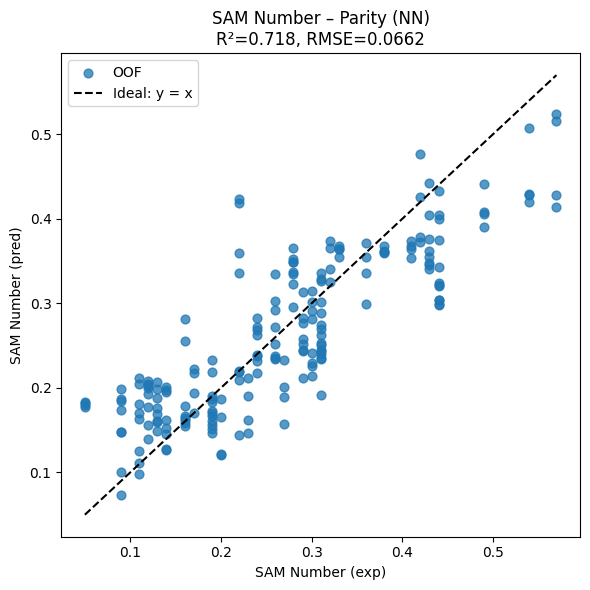

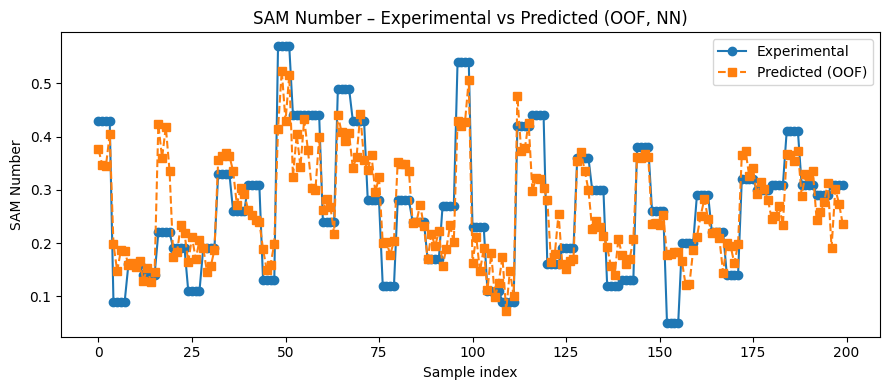

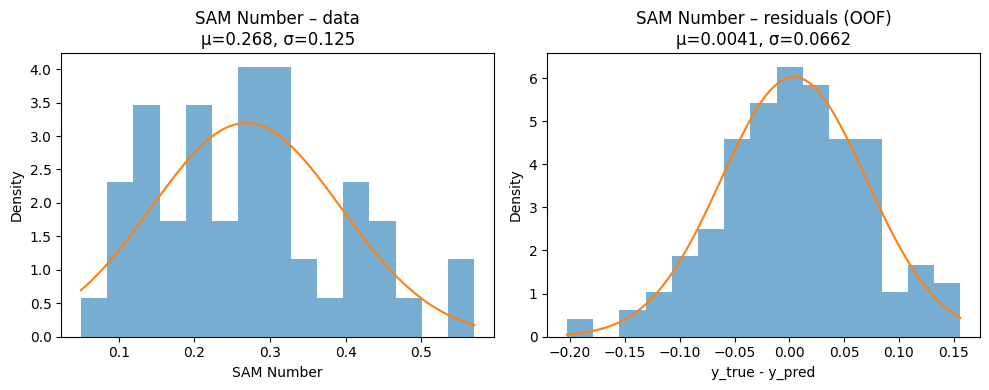


[INFO] Permutation importance (full-data fit) for: SAM Number
[INFO] Top 10 influential inputs for SAM Number (permutation):
   Unit Weight (lb/ft3): 19.56%
   Intermediate aggregate amount (lb): 12.97%
   Coarse aggregate amount (lb): 10.03%
   Air Content (%): 9.73%
   Combined aggregate passing at #50 Sieve: 7.42%
   Water amount (lb): 6.20%
   Workability factor: 4.17%
   Combined aggregate passing at 1" Sieve: 4.11%
   AE amount (gm): 3.78%
   Cement amount (lb): 3.76%


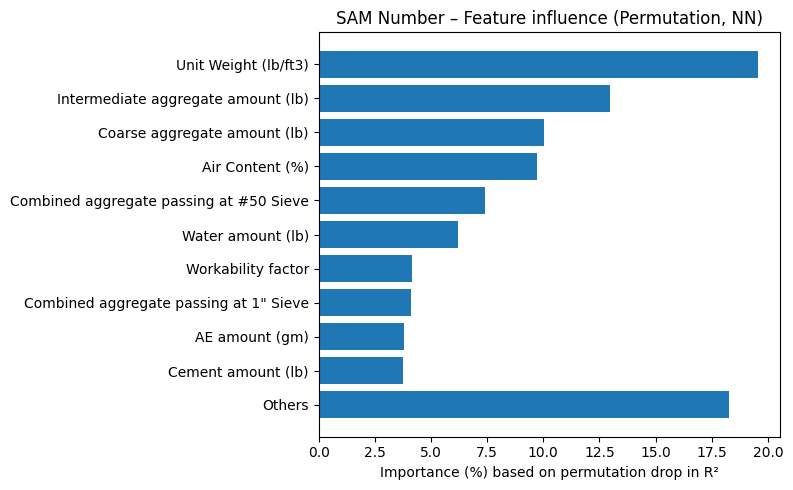

[INFO] Saved bar chart: /content/nn_all_outputs/nn_SAM_Number_feature_importance_bar.png

=== Neural Network – K-Fold (OOF) for target: Shrinkage ===
[WARN] Dropped 100 rows with non-numeric Shrinkage
[INFO] Samples: 100 | Input features: 20
[INFO] Using log1p transform for Shrinkage during training; reporting in original units.

[INFO] Fold 1/5 – train=80 val=20

[INFO] Fold 2/5 – train=80 val=20

[INFO] Fold 3/5 – train=80 val=20

[INFO] Fold 4/5 – train=80 val=20

[INFO] Fold 5/5 – train=80 val=20

=== OOF Metrics (Neural Network) ===
Target: Shrinkage
R²   : -0.6042
RMSE : 126.602434
MAE  : 101.387134
Mean predictive σ (OOF, MC Dropout): 359.690148


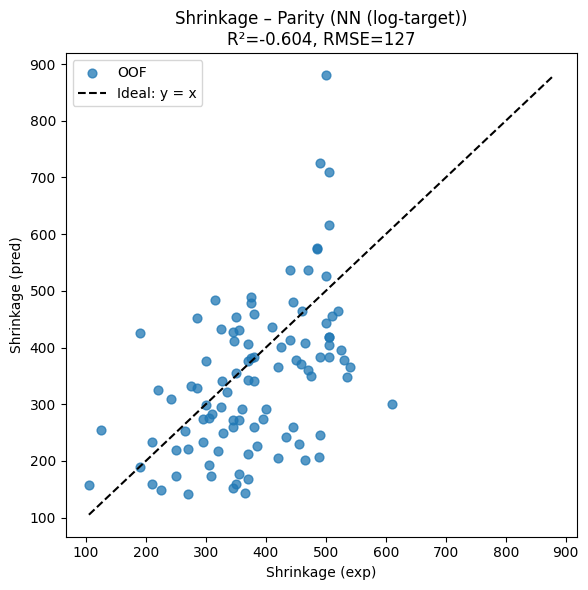

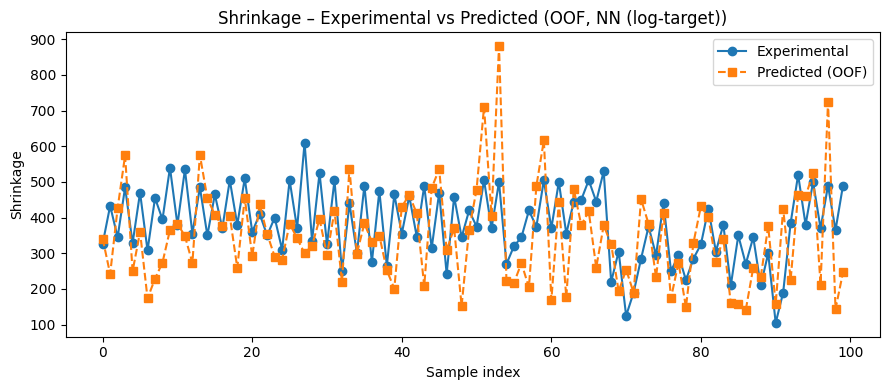

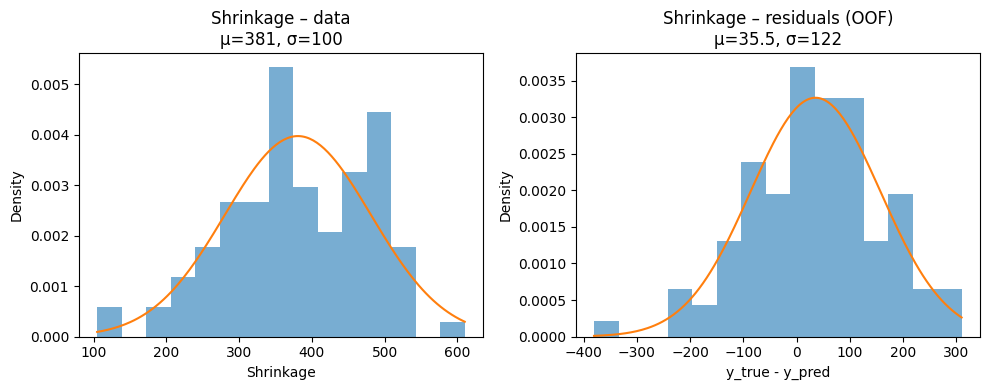


[INFO] Permutation importance (full-data fit) for: Shrinkage
[INFO] Top 10 influential inputs for Shrinkage (permutation):
   Curing Days: 16.83%
   Combined aggregate passing at #4 Sieve: 10.48%
   Combined aggregate passing at #200 Sieve: 9.16%
   Slump (inch): 8.53%
   Fine aggregate amount (lb): 5.91%
   WRA amount (gm): 5.42%
   Air Content (%): 5.35%
   Combined aggregate passing at #16 Sieve: 4.16%
   Cement amount (lb): 3.98%
   Coarseness factor: 3.88%


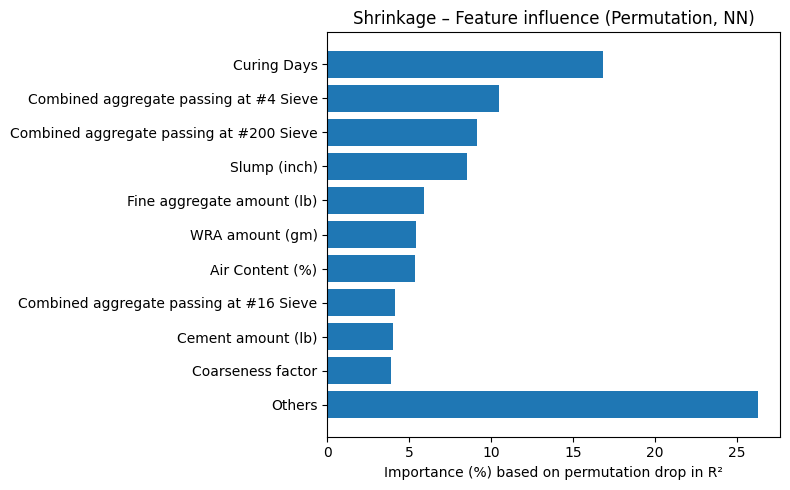

[INFO] Saved bar chart: /content/nn_all_outputs/nn_Shrinkage_feature_importance_bar.png

=== Neural Network – K-Fold (OOF) for target: Resitivity ===
[WARN] Dropped 50 rows with non-numeric Resitivity
[INFO] Samples: 150 | Input features: 20

[INFO] Fold 1/5 – train=120 val=30

[INFO] Fold 2/5 – train=120 val=30

[INFO] Fold 3/5 – train=120 val=30

[INFO] Fold 4/5 – train=120 val=30

[INFO] Fold 5/5 – train=120 val=30

=== OOF Metrics (Neural Network) ===
Target: Resitivity
R²   : 0.7953
RMSE : 7.5740
MAE  : 5.5868
Mean predictive σ (OOF, MC Dropout): 4.9733


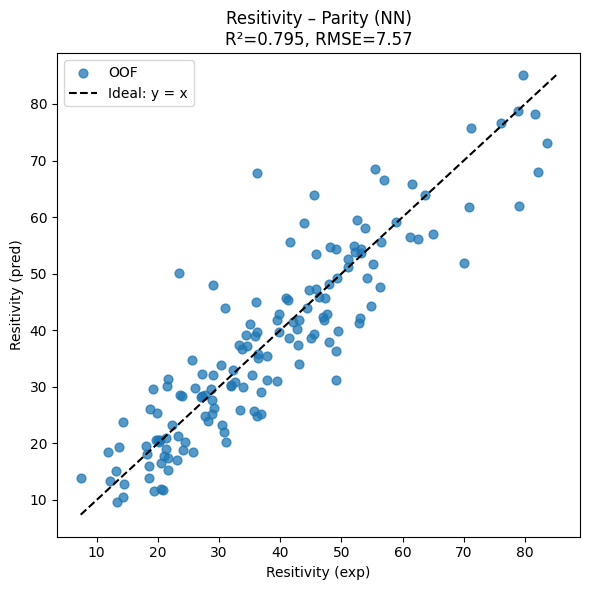

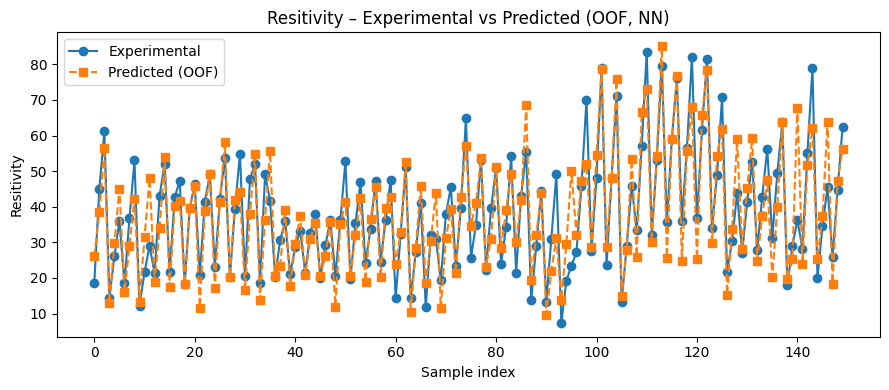

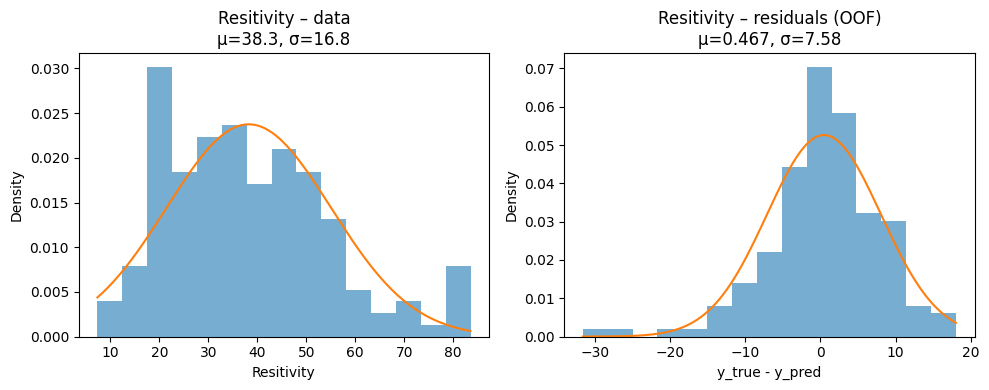


[INFO] Permutation importance (full-data fit) for: Resitivity
[INFO] Top 10 influential inputs for Resitivity (permutation):
   Curing Days: 57.23%
   Combined aggregate passing at #50 Sieve: 4.13%
   WRA amount (gm): 4.04%
   Slump (inch): 3.67%
   Air Content (%): 3.56%
   Combined aggregate passing at 1" Sieve: 3.31%
   Combined aggregate passing at #200 Sieve: 2.76%
   Workability factor: 2.65%
   Combined aggregate passing at #4 Sieve: 2.44%
   Fine aggregate amount (lb): 2.32%


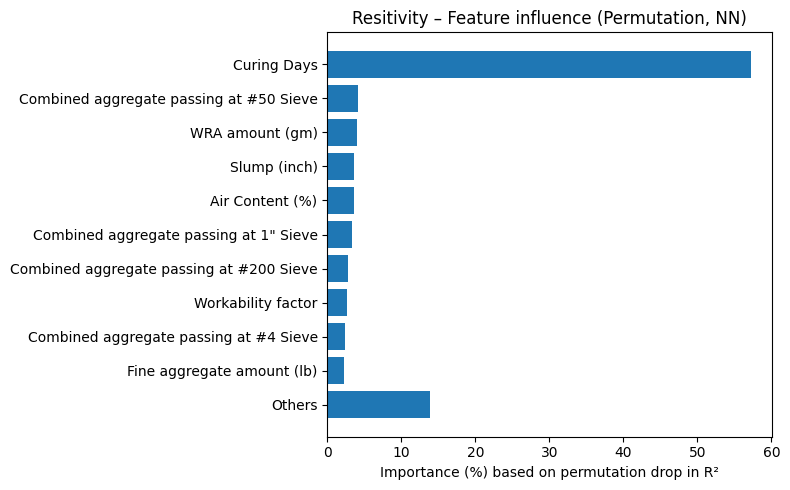

[INFO] Saved bar chart: /content/nn_all_outputs/nn_Resitivity_feature_importance_bar.png


Target        R2        RMSE         MAE   MeanSigma
0  SAM Number  0.717999    0.066154    0.052430    0.053321
1   Shrinkage -0.604221  126.602434  101.387134  359.690148
2  Resitivity  0.795260    7.573952    5.586790    4.973302

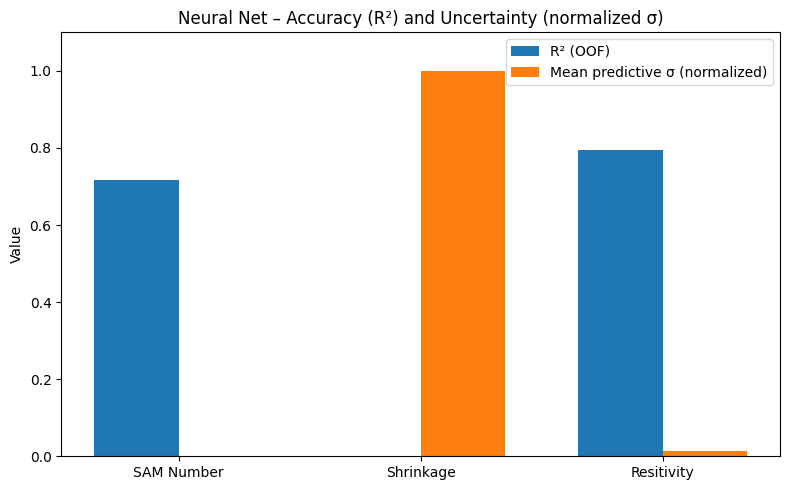

[INFO] Saved summary chart: /content/nn_all_outputs/nn_summary_R2_uncertainty.png

Done. All outputs saved under: /content/nn_all_outputs


In [11]:
# ================== Colab: Neural Network (Keras) for ALL OUTPUTS ==================
# Targets: ["SAM Number", "Shrinkage", "Resitivity"]
# - Upload CSV/XLSX (auto header detection)
# - Inputs exclude: all targets + "Compressive Strength" + ID-like columns
# - K-Fold (OOF) metrics in ORIGINAL units per target
# - Target-specific transform: Shrinkage uses log1p/expm1; others untransformed
# - MLP with BatchNorm + Dropout, EarlyStopping, ReduceLROnPlateau
# - MC Dropout for predictive uncertainty (mean/std over T forward passes)
# - Parity / Index / Distribution plots per target
# - Permutation-importance (model-agnostic) bar chart per target
# ================================================================================

# --- setup ---
!pip -q install openpyxl

import os, math, warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from io import BytesIO
from google.colab import files

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.inspection import permutation_importance

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, callbacks, backend as K

# --------------- small helpers ---------------
def gaussian_pdf(x, mu, sigma):
    if sigma <= 0: return np.zeros_like(x)
    return (1.0 / (np.sqrt(2.0 * np.pi) * sigma)) * np.exp(-0.5 * ((x - mu) / sigma)**2)

def make_ohe_dense():
    # Handles sklearn <1.2 vs >=1.2
    try:
        return OneHotEncoder(handle_unknown="ignore", sparse_output=False)
    except TypeError:
        return OneHotEncoder(handle_unknown="ignore", sparse=False)

def _read_raw(buf, is_excel):
    return pd.read_excel(buf, header=None, dtype=str) if is_excel else pd.read_csv(buf, header=None, dtype=str)

def _read_with_header(buf, is_excel, header_row):
    return pd.read_excel(buf, header=header_row) if is_excel else pd.read_csv(buf, header=header_row)

def _looks_like_name(x):
    if x is None or (isinstance(x, float) and np.isnan(x)): return False
    s = str(x).strip()
    return bool(s) and not s.lower().startswith("unnamed")

def _score_header_row(values):
    names = [v for v in values if _looks_like_name(v)]
    score = len(names)
    text = " ".join([str(v) for v in values if isinstance(v, str)])
    for k in ["Mix ID","Curing","Cement","aggregate","Slump",
              "Compressive","Strength","Unit Weight","Air Content",
              "SAM","Shrinkage","Resitivity","Resistivity"]:
        if k.lower() in text.lower(): score += 2
    return score

def detect_header_row(raw_df, search_limit=30):
    best_idx, best_score = None, -1
    nrows = min(search_limit, len(raw_df))
    for r in range(nrows):
        sc = _score_header_row(raw_df.iloc[r, :].tolist())
        if sc > best_score: best_idx, best_score = r, sc
    return best_idx, best_score

def clean_frame(df):
    df = df.dropna(axis=1, how="all").dropna(axis=0, how="all")
    df.columns = [str(c).strip() for c in df.columns]
    if df.columns.duplicated().any():
        counts, new_cols = {}, []
        for c in df.columns:
            if c not in counts:
                counts[c] = 0; new_cols.append(c)
            else:
                counts[c] += 1; new_cols.append(f"{c}_{counts[c]}")
        df.columns = new_cols
    return df

def is_shrinkage(name: str) -> bool:
    return name.strip().lower().startswith("shrink")

def forward_transform_y(y: np.ndarray, tname: str) -> np.ndarray:
    if is_shrinkage(tname):
        return np.log1p(np.clip(y, a_min=0, a_max=None))
    return y

def inverse_transform_y(y_trans: np.ndarray, tname: str) -> np.ndarray:
    if is_shrinkage(tname):
        return np.expm1(y_trans)
    return y_trans

# --------------- model builder ---------------
def build_mlp(input_dim: int, dropout=0.25) -> keras.Model:
    inp = layers.Input(shape=(input_dim,))
    x = layers.Dense(256, activation="relu")(inp)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(dropout)(x)  # MC Dropout enabled later with training=True

    x = layers.Dense(128, activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(dropout)(x)

    x = layers.Dense(64, activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(dropout)(x)

    out = layers.Dense(1, activation="linear")(x)
    model = keras.Model(inp, out)
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=3e-3),
        loss="mse",
        metrics=[keras.metrics.MeanAbsoluteError(name="mae")]
    )
    return model

# MC dropout predictions: returns (mean, std) over T stochastic forward passes
@tf.function
def _mc_forward(model, x, T: int):
    preds = []
    for _ in tf.range(T):
        # training=True keeps dropout active
        preds.append(model(x, training=True))
    stacked = tf.stack(preds, axis=0)  # [T, N, 1]
    mu = tf.reduce_mean(stacked, axis=0)[:, 0]
    std = tf.math.reduce_std(stacked, axis=0, ddof=1)[:, 0]
    return mu, std

# ---- REPLACE these two functions in your NN cell ----
def predict_mc(model, X, T=50, batch_size=128):
    """
    MC Dropout in eager mode to avoid InaccessibleTensorError.
    Works with any Keras model that has Dropout layers.
    Returns mean and std over T stochastic forward passes (in model's output space).
    """
    import numpy as np
    import tensorflow as tf

    X = np.asarray(X, dtype=np.float32)
    preds = []
    # Loop eagerly: each pass keeps Dropout active via training=True
    for _ in range(T):
        y = model(tf.convert_to_tensor(X), training=True)
        preds.append(tf.reshape(y, (-1,)).numpy())
    preds = np.stack(preds, axis=0)  # [T, N]
    mu = preds.mean(axis=0)
    std = preds.std(axis=0, ddof=1)
    return mu, std

# ---------------------- Upload dataset ----------------------
print("Upload your dataset (.csv or .xlsx)…")
uploaded = files.upload()
assert len(uploaded) == 1, "Upload exactly one file."
fname = list(uploaded.keys())[0]
is_excel = fname.lower().endswith((".xlsx", ".xls"))
buf = BytesIO(uploaded[fname])

raw = _read_raw(buf, is_excel)
hdr, score = detect_header_row(raw, search_limit=30)
print(f"[INFO] Auto-detected header row: {hdr} (score={score})")

buf.seek(0)
df = _read_with_header(buf, is_excel, hdr)
df = clean_frame(df)
print("[INFO] Columns detected:")
print(df.columns.tolist())

# ---------------------- CONFIG ----------------------
TARGETS = ["SAM Number", "Shrinkage", "Resitivity"]  # adjust to exact names in your file
K_FOLDS = 5
RANDOM_SEED = 42
DROPOUT = 0.25
EPOCHS = 800
BATCH_SIZE = 32
MC_DROPOUT_PASSES = 50

# exclude these from inputs
non_input_extras = {"Compressive Strength", "Mix ID", "ID", "Sample", "Sample ID"}
out_dir = "/content/nn_all_outputs"
os.makedirs(out_dir, exist_ok=True)

# for reproducibility
tf.random.set_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

# summary storage
summary = []

# ---------------------- Loop over targets ----------------------
for TARGET_COL in TARGETS:
    print("\n" + "="*100)
    print(f"=== Neural Network – K-Fold (OOF) for target: {TARGET_COL} ===")

    # handle resistivity spelling
    if TARGET_COL not in df.columns:
        if TARGET_COL.lower().startswith("resit"):
            cand = [c for c in df.columns if "resist" in c.lower()]
            assert len(cand) > 0, f"'{TARGET_COL}' not found and no resist* alternative detected."
            TARGET_COL = cand[0]
            print(f"[INFO] Using '{TARGET_COL}' as resistivity column")
        else:
            raise ValueError(f"Target '{TARGET_COL}' not found in columns: {df.columns.tolist()}")

    # Build inputs: exclude all targets + extras
    non_input_cols = set(TARGETS) | non_input_extras
    X_cols = [c for c in df.columns if c not in non_input_cols]

    # Clean numeric target
    df_t = df.copy()
    df_t[TARGET_COL] = pd.to_numeric(df_t[TARGET_COL], errors="coerce")
    before = len(df_t)
    df_t = df_t.dropna(subset=[TARGET_COL]).copy()
    if len(df_t) < before:
        print(f"[WARN] Dropped {before - len(df_t)} rows with non-numeric {TARGET_COL}")

    X_all = df_t[X_cols]
    y_all = df_t[TARGET_COL].values.astype(np.float32)
    n = len(df_t)
    print(f"[INFO] Samples: {n} | Input features: {len(X_cols)}")
    if is_shrinkage(TARGET_COL):
        print("[INFO] Using log1p transform for Shrinkage during training; reporting in original units.")

    # OOF holders
    y_oof = np.full(n, np.nan, dtype=np.float64)
    sigma_oof = np.full(n, np.nan, dtype=np.float64)

    kf = KFold(n_splits=K_FOLDS, shuffle=True, random_state=RANDOM_SEED)

    for fold, (tr_idx, va_idx) in enumerate(kf.split(X_all), start=1):
        print(f"\n[INFO] Fold {fold}/{K_FOLDS} – train={len(tr_idx)} val={len(va_idx)}")

        X_tr, X_va = X_all.iloc[tr_idx], X_all.iloc[va_idx]
        y_tr_raw, y_va_raw = y_all[tr_idx], y_all[va_idx]

        # transform target for training (log1p only for shrinkage)
        y_tr = forward_transform_y(y_tr_raw, TARGET_COL).astype(np.float32)

        # Preprocessing (no leakage): numeric impute+scale, categorical impute+OHE
        num_feats = X_tr.select_dtypes(include=[np.number]).columns.tolist()
        cat_feats = [c for c in X_tr.columns if c not in num_feats]

        num_pipe = Pipeline([("imputer", SimpleImputer(strategy="median")),
                             ("scaler", StandardScaler())])
        cat_pipe = Pipeline([("imputer", SimpleImputer(strategy="most_frequent")),
                             ("onehot", make_ohe_dense())])

        pre = ColumnTransformer(
            [("num", num_pipe, num_feats),
             ("cat", cat_pipe, cat_feats)],
            remainder="drop"
        )

        Z_tr = pre.fit_transform(X_tr)
        Z_va = pre.transform(X_va)

        input_dim = Z_tr.shape[1]
        model = build_mlp(input_dim, dropout=DROPOUT)

        es = callbacks.EarlyStopping(monitor="val_loss", patience=50, restore_best_weights=True, verbose=0)
        rlrop = callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=20, min_lr=1e-5, verbose=0)

        history = model.fit(
            Z_tr, y_tr,
            validation_data=(Z_va, forward_transform_y(y_va_raw, TARGET_COL)),
            epochs=EPOCHS,
            batch_size=BATCH_SIZE,
            verbose=0,
            callbacks=[es, rlrop]
        )

        # MC dropout predictions in transformed space
        mu_trans, std_trans = predict_mc(model, Z_va, T=MC_DROPOUT_PASSES, batch_size=128)
        # Inverse-transform to original units
        y_va_pred = inverse_transform_y(mu_trans, TARGET_COL)

        # Map std to original units via delta method
        if is_shrinkage(TARGET_COL):
            # y = expm1(z) ⇒ dy/dz ≈ 1 + y
            dy_dz = 1.0 + np.clip(y_va_pred, a_min=0, a_max=None)
            sigma_va = std_trans * dy_dz
        else:
            sigma_va = std_trans  # identity

        y_oof[va_idx] = y_va_pred
        sigma_oof[va_idx] = sigma_va

    # ------------- OOF metrics in ORIGINAL units -------------
    R2   = r2_score(y_all, y_oof)
    RMSE = math.sqrt(mean_squared_error(y_all, y_oof))
    MAE  = mean_absolute_error(y_all, y_oof)
    mean_sigma = float(np.nanmean(sigma_oof))

    print("\n=== OOF Metrics (Neural Network) ===")
    print(f"Target: {TARGET_COL}")
    print(f"R²   : {R2:.4f}")
    print(f"RMSE : {RMSE:.6f}" if is_shrinkage(TARGET_COL) else f"RMSE : {RMSE:.4f}")
    print(f"MAE  : {MAE:.6f}" if is_shrinkage(TARGET_COL) else f"MAE  : {MAE:.4f}")
    print(f"Mean predictive σ (OOF, MC Dropout): {mean_sigma:.6f}" if is_shrinkage(TARGET_COL) else f"Mean predictive σ (OOF, MC Dropout): {mean_sigma:.4f}")

    summary.append({
        "Target": TARGET_COL,
        "R2": R2,
        "RMSE": RMSE,
        "MAE": MAE,
        "MeanSigma": mean_sigma
    })

    # ----------------- Plots (per target) -----------------
    # Parity
    plt.figure(figsize=(6,6))
    mn = float(np.nanmin([y_all.min(), y_oof.min()]))
    mx = float(np.nanmax([y_all.max(), y_oof.max()]))
    plt.scatter(y_all, y_oof, s=40, alpha=0.75, label="OOF")
    plt.plot([mn, mx], [mn, mx], 'k--', label="Ideal: y = x")
    plt.xlabel(f"{TARGET_COL} (exp)")
    plt.ylabel(f"{TARGET_COL} (pred)")
    hint = " (log-target)" if is_shrinkage(TARGET_COL) else ""
    plt.title(f"{TARGET_COL} – Parity (NN{hint})\nR²={R2:.3f}, RMSE={RMSE:.3g}")
    plt.legend(); plt.tight_layout()
    plt.savefig(os.path.join(out_dir, f"nn_{TARGET_COL.replace(' ','_')}_parity.png"), dpi=150)
    plt.show()

    # Index
    plt.figure(figsize=(9,4))
    idx = np.arange(n)
    plt.plot(idx, y_all, "o-", label="Experimental")
    plt.plot(idx, y_oof, "s--", label="Predicted (OOF)")
    plt.xlabel("Sample index"); plt.ylabel(TARGET_COL)
    plt.title(f"{TARGET_COL} – Experimental vs Predicted (OOF, NN{hint})")
    plt.legend(); plt.tight_layout()
    plt.savefig(os.path.join(out_dir, f"nn_{TARGET_COL.replace(' ','_')}_index.png"), dpi=150)
    plt.show()

    # Distributions
    errors = y_all - y_oof
    plt.figure(figsize=(10,4))
    # data
    plt.subplot(1,2,1)
    plt.hist(y_all, bins=15, density=True, alpha=0.6)
    mu_y, std_y = np.nanmean(y_all), np.nanstd(y_all, ddof=1)
    xs = np.linspace(np.nanmin(y_all), np.nanmax(y_all), 200)
    plt.plot(xs, gaussian_pdf(xs, mu_y, std_y))
    plt.title(f"{TARGET_COL} – data\nμ={mu_y:.3g}, σ={std_y:.3g}")
    plt.xlabel(TARGET_COL); plt.ylabel("Density")
    # residuals
    plt.subplot(1,2,2)
    plt.hist(errors, bins=15, density=True, alpha=0.6)
    mu_e, std_e = np.nanmean(errors), np.nanstd(errors, ddof=1)
    xs_e = np.linspace(np.nanmin(errors), np.nanmax(errors), 200)
    plt.plot(xs_e, gaussian_pdf(xs_e, mu_e, std_e))
    plt.title(f"{TARGET_COL} – residuals (OOF)\nμ={mu_e:.3g}, σ={std_e:.3g}")
    plt.xlabel("y_true - y_pred"); plt.ylabel("Density")
    plt.tight_layout()
    plt.savefig(os.path.join(out_dir, f"nn_{TARGET_COL.replace(' ','_')}_normals.png"), dpi=150)
    plt.show()

    # ----------------- Permutation importance (FULL DATA, original units) -----------------
    print(f"\n[INFO] Permutation importance (full-data fit) for: {TARGET_COL}")

    # Full-data preprocessing
    num_feats_all = X_all.select_dtypes(include=[np.number]).columns.tolist()
    cat_feats_all = [c for c in X_all.columns if c not in num_feats_all]

    num_pipe_all = Pipeline([("imputer", SimpleImputer(strategy="median")),
                             ("scaler", StandardScaler())])
    cat_pipe_all = Pipeline([("imputer", SimpleImputer(strategy="most_frequent")),
                             ("onehot", make_ohe_dense())])

    pre_all = ColumnTransformer(
        [("num", num_pipe_all, num_feats_all),
         ("cat", cat_pipe_all, cat_feats_all)],
        remainder="drop"
    )

    Z_all = pre_all.fit_transform(X_all)

    # Fit NN on full data (transformed target)
    y_all_trans = forward_transform_y(y_all, TARGET_COL).astype(np.float32)
    model_full = build_mlp(Z_all.shape[1], dropout=DROPOUT)
    es_full = callbacks.EarlyStopping(monitor="loss", patience=40, restore_best_weights=True, verbose=0)
    rlrop_full = callbacks.ReduceLROnPlateau(monitor="loss", factor=0.5, patience=15, min_lr=1e-5, verbose=0)
    model_full.fit(Z_all, y_all_trans, epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=0, callbacks=[es_full, rlrop_full])

    # Wrapper: predict in ORIGINAL units (deterministic: use inference mode / MC mean)
    class NNWrapper:
        def __init__(self, model, tname, mc_passes=0):
            self.model = model
            self.tname = tname
            self.mc_passes = mc_passes
        def fit(self, X, y): return self
        def predict(self, X):
            Xtf = tf.convert_to_tensor(X, dtype=tf.float32)
            if self.mc_passes and self.mc_passes > 0:
                mu, _ = _mc_forward(self.model, Xtf, tf.constant(self.mc_passes))
                y_trans = mu.numpy()
            else:
                y_trans = self.model.predict(X, verbose=0).ravel()
            return inverse_transform_y(y_trans, self.tname)

    # Use deterministic predict for permutation_importance to reduce noise
    nn_est = NNWrapper(model_full, TARGET_COL, mc_passes=0)
    perm = permutation_importance(
        nn_est, Z_all, y_all,
        n_repeats=15, random_state=RANDOM_SEED, scoring="r2"
    )

    imp = np.maximum(perm.importances_mean, 0)
    if imp.sum() == 0:
        print("[WARN] All permutation importances are zero. Skipping bar chart.")
    else:
        imp_norm = imp / imp.sum()

        # feature names after preprocessing
        feat_names = []
        try:
            for name, trans, cols in pre_all.transformers_:
                if name == "num":
                    feat_names += list(cols)
                elif name == "cat":
                    cat_trans = pre_all.named_transformers_["cat"]
                    if hasattr(cat_trans, "get_feature_names_out"):
                        feat_names += list(cat_trans.get_feature_names_out(cols))
                    else:
                        feat_names += list(cols)
        except Exception:
            feat_names = list(X_all.columns)

        feat_names = np.array(feat_names)
        order = np.argsort(imp_norm)[::-1]
        feat_sorted = feat_names[order]
        imp_sorted = imp_norm[order]

        print(f"[INFO] Top 10 influential inputs for {TARGET_COL} (permutation):")
        for i in range(min(10, len(feat_sorted))):
            print(f"   {feat_sorted[i]}: {imp_sorted[i]*100:.2f}%")

        # Top 10 + Others → horizontal bar
        top_n = min(10, len(feat_sorted))
        feat_top = list(feat_sorted[:top_n])
        imp_top = list(imp_sorted[:top_n])
        if len(feat_sorted) > top_n:
            others = 1.0 - sum(imp_top)
            if others > 0:
                feat_top.append("Others")
                imp_top.append(others)

        plt.figure(figsize=(8,5))
        y_pos = np.arange(len(feat_top))
        plt.barh(y_pos, [v*100 for v in imp_top], align='center')
        plt.yticks(y_pos, feat_top)
        plt.gca().invert_yaxis()
        plt.xlabel("Importance (%) based on permutation drop in R²")
        plt.title(f"{TARGET_COL} – Feature influence (Permutation, NN)")
        plt.tight_layout()
        fp = os.path.join(out_dir, f"nn_{TARGET_COL.replace(' ','_')}_feature_importance_bar.png")
        plt.savefig(fp, dpi=150)
        plt.show()
        print(f"[INFO] Saved bar chart: {fp}")

# ---------------------- Summary bar chart ----------------------
if summary:
    res_df = pd.DataFrame(summary)
    display(res_df)

    # Normalize uncertainty for plotting (if any target had σ)
    sigma = pd.Series([row.get("MeanSigma", np.nan) for row in summary])
    if sigma.notna().any():
        sigma_norm = sigma / sigma.replace(0, np.nan).max()
        sigma_norm = sigma_norm.fillna(0.0)
        x = np.arange(len(res_df))
        width = 0.35
        plt.figure(figsize=(8,5))
        plt.bar(x - width/2, res_df["R2"], width, label="R² (OOF)")
        plt.bar(x + width/2, sigma_norm, width, label="Mean predictive σ (normalized)")
        plt.xticks(x, res_df["Target"])
        plt.ylim(0, 1.1)
        plt.ylabel("Value")
        plt.title("Neural Net – Accuracy (R²) and Uncertainty (normalized σ)")
        plt.legend()
        plt.tight_layout()
        fp = os.path.join(out_dir, "nn_summary_R2_uncertainty.png")
        plt.savefig(fp, dpi=150)
        plt.show()
        print(f"[INFO] Saved summary chart: {fp}")
    else:
        print("[INFO] No uncertainty values collected; skipping uncertainty summary plot.")

print(f"\nDone. All outputs saved under: {out_dir}")


Upload your dataset (.csv or .xlsx)…


Saving ML-dataset.xlsx.csv to ML-dataset.xlsx (9).csv
[INFO] Header row -> 4 (score=49)
[INFO] Columns: ['Mix ID', 'Curing Days', 'Cement amount (lb)', 'Fly ash amount (lb)', 'Coarse aggregate amount (lb)', 'Intermediate aggregate amount (lb)', 'Fine aggregate amount (lb)', 'Water amount (lb)', 'WRA amount (gm)', 'AE amount (gm)', 'Combined aggregate passing at 1" Sieve', 'Combined aggregate passing at 1/2" Sieve', 'Combined aggregate passing at #4 Sieve', 'Combined aggregate passing at #16 Sieve', 'Combined aggregate passing at #50 Sieve', 'Combined aggregate passing at #200 Sieve', 'Workability factor', 'Coarseness factor', 'Slump (inch)', 'Unit Weight (lb/ft3)', 'Air Content (%)', 'Compressive Strength', 'SAM Number', 'Shrinkage', 'Resitivity']

### Target: SAM Number | Samples: 200 | Inputs: 20

### Target: Shrinkage | Samples: 100 | Inputs: 20

### Target: Resitivity | Samples: 150 | Inputs: 20


Target         Model        R2       RMSE        MAE   MeanSigma
8   Resitivity           GPR  0.717889   8.890605   6.172815    3.939905
11  Resitivity     NeuralNet  0.815659   7.186743   5.466591    4.023534
9   Resitivity  RandomForest  0.634747  10.116219   8.345476   11.652459
10  Resitivity       XGBoost  0.823170   7.038809   4.748533         NaN
0   SAM Number           GPR  0.999998   0.000177   0.000112    0.004136
3   SAM Number     NeuralNet  0.772749   0.059386   0.046677    0.109537
1   SAM Number  RandomForest  0.940009   0.030512   0.017854    0.043639
2   SAM Number       XGBoost  0.999963   0.000761   0.000482         NaN
4    Shrinkage           GPR  0.518935  69.328480  48.331942   70.350087
7    Shrinkage     NeuralNet  0.045983  97.631079  77.251488  207.845656
5    Shrinkage  RandomForest  0.443518  74.565078  58.403025   73.618820
6    Shrinkage       XGBoost  0.578210  64.916929  45.157998         NaN

[INFO] Saved metrics table -> /content/model_compare_outputs/metrics_summary.csv


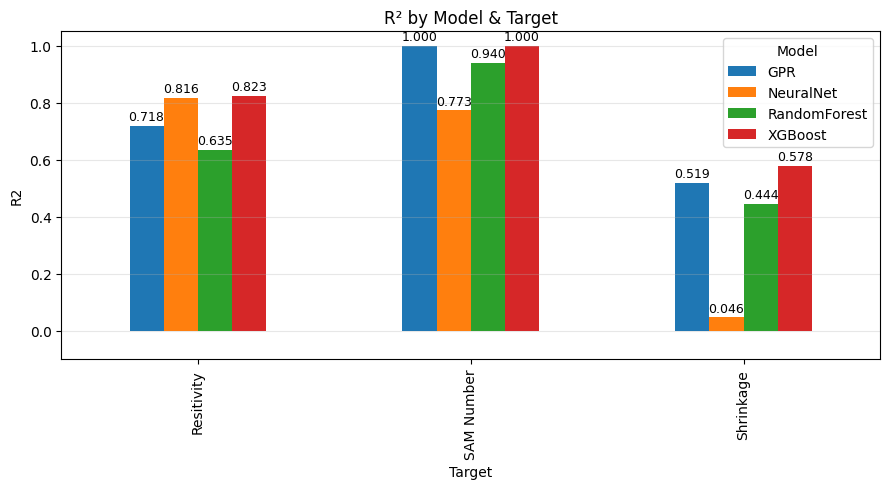

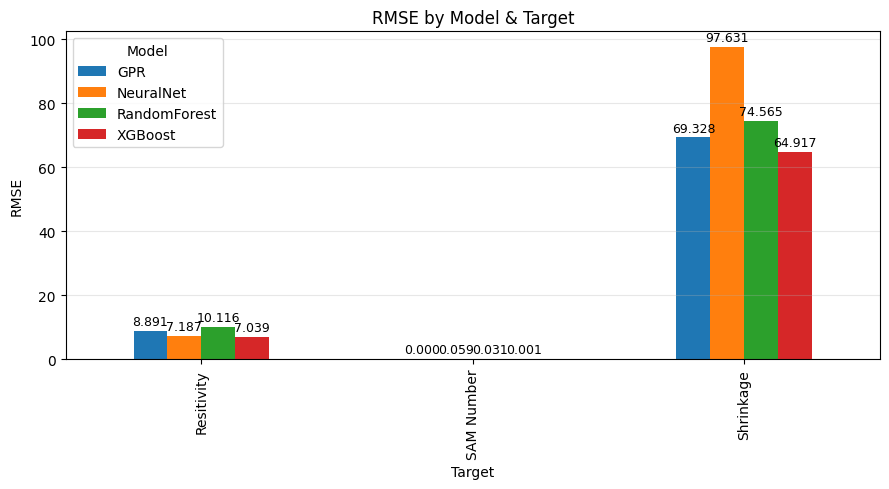

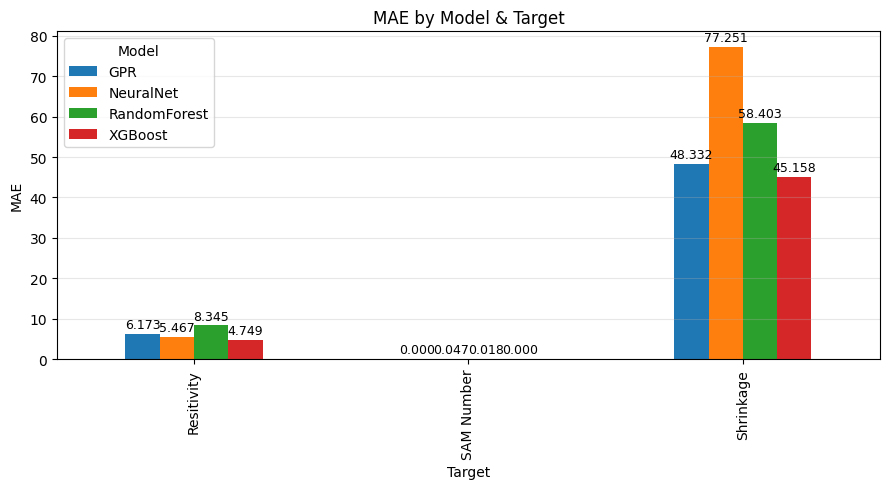

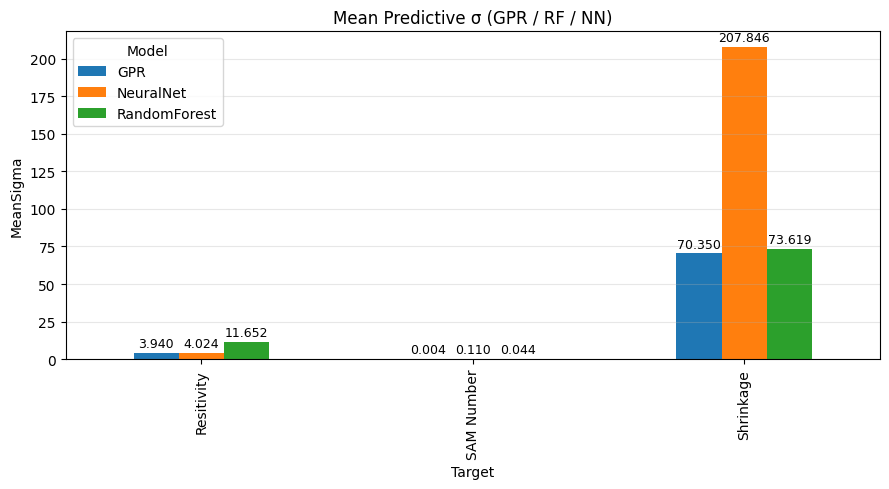

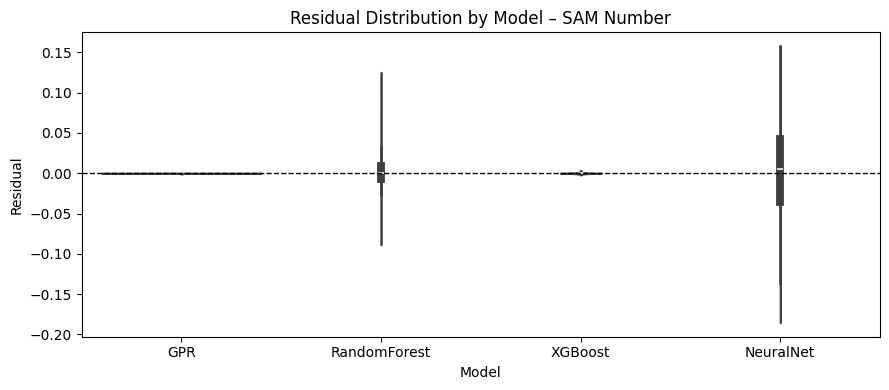

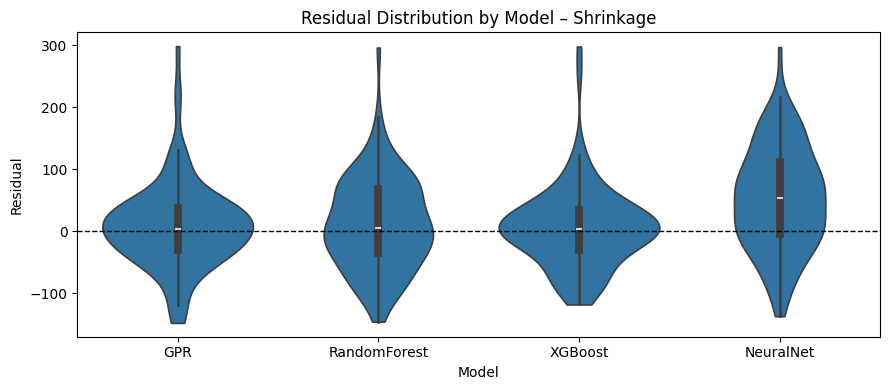

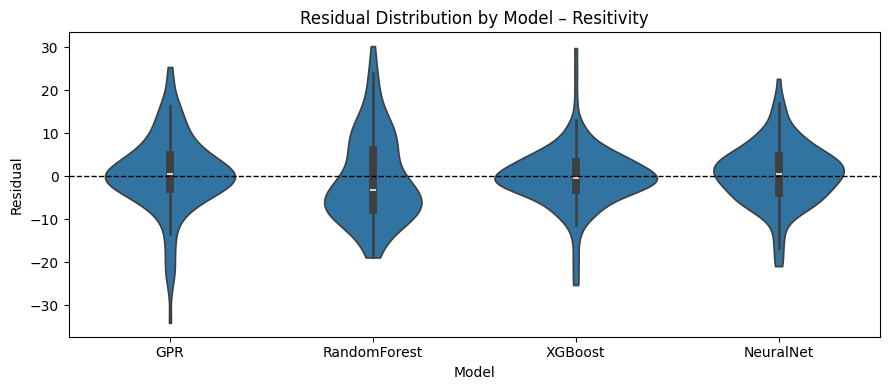

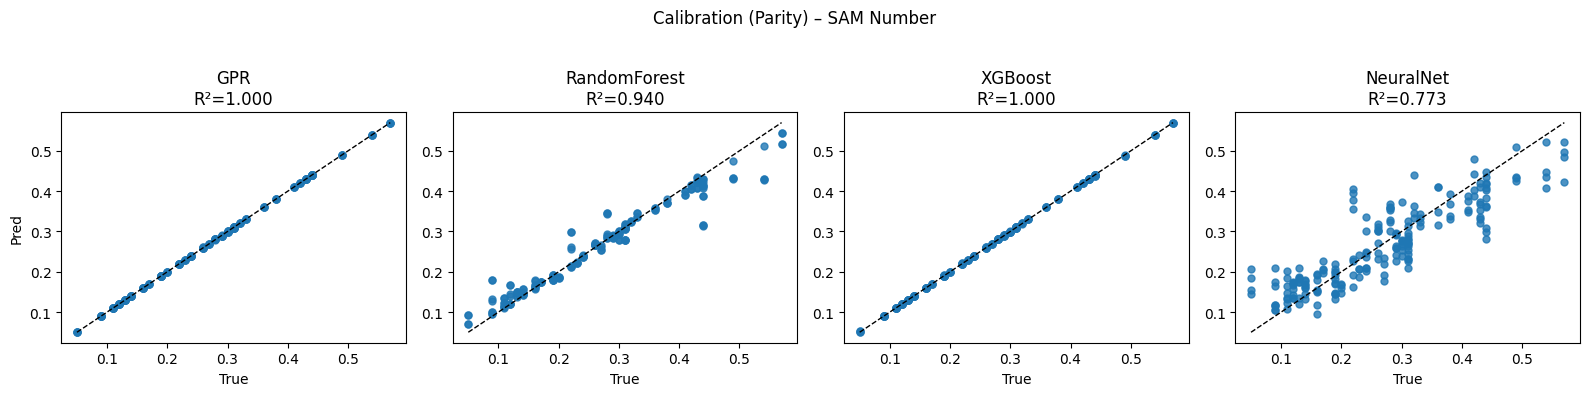

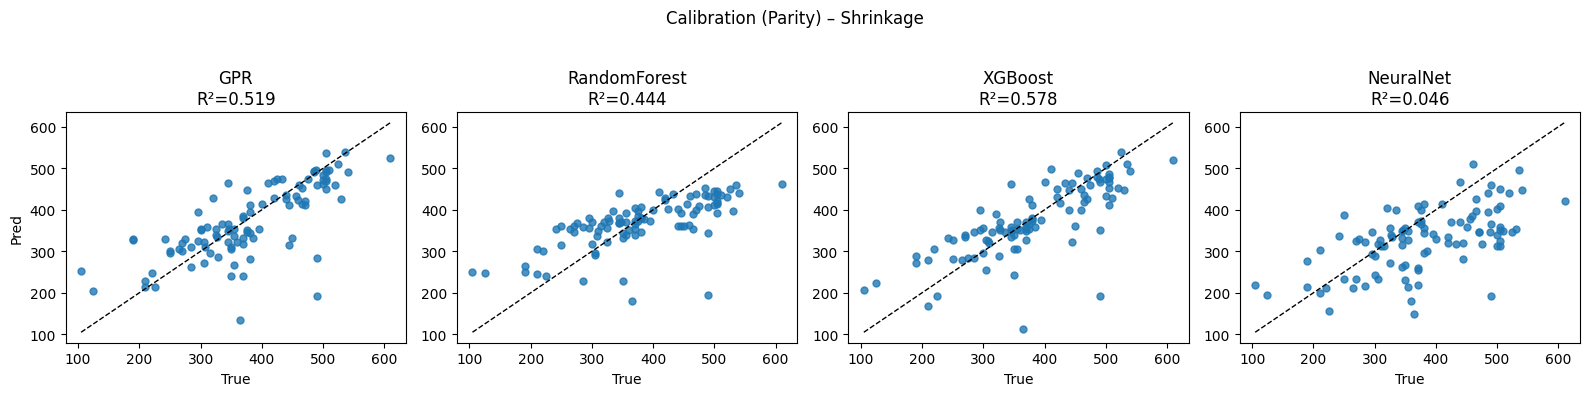

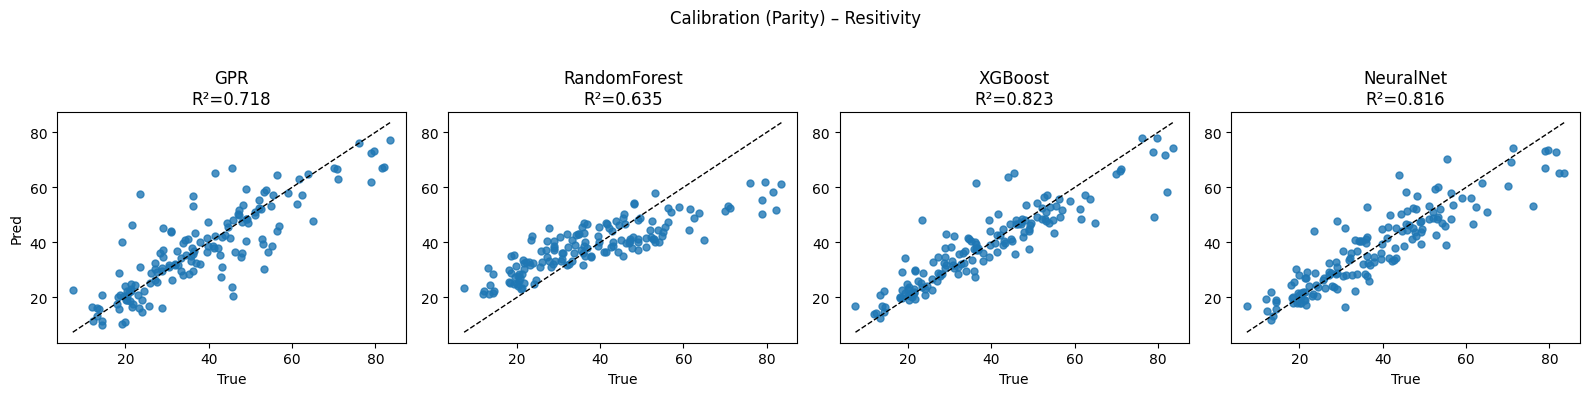

Target        ModelA        ModelB  Wilcoxon       p_value  \
15  Resitivity  RandomForest       XGBoost    1720.0  1.392178e-13   
16  Resitivity  RandomForest     NeuralNet    2748.0  4.543725e-08   
12  Resitivity           GPR  RandomForest    3543.0  6.988129e-05   
13  Resitivity           GPR       XGBoost    4308.0  1.104201e-02   
17  Resitivity       XGBoost     NeuralNet    4524.0  3.267137e-02   
14  Resitivity           GPR     NeuralNet    5268.0  4.591929e-01   
0   SAM Number           GPR  RandomForest       7.0  1.595764e-34   
2   SAM Number           GPR     NeuralNet       0.0  1.436146e-34   
3   SAM Number  RandomForest       XGBoost      24.0  2.060599e-34   
5   SAM Number       XGBoost     NeuralNet       0.0  1.436146e-34   
4   SAM Number  RandomForest     NeuralNet    1070.0  6.141744e-28   
1   SAM Number           GPR       XGBoost    1514.0  2.109697e-25   
11   Shrinkage       XGBoost     NeuralNet    1080.0  6.751477e-07   
8    Shrinkage           GPR     NeuralNet    1279.0  1.834369e-05   
9    Shrinkage  RandomForest       XGBoost    1403.0  1.144120e-04   
10   Shrinkage  RandomForest     NeuralNet    1728.0  6.137474e-03   
6    Shrinkage           GPR  RandomForest    1789.0  1.138653e-02   
7    Shrinkage           GPR       XGBoost    2200.0  2.637996e-01   

    p_value_holm  
15  8.353070e-13  
16  2.271862e-07  
12  2.795252e-04  
13  3.312604e-02  
17  6.534275e-02  
14  4.591929e-01  
0   8.616878e-34  
2   8.616878e-34  
3   8.616878e-34  
5   8.616878e-34  
4   1.228349e-27  
1   2.109697e-25  
11  4.050886e-06  
8   9.171843e-05  
9   4.576479e-04  
10  1.841242e-02  
6   2.277306e-02  
7   2.637996e-01

[INFO] Saved Wilcoxon comparison table -> /content/model_compare_outputs/pairwise_wilcoxon_holm.csv

All artifacts saved under: /content/model_compare_outputs


In [12]:
# ================================== Colab: 4-Model Comparison (GPR, RF, XGB, NN) ==================================
# Targets: ["SAM Number", "Shrinkage", "Resitivity"]
# - Auto header detect; excludes "Compressive Strength" + IDs from inputs
# - Shrinkage uses log1p/expm1; others identity
# - K-Fold OOF metrics; uncertainty for GPR / RF / NN
# - Comparison tables + grouped bar charts + residual violins + calibration plots
# - Pairwise Wilcoxon tests on absolute errors with Holm correction per target
# ====================================================================================================================

!pip -q install openpyxl xgboost scipy

import os, math, warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from io import BytesIO
from google.colab import files

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.inspection import permutation_importance

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ConstantKernel as C
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

from scipy.stats import wilcoxon

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, callbacks

# ------------------- CONFIG -------------------
TARGETS = ["SAM Number", "Shrinkage", "Resitivity"]   # adjust to match your header names
K_FOLDS = 5
RANDOM_SEED = 42
N_RESTARTS_GPR = 5
MC_DROPOUT_PASSES = 50

EXCLUDE_INPUTS = {"Compressive Strength", "Mix ID", "ID", "Sample", "Sample ID"} | set(TARGETS)
OUT_DIR = "/content/model_compare_outputs"
os.makedirs(OUT_DIR, exist_ok=True)

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

# ------------------- Helpers -------------------
def gaussian_pdf(x, mu, sigma):
    if sigma <= 0: return np.zeros_like(x)
    return (1.0 / (np.sqrt(2*np.pi) * sigma)) * np.exp(-0.5 * ((x - mu)/sigma)**2)

def make_ohe_dense():
    try:
        return OneHotEncoder(handle_unknown="ignore", sparse_output=False)
    except TypeError:
        return OneHotEncoder(handle_unknown="ignore", sparse=False)

def _read_raw(buf, is_excel):
    return pd.read_excel(buf, header=None, dtype=str) if is_excel else pd.read_csv(buf, header=None, dtype=str)

def _read_with_header(buf, is_excel, header_row):
    return pd.read_excel(buf, header=header_row) if is_excel else pd.read_csv(buf, header=header_row)

def _looks_like_name(x):
    if x is None or (isinstance(x, float) and np.isnan(x)): return False
    s = str(x).strip()
    return bool(s) and not s.lower().startswith("unnamed")

def _score_header_row(values):
    names = [v for v in values if _looks_like_name(v)]
    score = len(names)
    text = " ".join([str(v) for v in values if isinstance(v, str)])
    for k in ["Mix ID","Curing","Cement","aggregate","Slump",
              "Compressive","Strength","Unit Weight","Air Content",
              "SAM","Shrinkage","Resitivity","Resistivity"]:
        if k.lower() in text.lower(): score += 2
    return score

def detect_header_row(raw_df, search_limit=30):
    best_idx, best_score = None, -1
    for r in range(min(search_limit, len(raw_df))):
        sc = _score_header_row(raw_df.iloc[r,:].tolist())
        if sc > best_score:
            best_idx, best_score = r, sc
    return best_idx, best_score

def clean_frame(df):
    df = df.dropna(axis=1, how="all").dropna(axis=0, how="all")
    df.columns = [str(c).strip() for c in df.columns]
    if df.columns.duplicated().any():
        counts, new_cols = {}, []
        for c in df.columns:
            if c not in counts:
                counts[c]=0; new_cols.append(c)
            else:
                counts[c]+=1; new_cols.append(f"{c}_{counts[c]}")
        df.columns = new_cols
    return df

def is_shrinkage(name:str) -> bool:
    return name.strip().lower().startswith("shrink")

def forward_y(y, tname):
    return np.log1p(np.clip(y,0,None)) if is_shrinkage(tname) else y

def inverse_y(y_trans, tname):
    return np.expm1(y_trans) if is_shrinkage(tname) else y_trans

def build_preprocessor(X_fit):
    num_feats = X_fit.select_dtypes(include=[np.number]).columns.tolist()
    cat_feats = [c for c in X_fit.columns if c not in num_feats]
    num = Pipeline([("imputer", SimpleImputer(strategy="median")),
                    ("scaler", StandardScaler())])
    cat = Pipeline([("imputer", SimpleImputer(strategy="most_frequent")),
                    ("onehot", make_ohe_dense())])
    return ColumnTransformer([("num", num, num_feats), ("cat", cat, cat_feats)], remainder="drop")

# ------------------- Model runners (return OOF preds & per-sample σ where applicable) -------------------
def run_gpr(X, y, tname):
    kf = KFold(n_splits=K_FOLDS, shuffle=True, random_state=RANDOM_SEED)
    y_oof = np.full(len(y), np.nan)
    s_oof = np.full(len(y), np.nan)

    for fold, (tr, va) in enumerate(kf.split(X),1):
        Xtr, Xva = X.iloc[tr], X.iloc[va]
        ytr_raw, yva_raw = y[tr], y[va]
        ytr = forward_y(ytr_raw, tname)

        pre = build_preprocessor(Xtr)
        Ztr = pre.fit_transform(Xtr)
        Zva = pre.transform(Xva)

        n_features = Ztr.shape[1]
        kernel = C(1.0, (1e-2,1e2))*RBF(length_scale=np.ones(n_features), length_scale_bounds=(1e-2,1e2)) \
                 + WhiteKernel(1e-2, (1e-5,1e0))
        gpr = GaussianProcessRegressor(kernel=kernel, alpha=0.0, normalize_y=False,
                                       n_restarts_optimizer=N_RESTARTS_GPR, random_state=RANDOM_SEED+fold)
        gpr.fit(Ztr, ytr)

        yva_pred_trans, yva_std_trans = gpr.predict(Zva, return_std=True)
        yva_pred = inverse_y(yva_pred_trans, tname)

        if is_shrinkage(tname):
            dy_dz = 1.0 + np.clip(yva_pred,0,None)
            s_va = yva_std_trans * dy_dz
        else:
            s_va = yva_std_trans

        y_oof[va] = yva_pred
        s_oof[va] = s_va

    return y_oof, s_oof

def run_rf(X, y, tname):
    kf = KFold(n_splits=K_FOLDS, shuffle=True, random_state=RANDOM_SEED)
    y_oof = np.full(len(y), np.nan)
    s_oof = np.full(len(y), np.nan)

    rf = RandomForestRegressor(
        n_estimators=700, max_depth=None, min_samples_leaf=2, max_features="sqrt",
        bootstrap=True, n_jobs=-1, random_state=RANDOM_SEED
    )

    for fold, (tr, va) in enumerate(kf.split(X),1):
        Xtr, Xva = X.iloc[tr], X.iloc[va]
        ytr_raw, yva_raw = y[tr], y[va]
        ytr = forward_y(ytr_raw, tname)

        pre = build_preprocessor(Xtr)
        Ztr = pre.fit_transform(Xtr)
        Zva = pre.transform(Xva)

        rf.fit(Ztr, ytr)
        yva_pred_trans = rf.predict(Zva)
        yva_pred = inverse_y(yva_pred_trans, tname)

        # ensemble spread
        all_tree = np.vstack([est.predict(Zva) for est in rf.estimators_])
        std_trans = np.std(all_tree, axis=0, ddof=1)
        if is_shrinkage(tname):
            dy_dz = 1.0 + np.clip(yva_pred,0,None)
            s_va = std_trans * dy_dz
        else:
            s_va = std_trans

        y_oof[va] = yva_pred
        s_oof[va] = s_va
    return y_oof, s_oof

def run_xgb(X, y, tname):
    kf = KFold(n_splits=K_FOLDS, shuffle=True, random_state=RANDOM_SEED)
    y_oof = np.full(len(y), np.nan)

    xgb_params = dict(
        n_estimators=700, learning_rate=0.03, max_depth=6,
        subsample=0.85, colsample_bytree=0.75,
        reg_lambda=1.0, reg_alpha=0.0,
        objective="reg:squarederror", random_state=RANDOM_SEED, n_jobs=-1
    )

    for fold, (tr, va) in enumerate(kf.split(X),1):
        Xtr, Xva = X.iloc[tr], X.iloc[va]
        ytr_raw, yva_raw = y[tr], y[va]
        ytr = forward_y(ytr_raw, tname)

        pre = build_preprocessor(Xtr)
        Ztr = pre.fit_transform(Xtr)
        Zva = pre.transform(Xva)

        model = XGBRegressor(**xgb_params)
        model.fit(Ztr, ytr)
        yva_pred_trans = model.predict(Zva)
        yva_pred = inverse_y(yva_pred_trans, tname)
        y_oof[va] = yva_pred

    return y_oof, None  # no native σ

# --- NN (MLP with LayerNorm + Dropout). MC Dropout in eager mode ---
def build_mlp(input_dim, dropout=0.25):
    inp = layers.Input(shape=(input_dim,))
    x = layers.Dense(256, activation="relu")(inp)
    x = layers.LayerNormalization()(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Dense(128, activation="relu")(x)
    x = layers.LayerNormalization()(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Dense(64, activation="relu")(x)
    x = layers.LayerNormalization()(x)
    x = layers.Dropout(dropout)(x)
    out = layers.Dense(1, activation="linear")(x)
    model = keras.Model(inp, out)
    model.compile(optimizer=keras.optimizers.Adam(3e-3), loss="mse")
    return model

def predict_mc(model, Z, T=MC_DROPOUT_PASSES):
    Z = np.asarray(Z, dtype=np.float32)
    preds=[]
    for _ in range(T):
        y = model(tf.convert_to_tensor(Z), training=True)
        preds.append(tf.reshape(y, (-1,)).numpy())
    preds = np.stack(preds, axis=0)
    return preds.mean(axis=0), preds.std(axis=0, ddof=1)

def run_nn(X, y, tname):
    kf = KFold(n_splits=K_FOLDS, shuffle=True, random_state=RANDOM_SEED)
    y_oof = np.full(len(y), np.nan)
    s_oof = np.full(len(y), np.nan)

    for fold, (tr, va) in enumerate(kf.split(X),1):
        Xtr, Xva = X.iloc[tr], X.iloc[va]
        ytr_raw, yva_raw = y[tr], y[va]
        ytr = forward_y(ytr_raw, tname).astype(np.float32)
        yva_trans = forward_y(yva_raw, tname).astype(np.float32)

        pre = build_preprocessor(Xtr)
        Ztr = pre.fit_transform(Xtr)
        Zva = pre.transform(Xva)

        model = build_mlp(Ztr.shape[1], dropout=0.25)
        es = callbacks.EarlyStopping(monitor="val_loss", patience=50, restore_best_weights=True, verbose=0)
        rlrop = callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=20, min_lr=1e-5, verbose=0)

        model.fit(Ztr, ytr, validation_data=(Zva, yva_trans),
                  epochs=800, batch_size=32, verbose=0, callbacks=[es, rlrop])

        mu_trans, std_trans = predict_mc(model, Zva, T=MC_DROPOUT_PASSES)
        yva_pred = inverse_y(mu_trans, tname)
        if is_shrinkage(tname):
            dy_dz = 1.0 + np.clip(yva_pred,0,None)
            s_va = std_trans * dy_dz
        else:
            s_va = std_trans

        y_oof[va] = yva_pred
        s_oof[va] = s_va
    return y_oof, s_oof

# ------------------- Upload & Prepare -------------------
print("Upload your dataset (.csv or .xlsx)…")
uploaded = files.upload()
assert len(uploaded)==1, "Upload exactly one file."
fname = list(uploaded.keys())[0]
is_excel = fname.lower().endswith((".xlsx",".xls"))
buf = BytesIO(uploaded[fname])

raw = _read_raw(buf, is_excel)
hdr, score = detect_header_row(raw)
print(f"[INFO] Header row -> {hdr} (score={score})")

buf.seek(0)
df = _read_with_header(buf, is_excel, hdr)
df = clean_frame(df)
print("[INFO] Columns:", df.columns.tolist())

# Handle resistivity spelling
if "Resitivity" not in df.columns:
    for c in df.columns:
        if "resist" in c.lower():  # pick first
            TARGETS = ["SAM Number", "Shrinkage", c]
            print(f"[INFO] Using '{c}' as Resistivity column")
            break

# ------------------- Train all models for each target -------------------
all_metrics = []   # rows: (target, model, R2, RMSE, MAE, mean_sigma)
per_sample = {}    # (target, model) -> DataFrame with y_true, y_pred, sigma

for target in TARGETS:
    if target not in df.columns:
        raise ValueError(f"Target '{target}' not found in columns.")
    # Inputs exclude targets and EXCLUDE_INPUTS (which already includes targets)
    X_cols = [c for c in df.columns if c not in EXCLUDE_INPUTS]
    y_series = pd.to_numeric(df[target], errors="coerce")
    sub = pd.concat([df[X_cols], y_series], axis=1).dropna(subset=[target])
    X = sub[X_cols]
    y = sub[target].values

    print("\n"+"="*110)
    print(f"### Target: {target} | Samples: {len(y)} | Inputs: {len(X_cols)}")

    # GPR
    y_gpr, s_gpr = run_gpr(X, y, target)
    # RF
    y_rf, s_rf = run_rf(X, y, target)
    # XGB
    y_xgb, _ = run_xgb(X, y, target)
    # NN
    y_nn, s_nn = run_nn(X, y, target)

    # Metrics helper
    def metrics(y_true, y_pred, sigma=None):
        R2 = r2_score(y_true, y_pred)
        RMSE = math.sqrt(mean_squared_error(y_true, y_pred))
        MAE = mean_absolute_error(y_true, y_pred)
        mean_sigma = float(np.nanmean(sigma)) if sigma is not None else np.nan
        return R2, RMSE, MAE, mean_sigma

    for name, yp, sp in [
        ("GPR", y_gpr, s_gpr),
        ("RandomForest", y_rf, s_rf),
        ("XGBoost", y_xgb, None),
        ("NeuralNet", y_nn, s_nn),
    ]:
        R2, RMSE, MAE, MS = metrics(y, yp, sp)
        all_metrics.append(dict(Target=target, Model=name, R2=R2, RMSE=RMSE, MAE=MAE, MeanSigma=MS))
        per_sample[(target, name)] = pd.DataFrame({"y_true": y, "y_pred": yp, "sigma": sp})

# ------------------- Results tables -------------------
metrics_df = pd.DataFrame(all_metrics)
display(metrics_df.sort_values(["Target","Model"]))

metrics_df.to_csv(os.path.join(OUT_DIR, "metrics_summary.csv"), index=False)
print(f"[INFO] Saved metrics table -> {OUT_DIR}/metrics_summary.csv")

# ------------------- Plots: grouped bars -------------------
def grouped_bar(df, value_col, title, ylim=None, fmt="{:.3f}", fname="plot.png"):
    pivot = df.pivot(index="Target", columns="Model", values=value_col)
    ax = pivot.plot(kind="bar", figsize=(9,5))
    ax.set_ylabel(value_col)
    ax.set_title(title)
    ax.grid(axis="y", alpha=0.3)
    if ylim: ax.set_ylim(*ylim)
    for c in ax.containers:
        ax.bar_label(c, fmt=fmt, padding=2, fontsize=9)
    plt.tight_layout()
    plt.savefig(os.path.join(OUT_DIR, fname), dpi=150)
    plt.show()

grouped_bar(metrics_df, "R2", "R² by Model & Target", ylim=(-0.1,1.05), fname="bar_R2.png")
grouped_bar(metrics_df, "RMSE", "RMSE by Model & Target", fname="bar_RMSE.png")
grouped_bar(metrics_df, "MAE", "MAE by Model & Target", fname="bar_MAE.png")

# Predictive sigma comparisons (note: XGB has no σ)
sigma_df = metrics_df.dropna(subset=["MeanSigma"])
if len(sigma_df):
    grouped_bar(sigma_df, "MeanSigma", "Mean Predictive σ (GPR / RF / NN)", fname="bar_sigma.png")

# ------------------- Residual violin plots per target -------------------
import seaborn as sns
for target in TARGETS:
    rows=[]
    for model in ["GPR","RandomForest","XGBoost","NeuralNet"]:
        dfm = per_sample[(target, model)]
        res = dfm["y_true"] - dfm["y_pred"]
        rows.append(pd.DataFrame({"Model": model, "Residual": res}))
    V = pd.concat(rows, ignore_index=True)
    plt.figure(figsize=(9,4))
    sns.violinplot(data=V, x="Model", y="Residual", cut=0, inner="box")
    plt.axhline(0, color="k", linestyle="--", linewidth=1)
    plt.title(f"Residual Distribution by Model – {target}")
    plt.tight_layout()
    fn = f"violin_residuals_{target.replace(' ','_')}.png"
    plt.savefig(os.path.join(OUT_DIR, fn), dpi=150)
    plt.show()

# ------------------- Calibration (parity) grids -------------------
for target in TARGETS:
    fig, axes = plt.subplots(1,4, figsize=(16,4), sharex=False, sharey=False)
    models = ["GPR","RandomForest","XGBoost","NeuralNet"]
    for j, m in enumerate(models):
        dfm = per_sample[(target, m)]
        y_true, y_pred = dfm["y_true"].values, dfm["y_pred"].values
        mn = float(np.nanmin([y_true.min(), y_pred.min()]))
        mx = float(np.nanmax([y_true.max(), y_pred.max()]))
        axes[j].scatter(y_true, y_pred, s=25, alpha=0.8)
        axes[j].plot([mn,mx],[mn,mx],'k--',lw=1)
        R2 = r2_score(y_true, y_pred)
        axes[j].set_title(f"{m}\nR²={R2:.3f}")
        axes[j].set_xlabel("True")
        if j==0: axes[j].set_ylabel("Pred")
    plt.suptitle(f"Calibration (Parity) – {target}")
    plt.tight_layout(rect=[0,0,1,0.95])
    fn = f"calibration_grid_{target.replace(' ','_')}.png"
    plt.savefig(os.path.join(OUT_DIR, fn), dpi=150)
    plt.show()

# ------------------- Pairwise Wilcoxon tests on absolute errors (per target) -------------------
def holm_adjust(pvals):
    m = len(pvals)
    order = np.argsort(pvals)
    adj = np.empty_like(pvals)
    for rank, idx in enumerate(order, start=1):
        adj[idx] = min((m - rank + 1) * pvals[idx], 1.0)
    # monotone non-decreasing
    for i in range(1, m):
        adj[order[i]] = max(adj[order[i]], adj[order[i-1]])
    return adj

pairs = [("GPR","RandomForest"),("GPR","XGBoost"),("GPR","NeuralNet"),
         ("RandomForest","XGBoost"),("RandomForest","NeuralNet"),
         ("XGBoost","NeuralNet")]

rows=[]
for target in TARGETS:
    aes = {m: np.abs(per_sample[(target,m)]["y_true"] - per_sample[(target,m)]["y_pred"]).values
           for m in ["GPR","RandomForest","XGBoost","NeuralNet"]}
    raw_ps=[]
    tmp=[]
    for (a,b) in pairs:
        # Wilcoxon signed-rank on per-sample absolute errors
        try:
            stat, p = wilcoxon(aes[a], aes[b], zero_method="wilcox", alternative="two-sided", mode="auto")
        except ValueError:
            # If identical arrays or too many ties, fallback to normal approx
            stat, p = wilcoxon(aes[a], aes[b], zero_method="zsplit", alternative="two-sided", mode="approx")
        raw_ps.append(p)
        tmp.append((target, a, b, stat, p))
    adj = holm_adjust(np.array(raw_ps))
    for (t,a,b,stat,p), padj in zip(tmp, adj):
        rows.append(dict(Target=t, ModelA=a, ModelB=b, Wilcoxon=stat, p_value=p, p_value_holm=padj))

wil_df = pd.DataFrame(rows)
display(wil_df.sort_values(["Target","p_value_holm"]))
wil_df.to_csv(os.path.join(OUT_DIR, "pairwise_wilcoxon_holm.csv"), index=False)
print(f"[INFO] Saved Wilcoxon comparison table -> {OUT_DIR}/pairwise_wilcoxon_holm.csv")

print(f"\nAll artifacts saved under: {OUT_DIR}")
